This notebook builds upon the ATP notebook. It takes the processed data and does more in depth modeling while ATP just had preliminaries. Will try alot of different binary classification methods (logistic, SVM, RF, XGBoost). Also will try a few dimension reduction measures (PCA, Lasso, FDR). At the end will try a simulation method to bootstrap the probabilities of a player winning against another player. Take the average values of statistics for a player in their last $n$ matches, get the covariance between the statistics, and then draw from the multivariate statistic distribution to get a prediction of how their match will go, and see how that compares to the other players using one of the classification models. 

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sqlite3 import Error
from datetime import datetime as dt
import random
import os
import re
from xgboost import XGBClassifier
from timeit import default_timer as timer
import time
import warnings
import scipy

In [114]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn import metrics
from sklearn import svm
from sklearn.feature_selection import GenericUnivariateSelect, SelectFdr, chi2, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

Read in all the data made in the ATP notebook

In [115]:
PATH=r'C:\Users\andyk\OneDrive\Documents\Python_Scripts\ATP'

def read_path(file):
    return pd.read_csv(os.path.join(PATH, file))

sm_2000_dummies=read_path("clean_matches.csv")
h2h_df=read_path("h2h_df.csv").fillna(0)
sm_names=read_path("sm_names.csv")
sm_perc=read_path("sm_perc.csv")
sm_diff=read_path("sm_diff.csv")
sm_h2h=read_path("sm_h2h.csv")
sm_2000=read_path("sm_2000.csv")
sm_diff["surface"]

0        Hard
1        Hard
2        Hard
3        Hard
4        Hard
         ... 
20479    Hard
20480    Hard
20481    Hard
20482    Hard
20483    Hard
Name: surface, Length: 20484, dtype: object

Remove matches done on carpet. Carpet is no longer used in the ATP, and there aren't too many matches on this surface anyway so not a huge loss ito data size

In [116]:
print(sm_perc["surface"].value_counts())
sm_perc=sm_perc[sm_perc["surface"]!="Carpet"]
sm_diff=sm_diff[sm_diff["surface"]!="Carpet"]
sm_perc["surface"].value_counts()

Hard     12254
Clay      5784
Grass     2446
Name: surface, dtype: int64


Hard     12254
Clay      5784
Grass     2446
Name: surface, dtype: int64

##### Stuff from the other notebook

In [117]:
RANDOM_STATE=10012020

In [118]:
other_cols=["best_of", "draw_size", "minutes", "round", "score", "surface", "tourney_level", "Year", "tournament_date"]
not_param_cols=other_cols+["Win","w_hand","l_hand","w_ioc","l_ioc", "w_seed", "l_seed", "name_p1", "name_p2"]
params=["_".join(x.split("_")[:-1]) for x in sm_names.columns[~sm_names.columns.isin(not_param_cols)]]
diff_params=[x for x in params if x not in ["hand", "ioc", "seed"]]

p1_p2_h2h_dict={param: [param+"_"+x for x in ["p1", "p2"]]+["h2h_"+param+"_"+x for x in ["p1", "p2"]] for param in params}

diff_params

['1stIn',
 '1stWon',
 '2ndWon',
 'SvGms',
 'ace',
 'bpFaced',
 'bpSaved',
 'df',
 'svpt',
 'age',
 'ht',
 'rank',
 'rank_points',
 '1stIn',
 '1stWon',
 '2ndWon',
 'SvGms',
 'ace',
 'bpFaced',
 'bpSaved',
 'df',
 'svpt',
 'age',
 'ht',
 'rank',
 'rank_points',
 'srv_ptswon',
 'srv_ptswon',
 'ret_pts',
 'ret_pts',
 'ret_Gms',
 'ret_Gms',
 'ret_won',
 'ret_won',
 'bp_opp',
 'bp_opp',
 'bp_conv',
 'bp_conv',
 'SvGames_won',
 'SvGames_won',
 'retgames_won',
 'retgames_won',
 'total_sets',
 'total_sets',
 'total_games',
 'total_games',
 'setswon',
 'setswon',
 'gameswon',
 'gameswon',
 'rank_log',
 'rank_log',
 'rank_points_log',
 'rank_points_log']

In [119]:

#couple different helpful dictionaries for converting between all the different column names 
#e.g switching between winner loser columns and p1/p2 columns
h2h_not_params=["surface", "Date", "Win"]
h2h_diff_params=list(np.unique(["_".join(x.split("_")[:-1]) for x in sm_perc.columns[~sm_perc.columns.isin(h2h_not_params)]]))

p1_p2_h2h_dict={param: [param+"_"+x for x in ["p1", "p2"]]+["h2h_"+param+"_"+x for x in ["p1", "p2"]] for param in h2h_diff_params}

h2h_params=h2h_diff_params+["h2h_"+param for param in h2h_diff_params]

h2h_diff_cols=[h2h for h2h in sm_diff.columns.tolist() if h2h.startswith("h2h")]

diff_params=[x for x in h2h_diff_params if x not in ["name", "hand", "ioc", "seed"]]

def create_diff(df, num_cols):
    
    del_list=[]
    for col in num_cols:
        #get the player 1, player columns for the stat
        p1, p2, p1_h2h, p2_h2h=p1_p2_h2h_dict[col][0], p1_p2_h2h_dict[col][1], p1_p2_h2h_dict[col][2], p1_p2_h2h_dict[col][3]
        #subtract p1 and p2 stat to get differene columns
        df[col+"_diff"]=df[p1]-df[p2]
        df["h2h_"+col+"_diff"]=df[p1_h2h]-df[p2_h2h]
        del_list.extend([p1,p2, p1_h2h, p2_h2h])
    #drop all p1 and p2 columns, leaving only the difference columns
    new_df=df.drop(del_list, axis=1)
    return new_df

## Time Series Clustering

Cluster the players based on their statistics longitudinal form. Use "Dynamic Time Warping" as a similarity metric, like what Euclidean distance is in normal KMeans

Maybe also do either population level or player level autoregressive prediction of the new stats. Was doing this before but actually do it out with AR(p) models instead of just a moving average

In [120]:
from tslearn.utils import to_time_series, to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

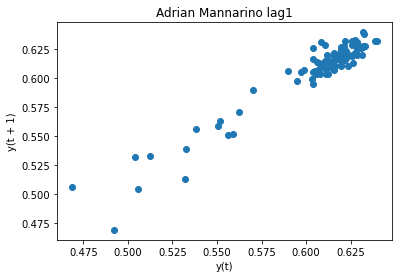

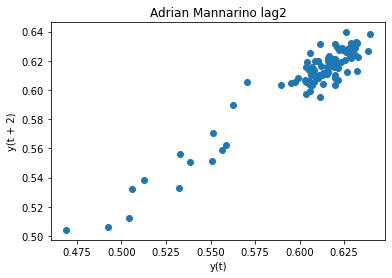

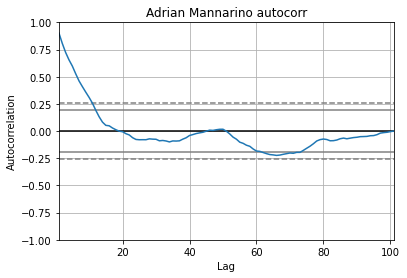

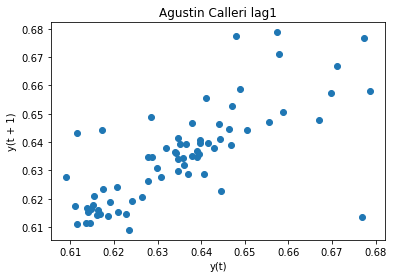

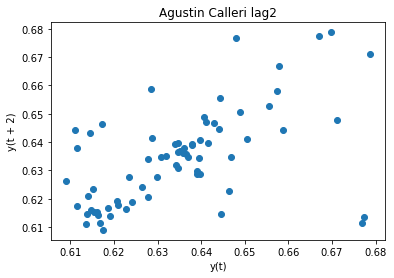

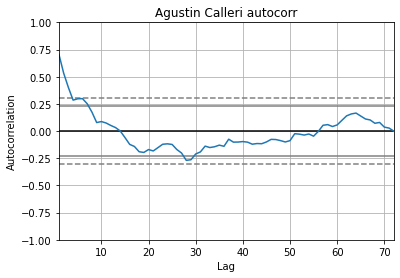

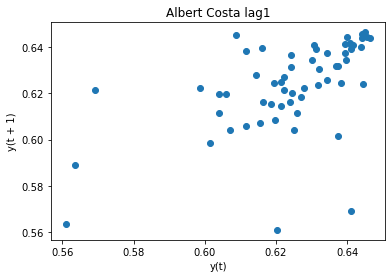

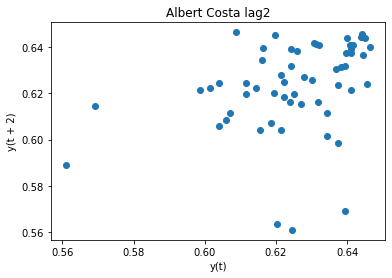

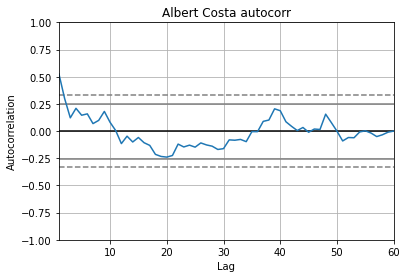

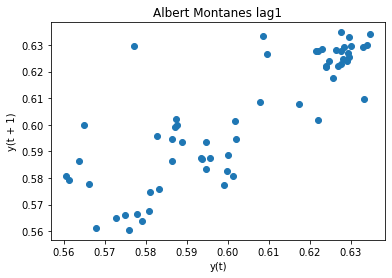

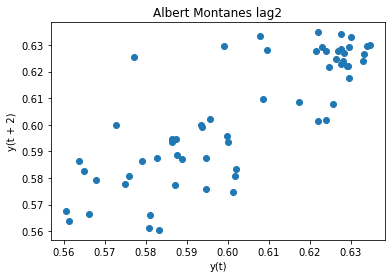

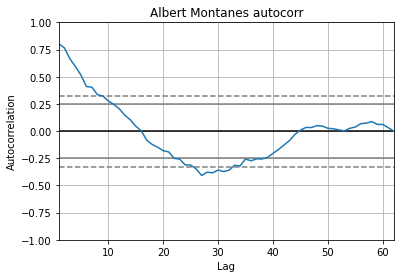

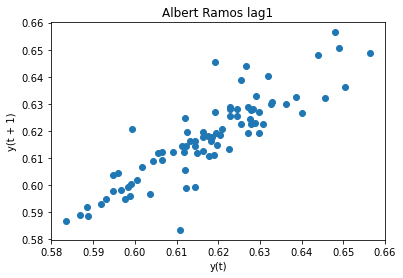

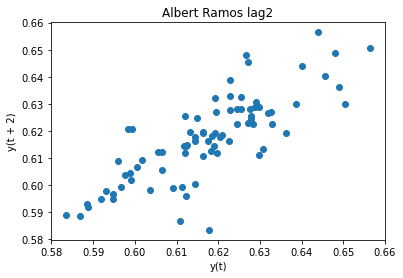

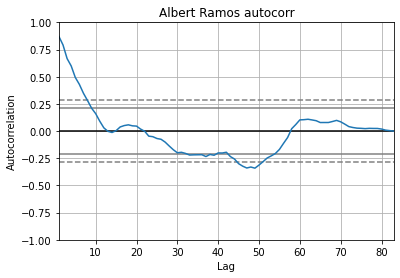

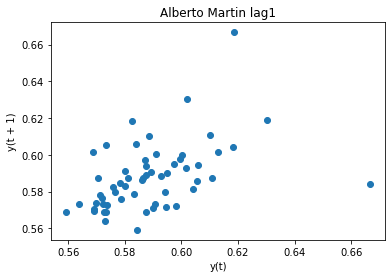

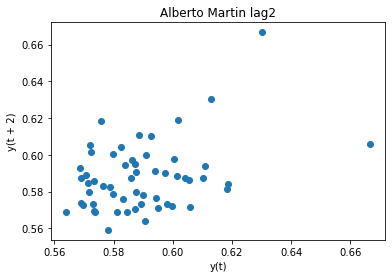

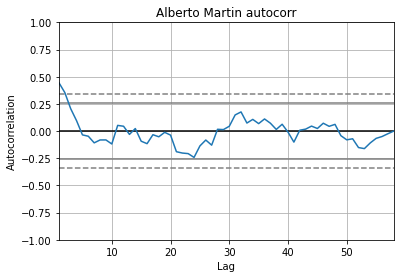

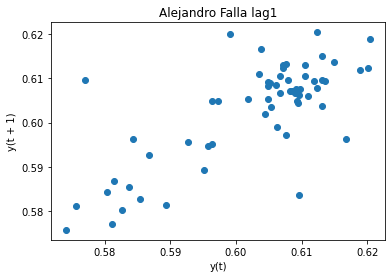

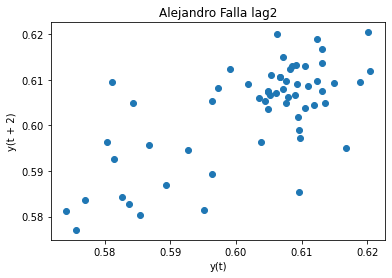

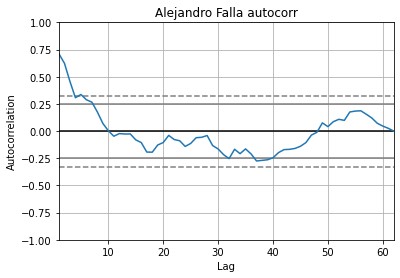

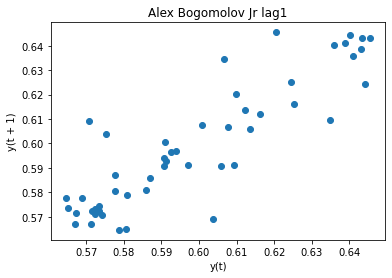

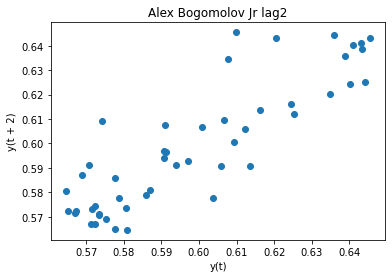

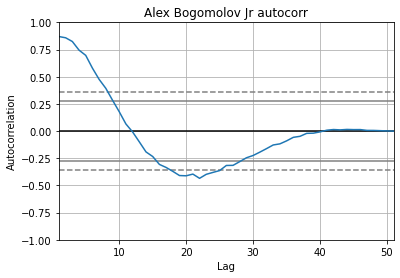

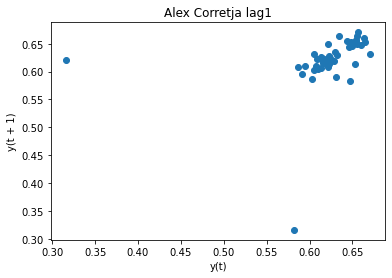

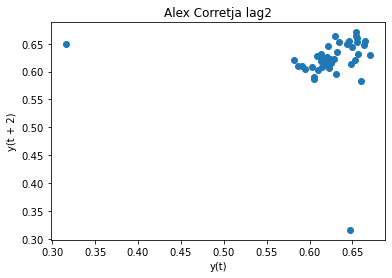

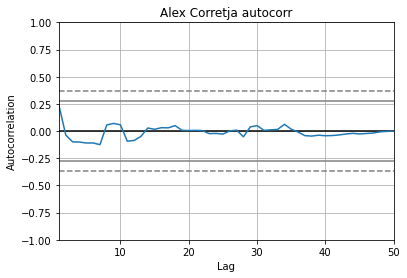

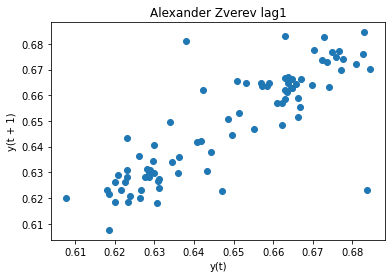

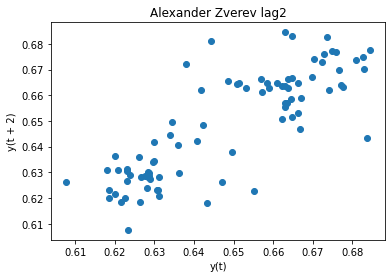

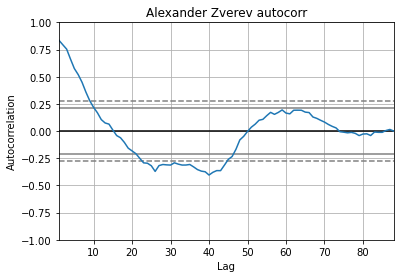

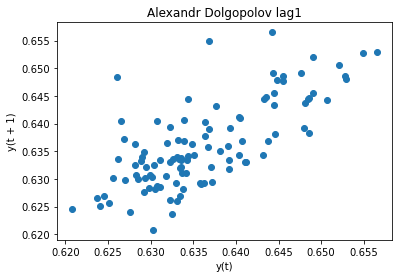

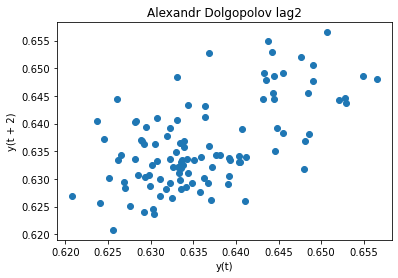

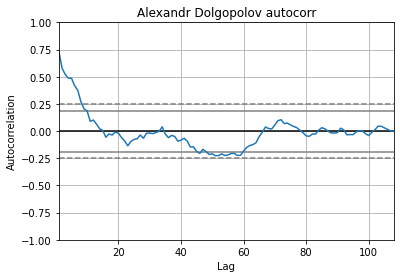

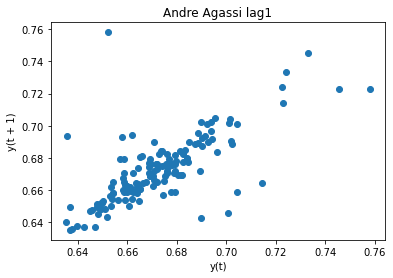

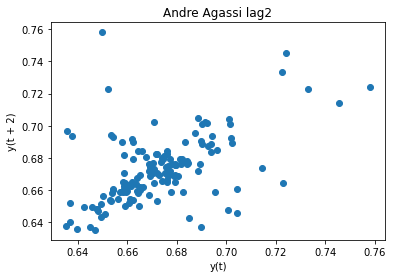

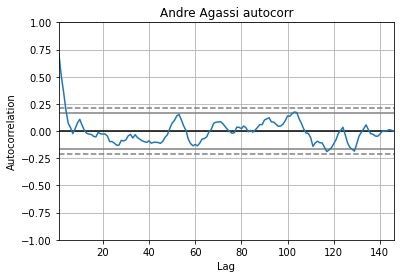

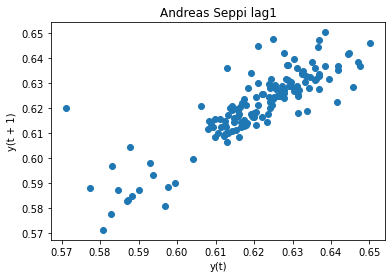

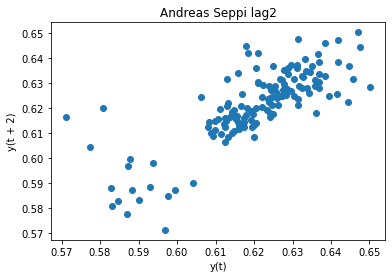

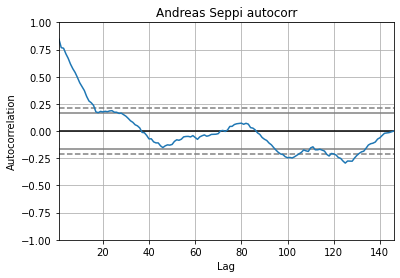

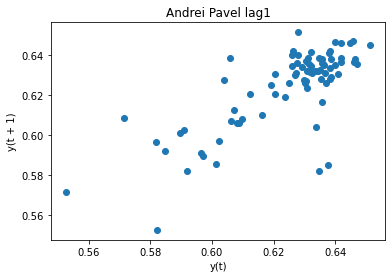

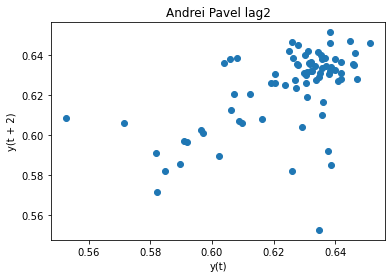

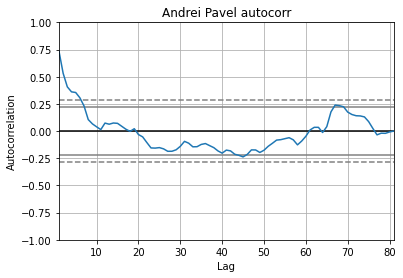

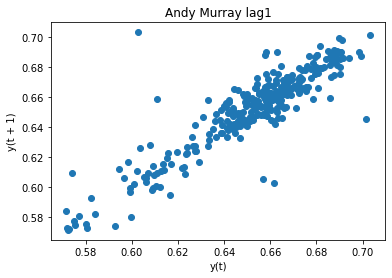

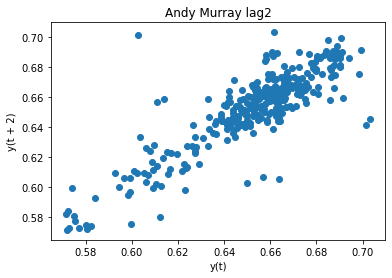

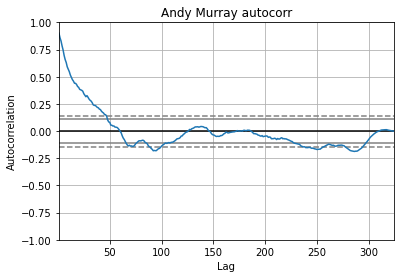

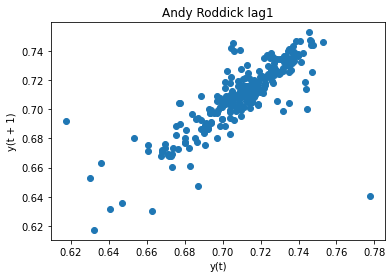

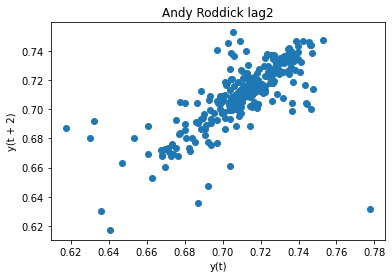

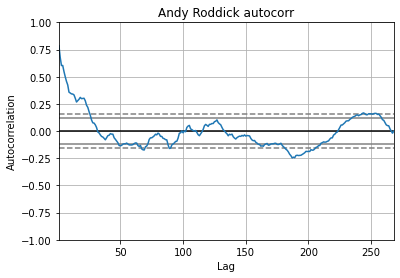

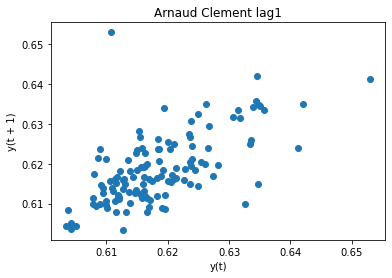

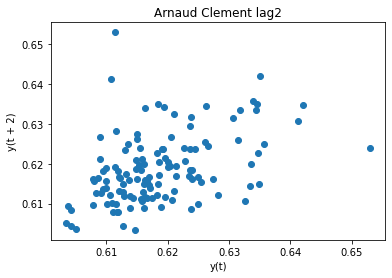

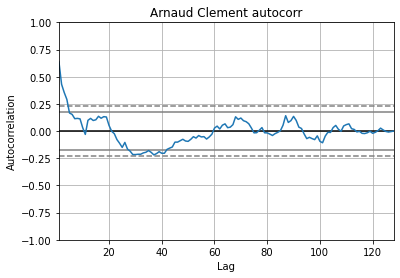

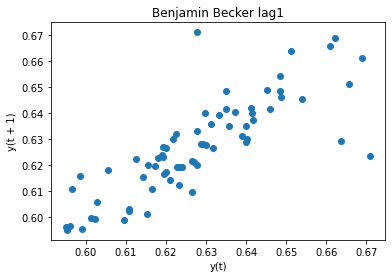

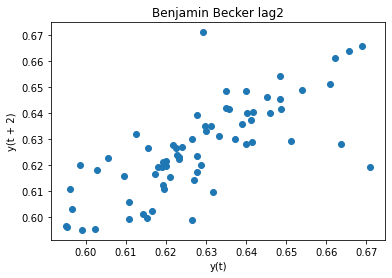

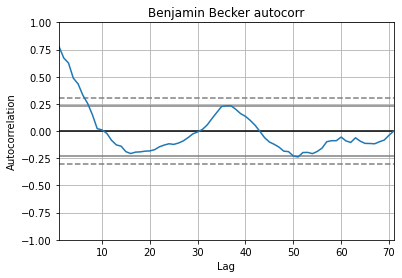

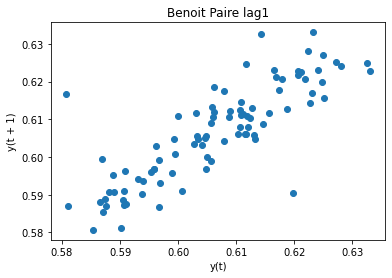

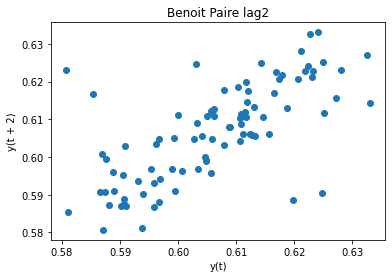

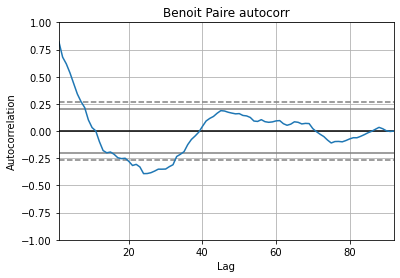

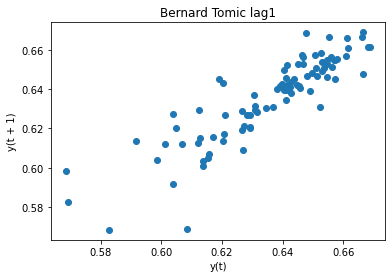

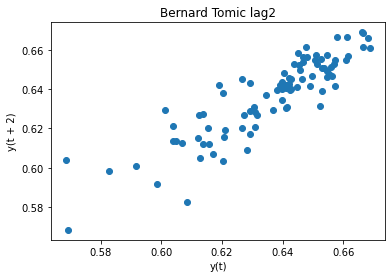

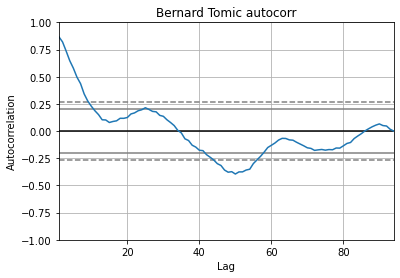

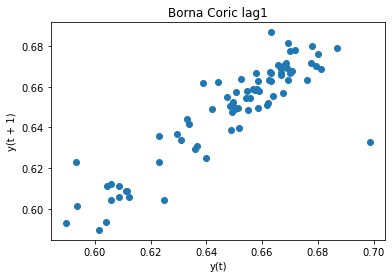

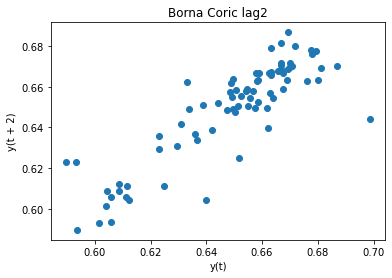

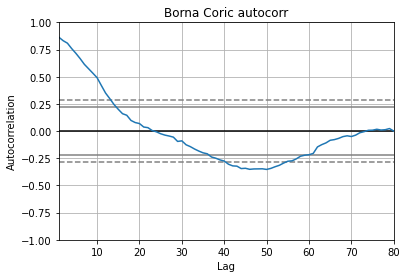

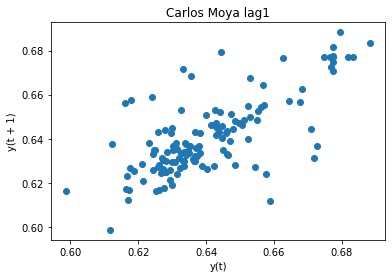

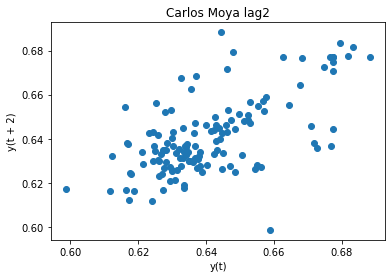

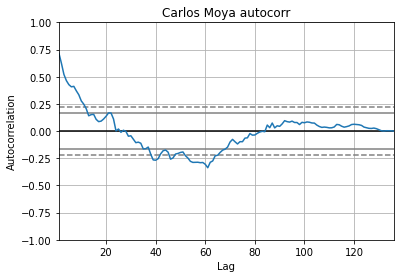

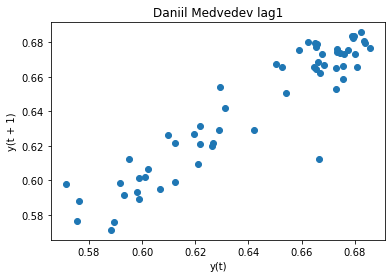

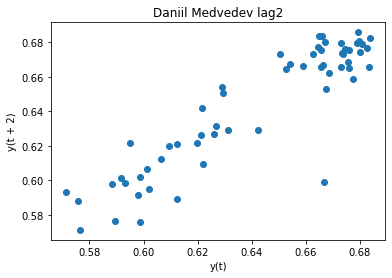

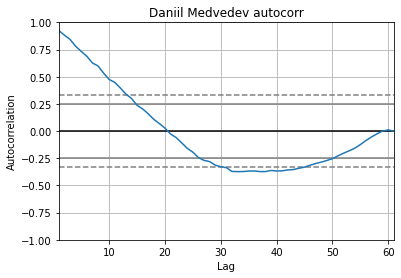

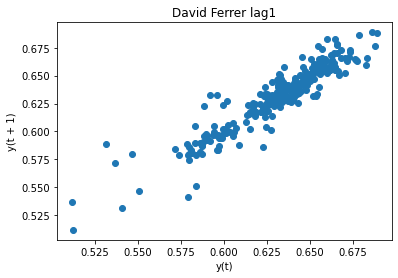

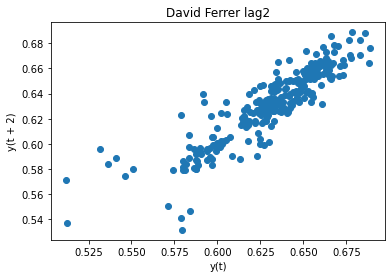

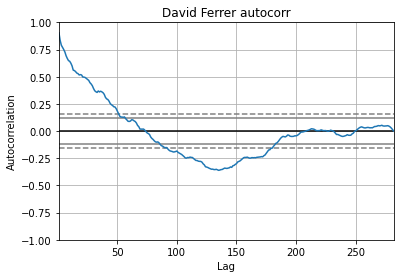

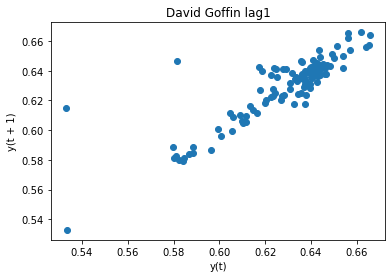

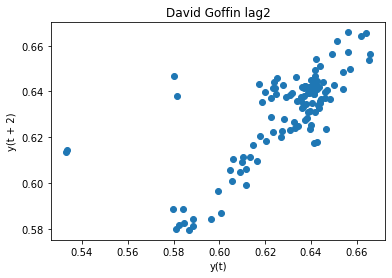

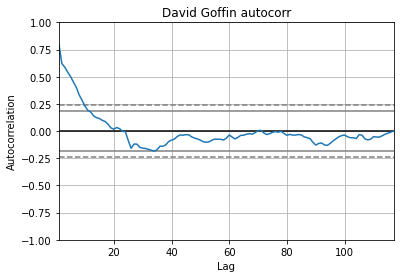

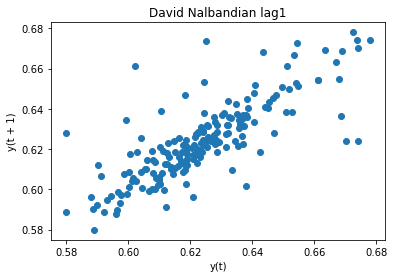

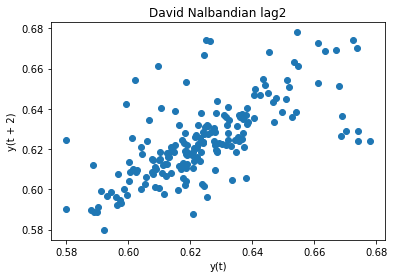

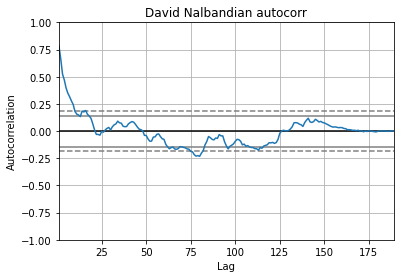

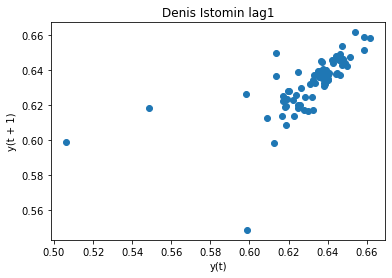

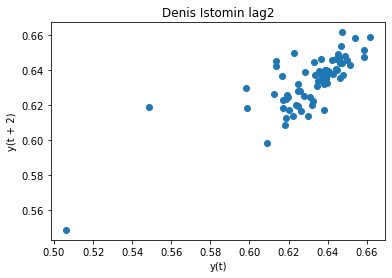

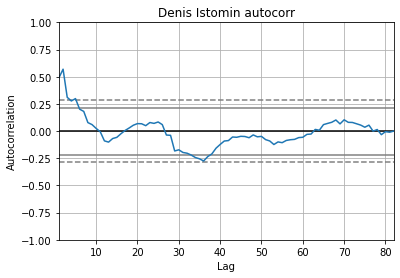

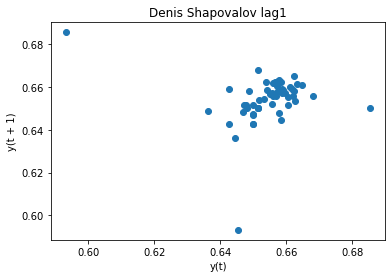

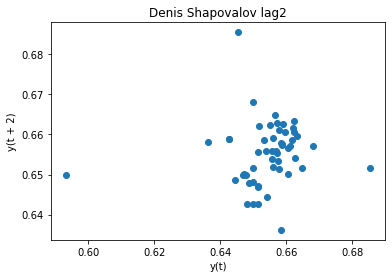

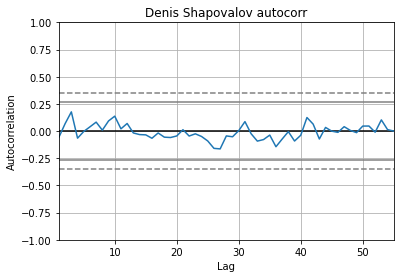

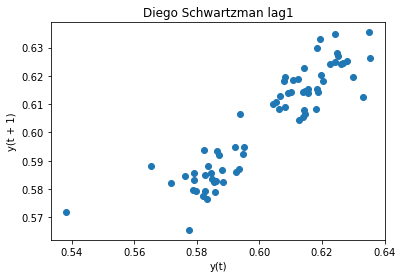

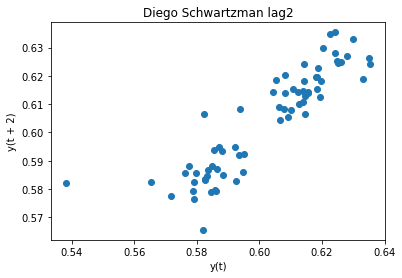

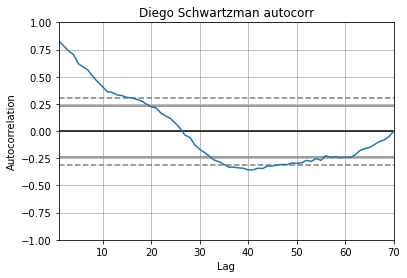

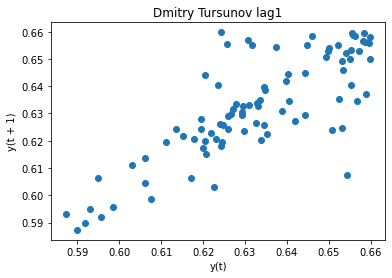

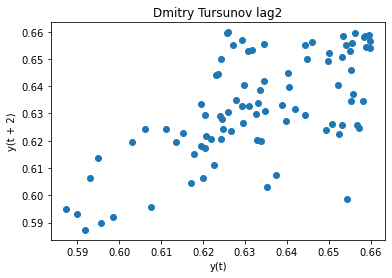

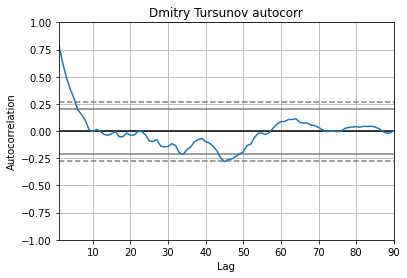

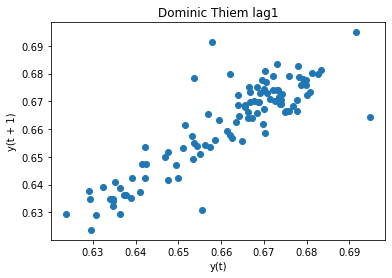

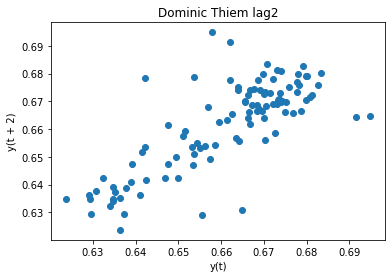

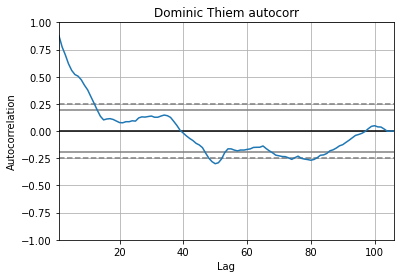

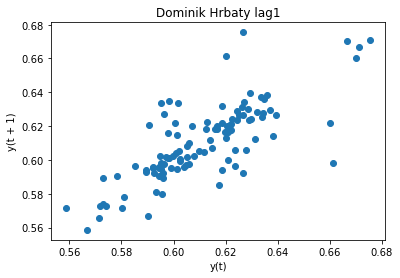

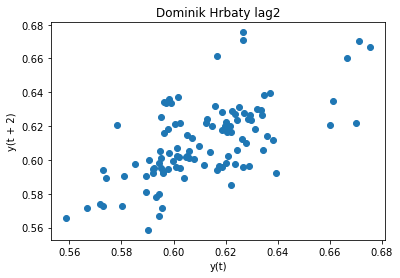

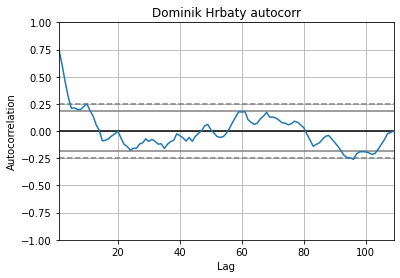

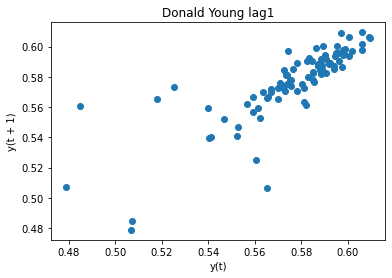

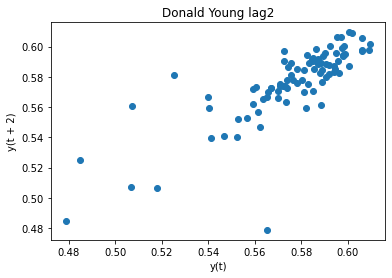

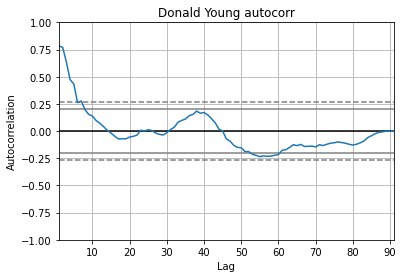

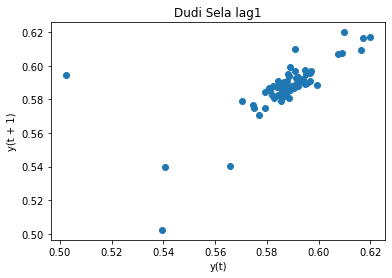

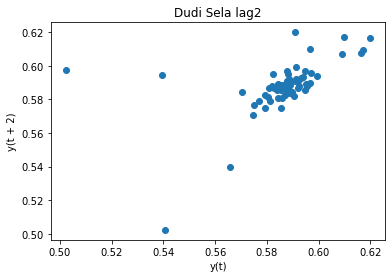

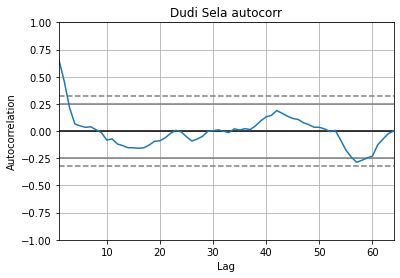

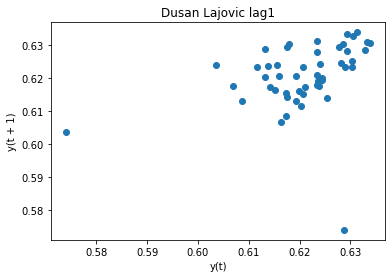

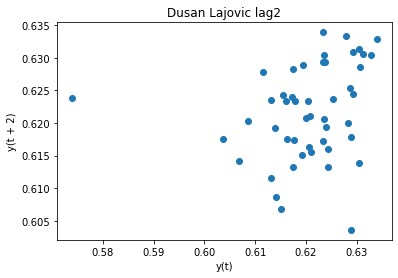

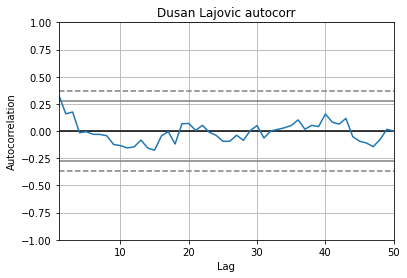

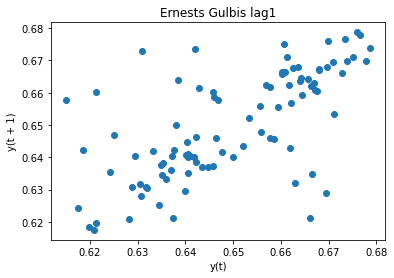

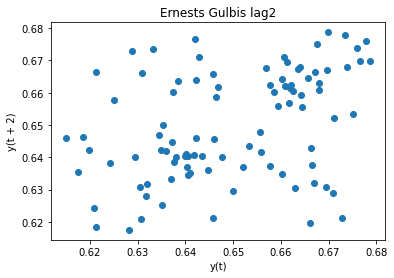

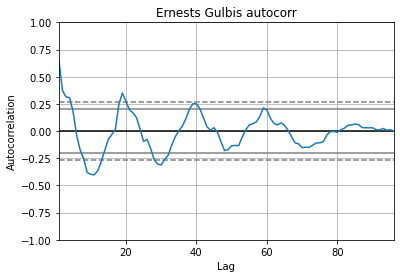

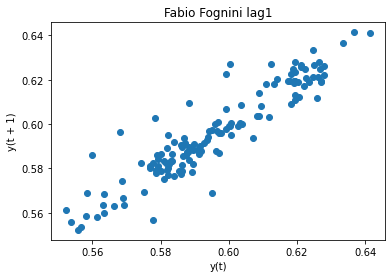

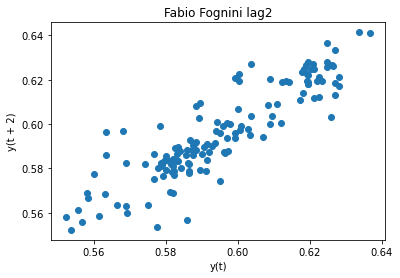

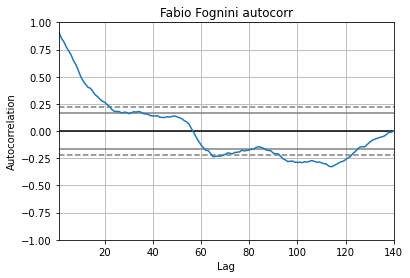

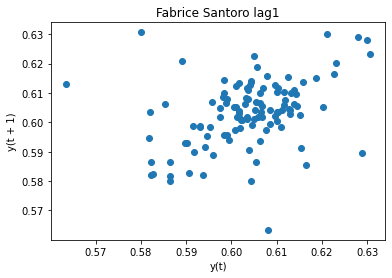

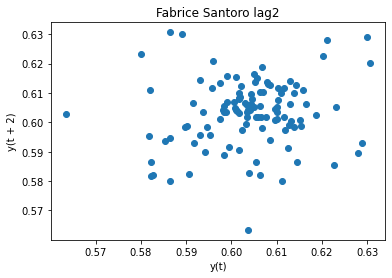

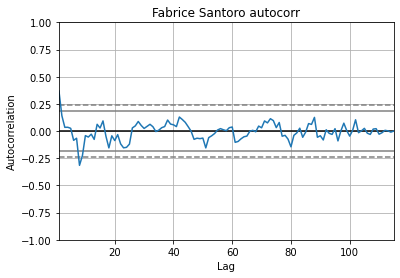

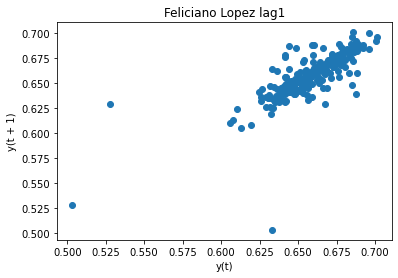

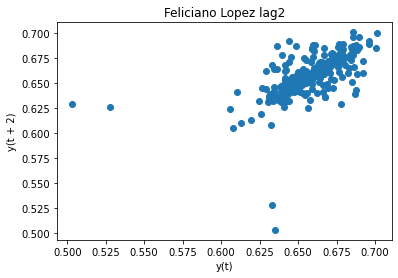

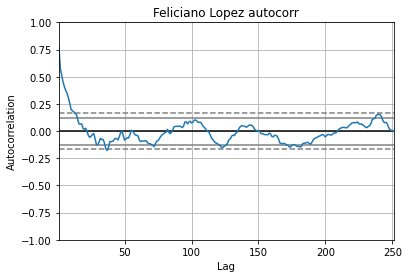

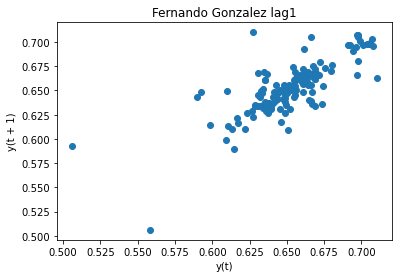

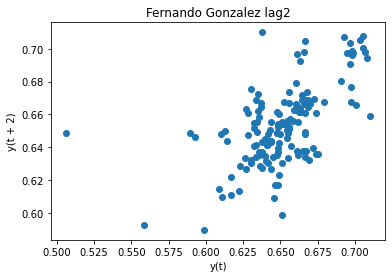

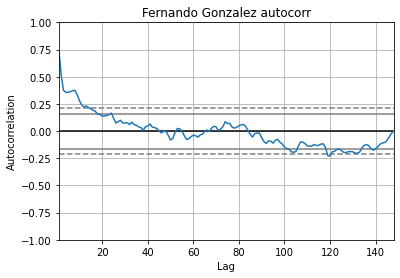

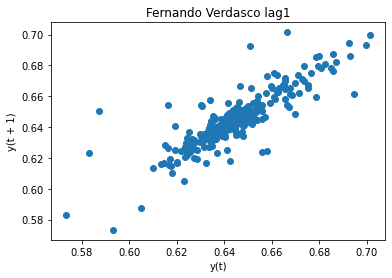

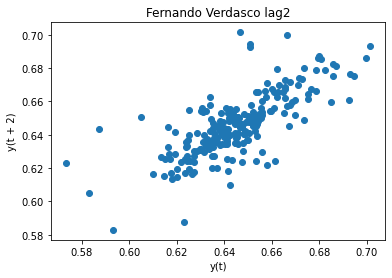

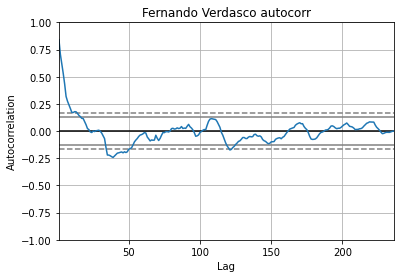

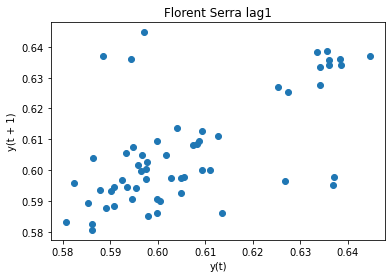

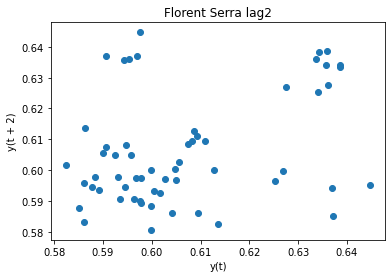

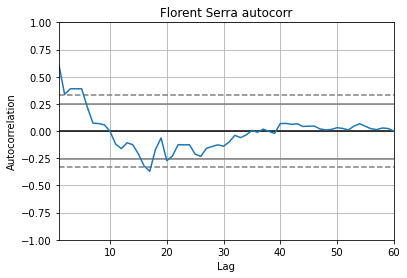

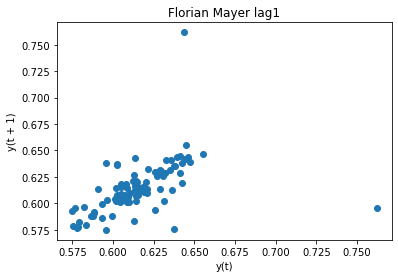

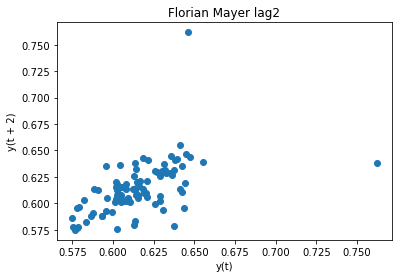

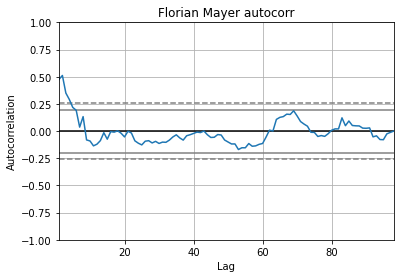

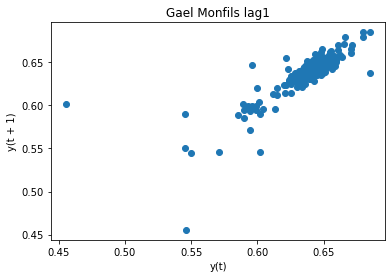

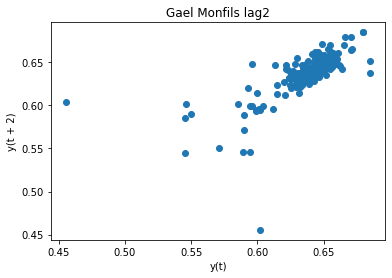

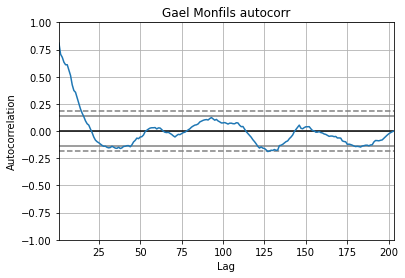

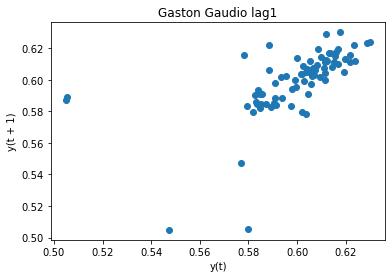

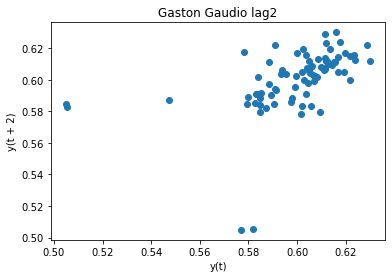

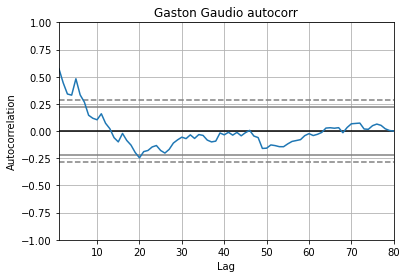

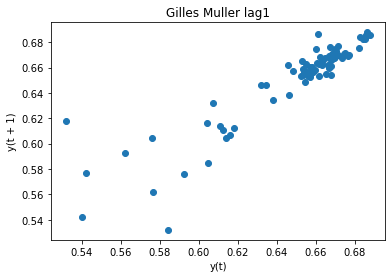

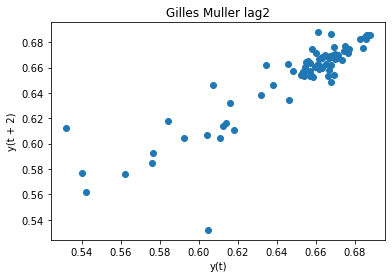

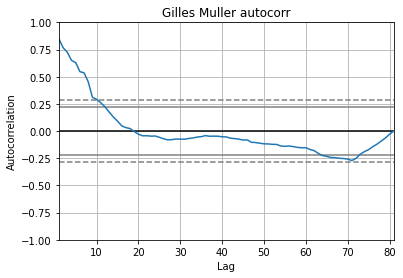

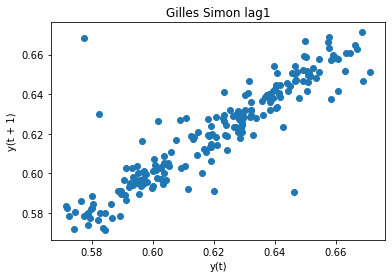

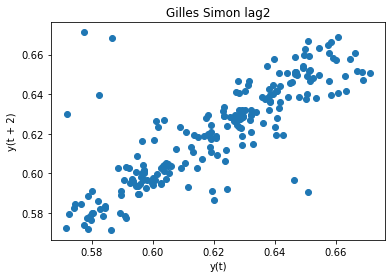

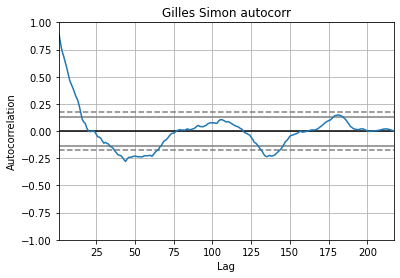

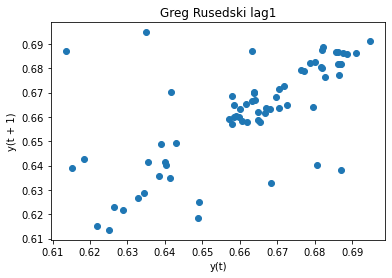

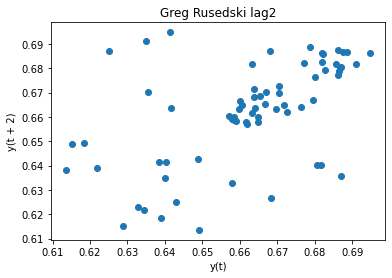

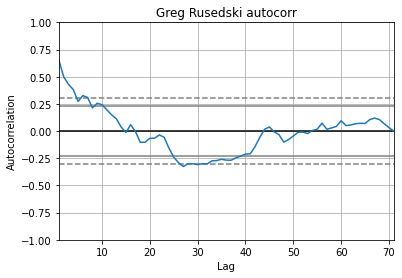

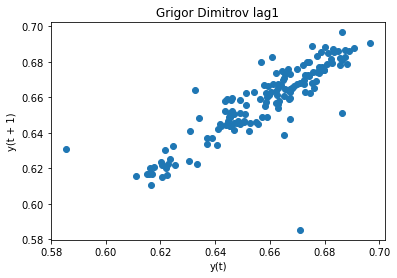

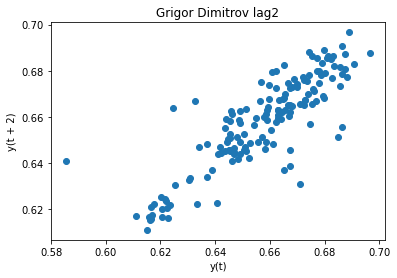

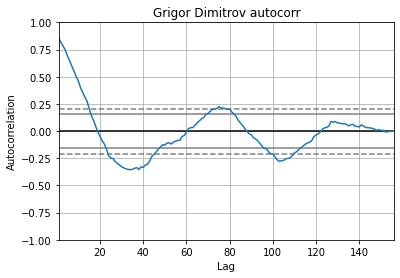

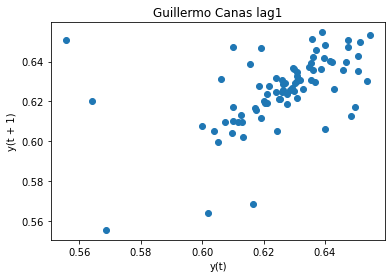

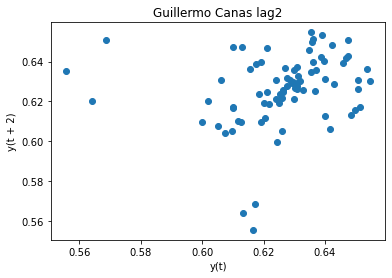

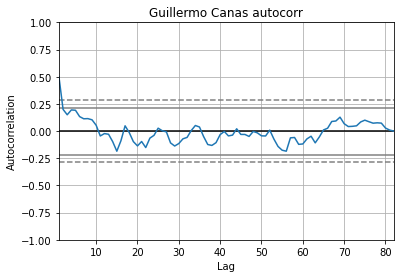

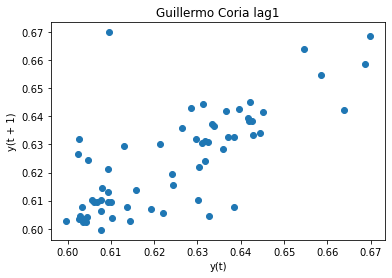

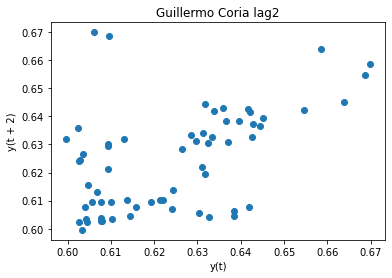

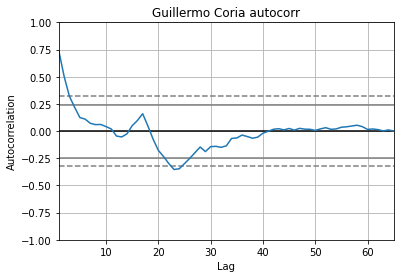

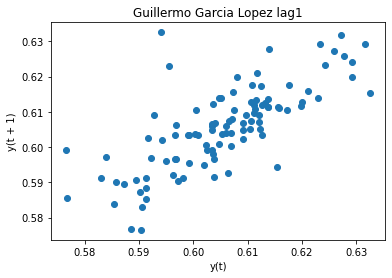

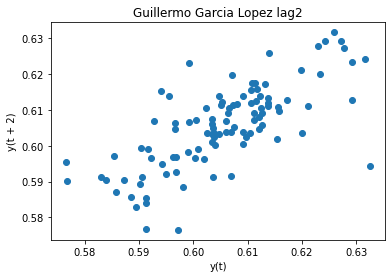

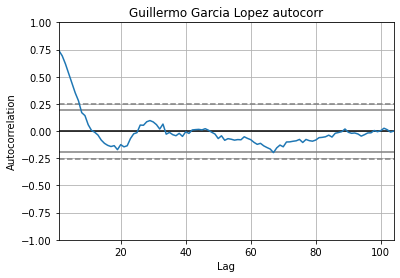

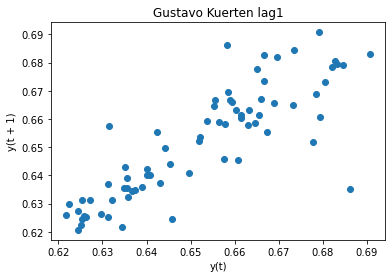

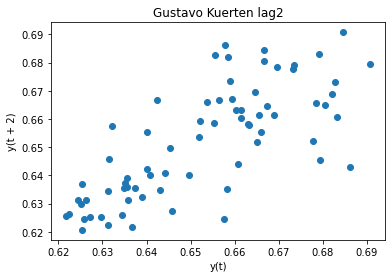

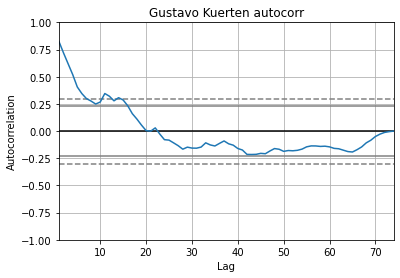

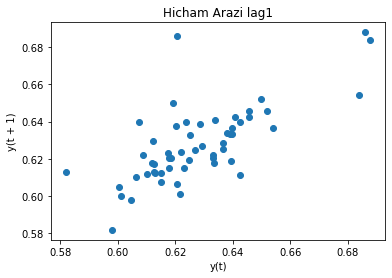

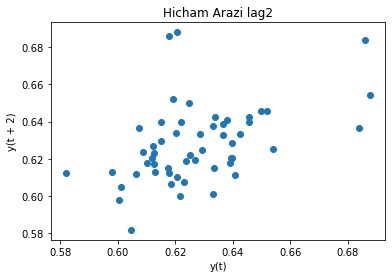

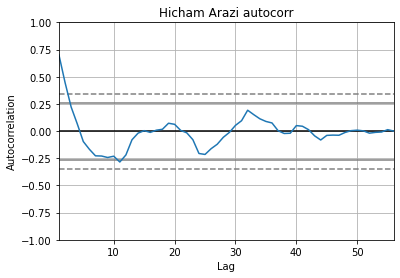

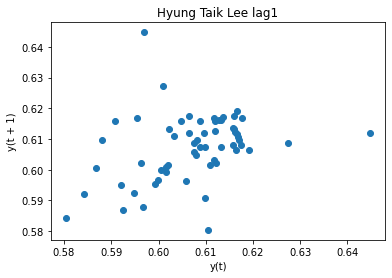

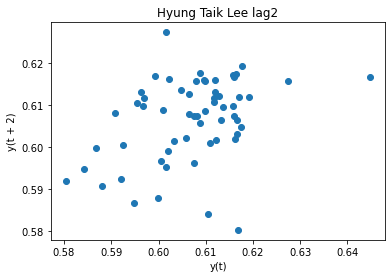

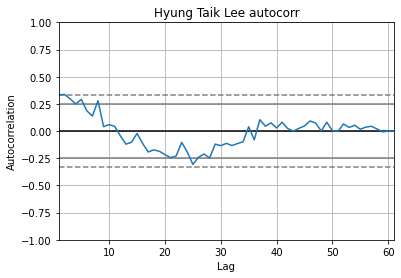

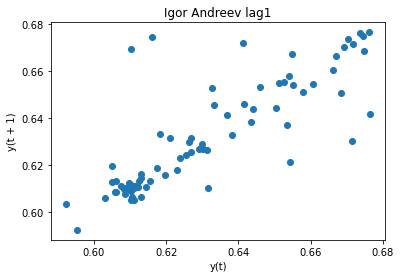

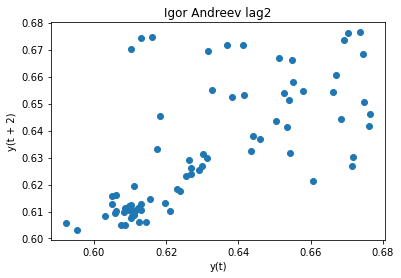

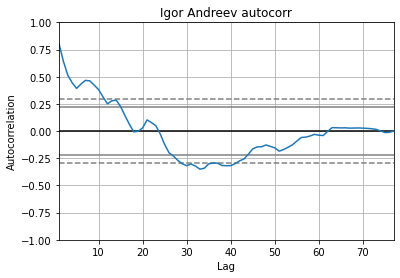

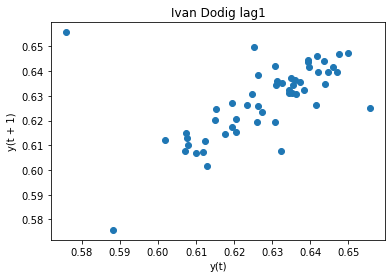

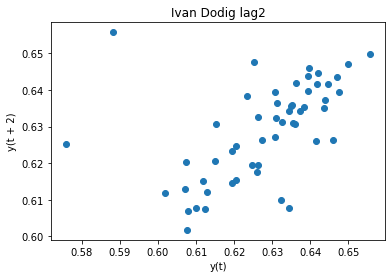

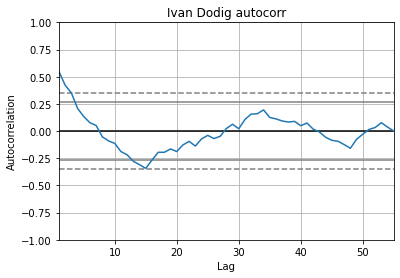

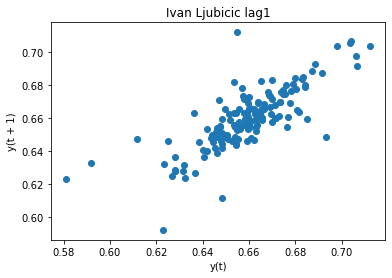

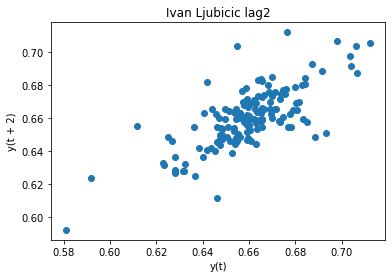

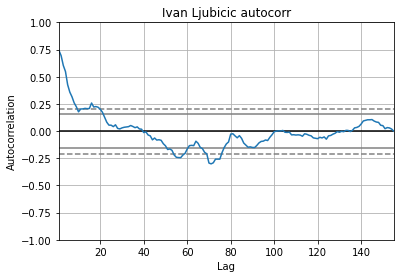

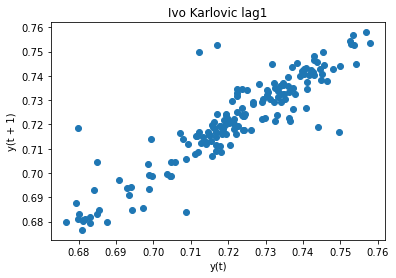

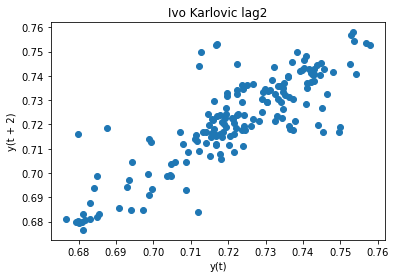

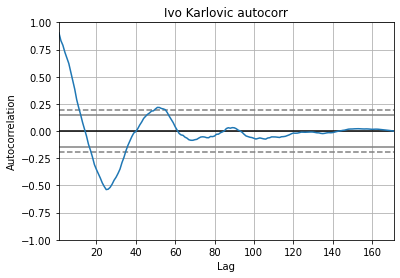

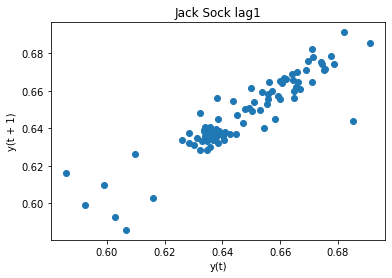

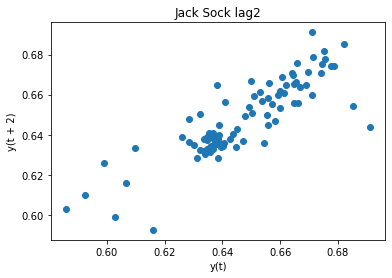

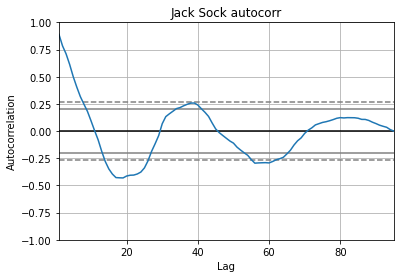

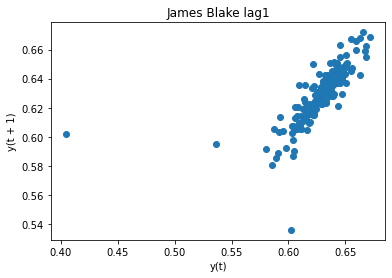

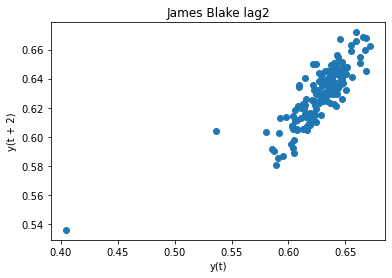

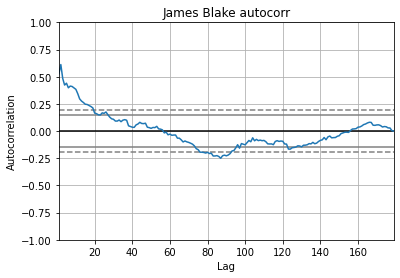

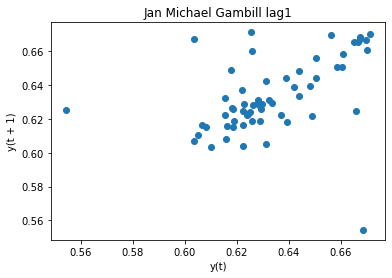

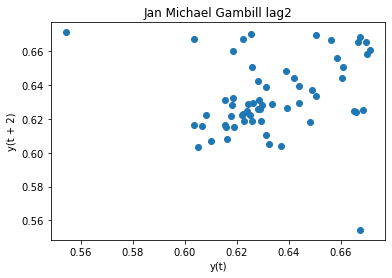

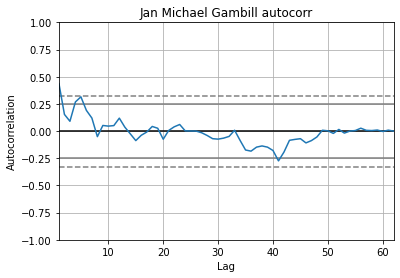

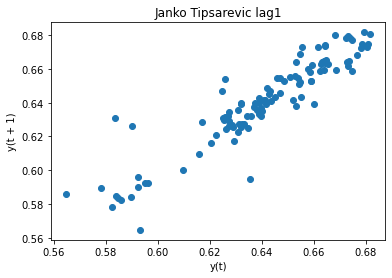

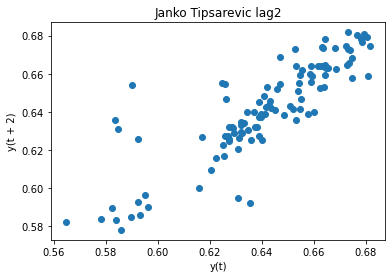

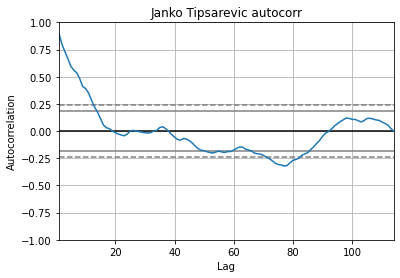

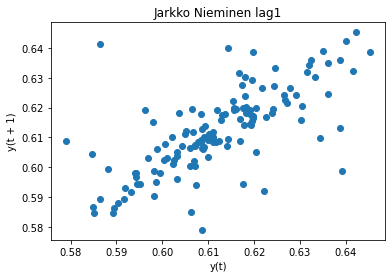

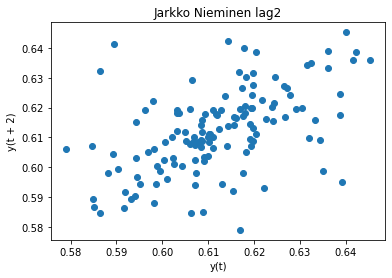

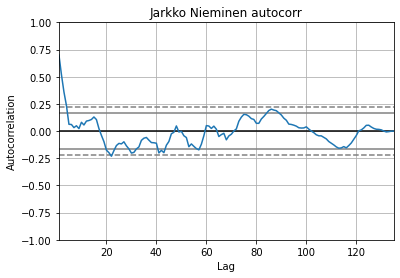

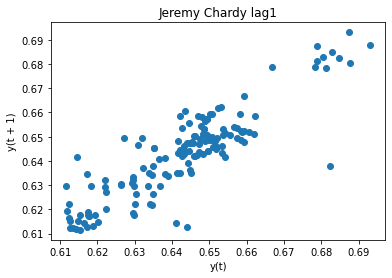

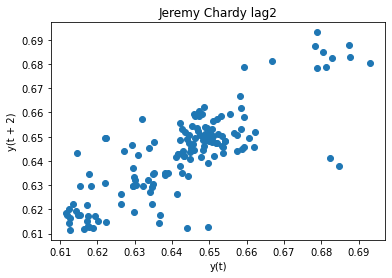

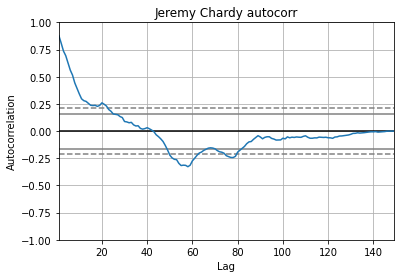

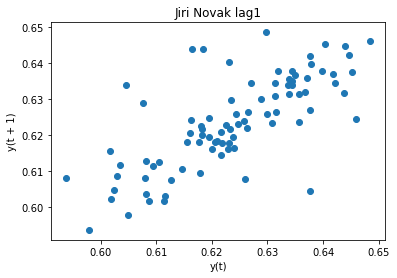

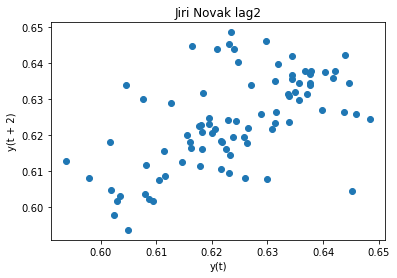

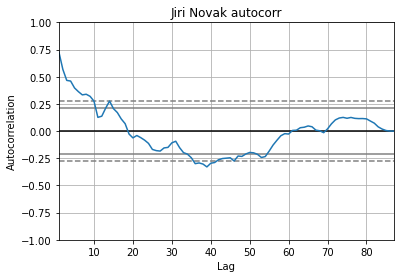

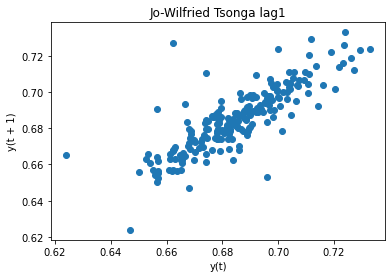

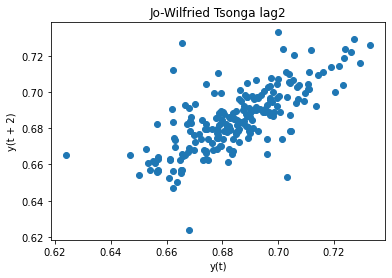

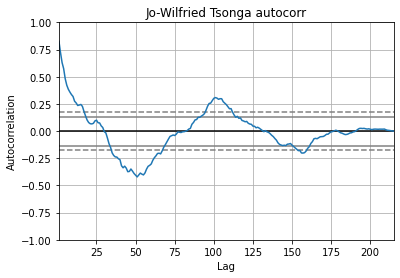

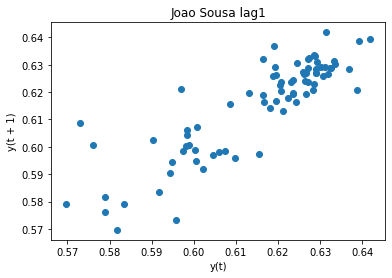

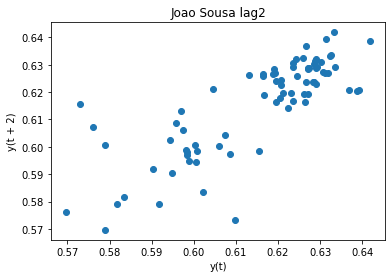

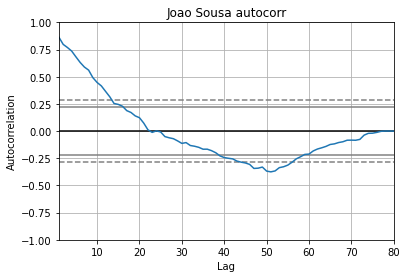

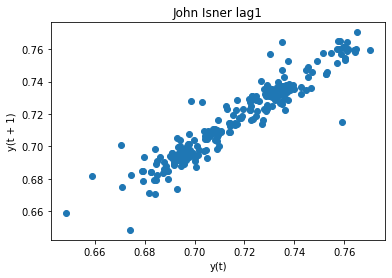

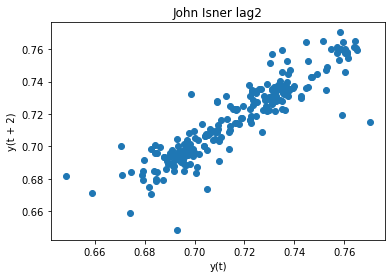

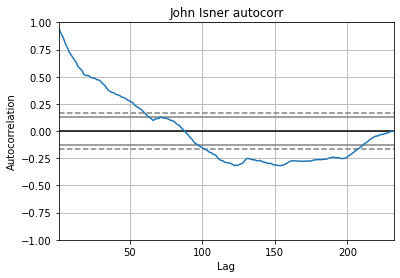

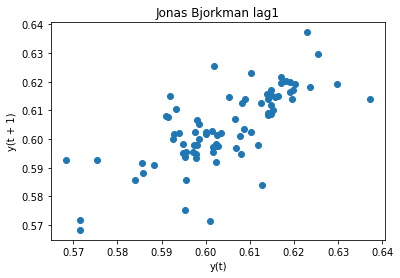

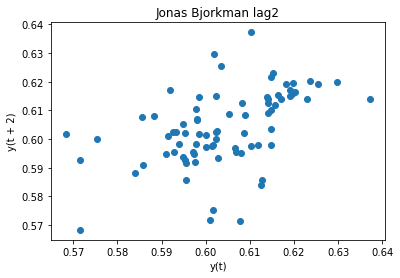

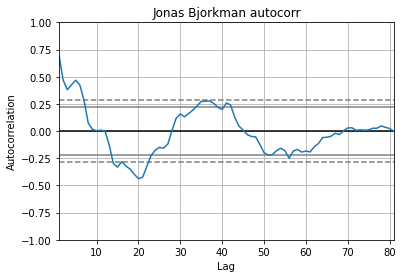

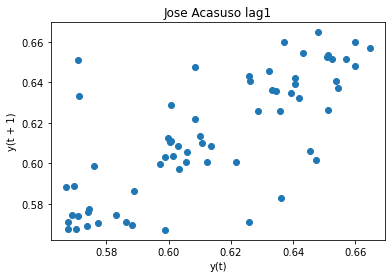

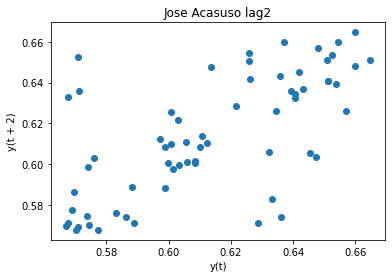

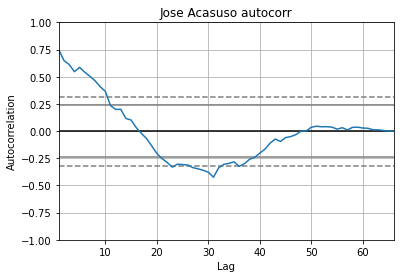

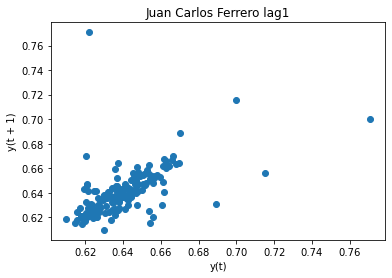

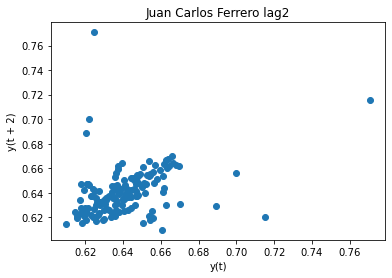

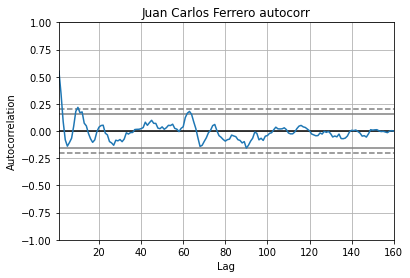

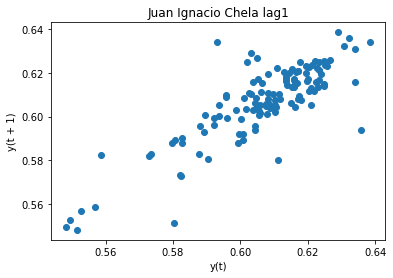

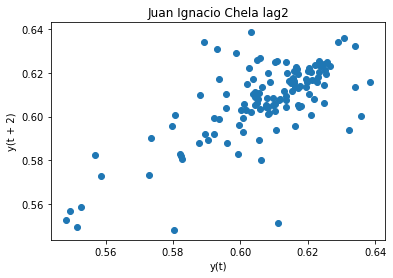

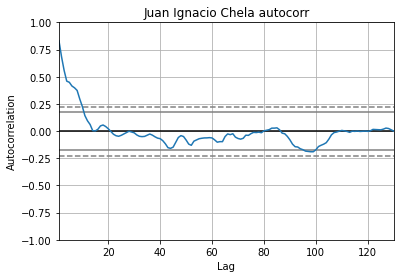

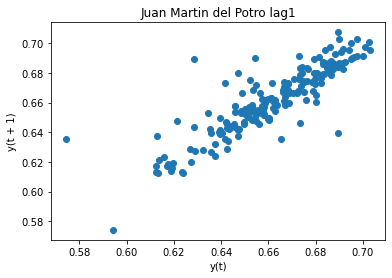

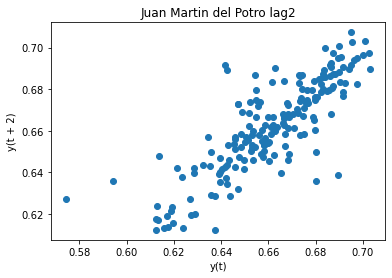

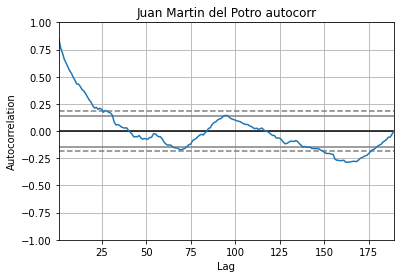

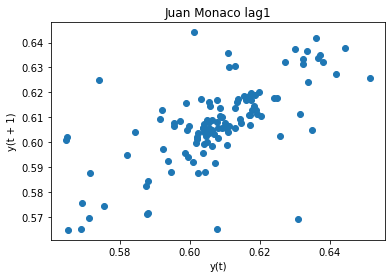

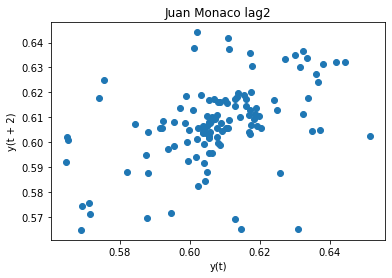

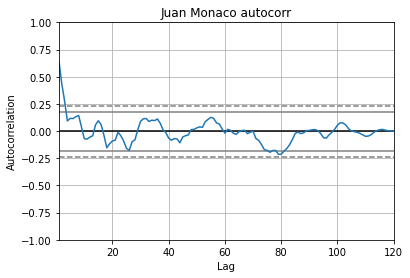

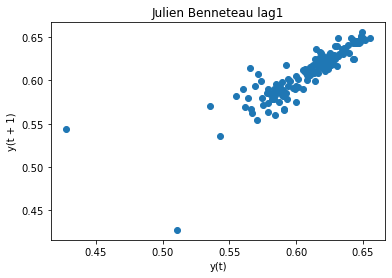

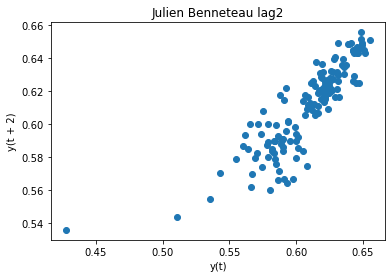

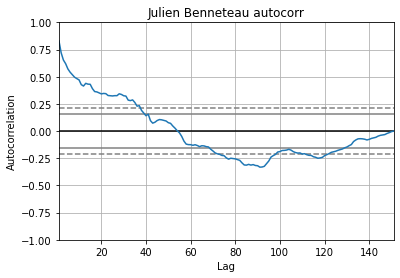

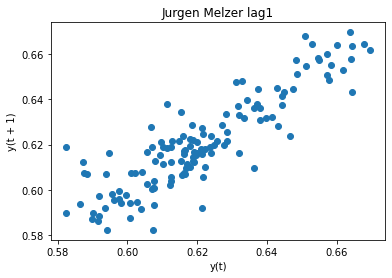

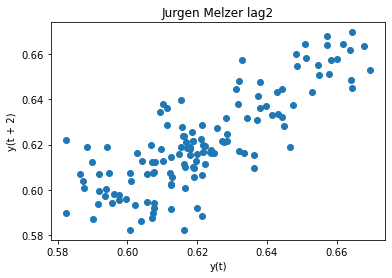

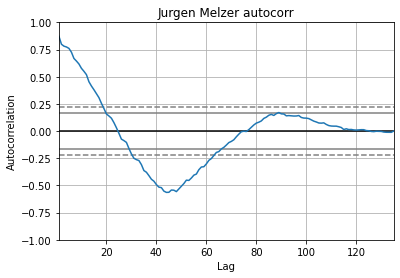

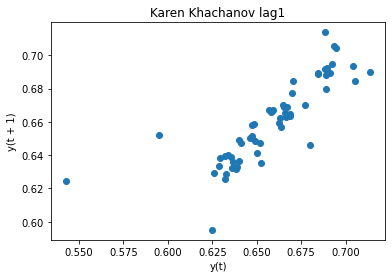

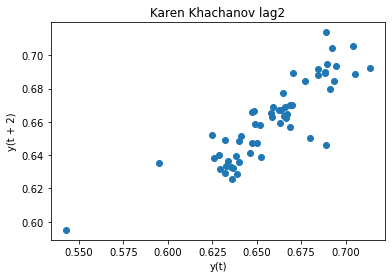

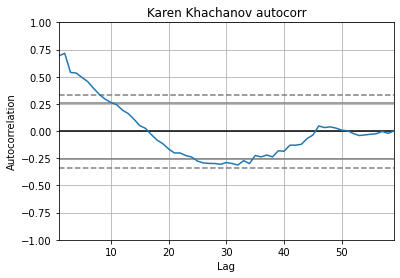

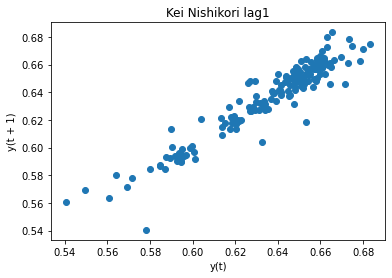

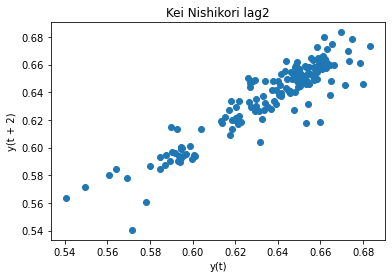

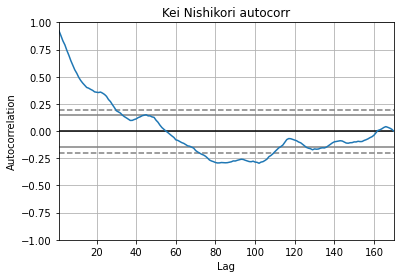

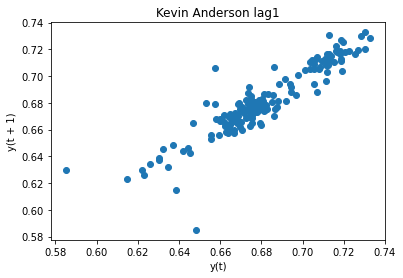

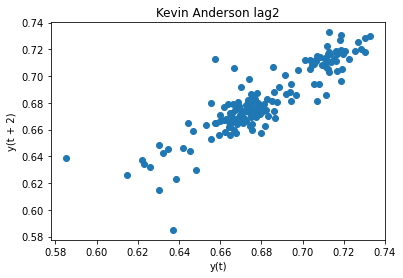

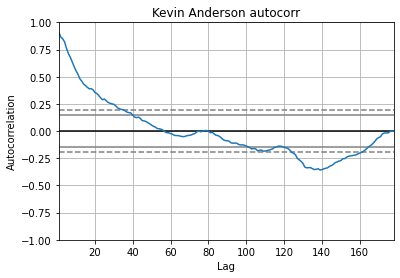

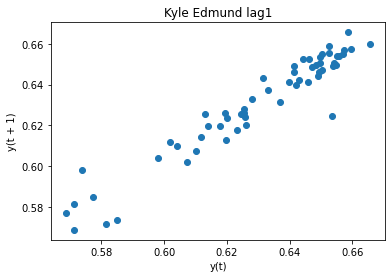

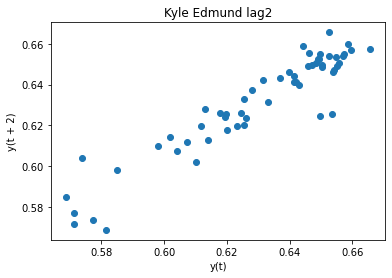

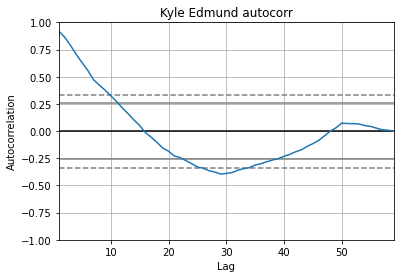

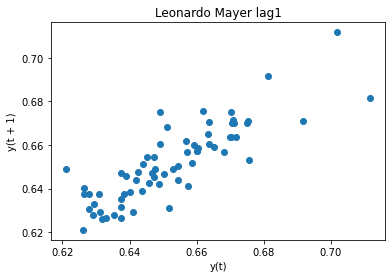

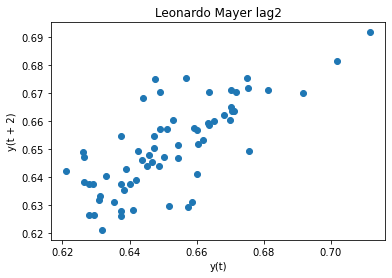

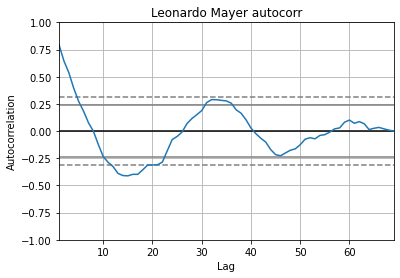

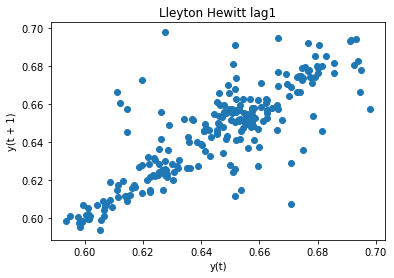

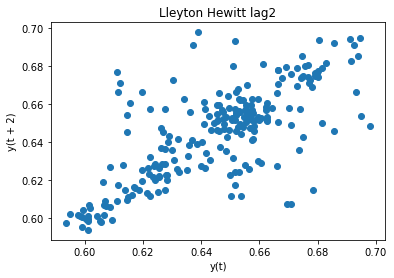

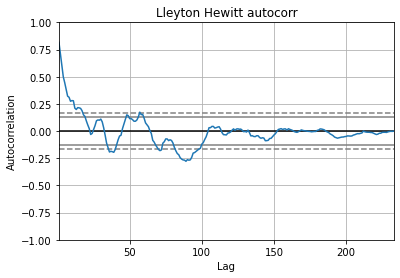

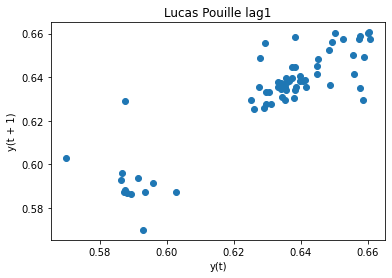

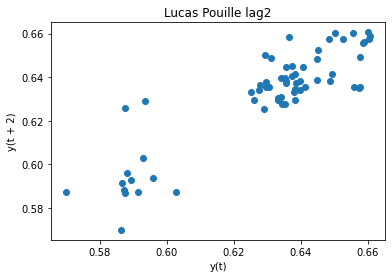

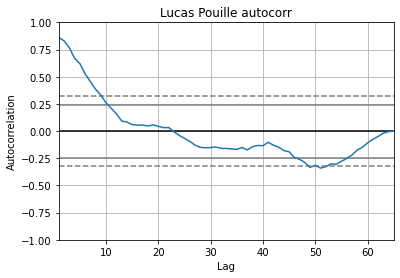

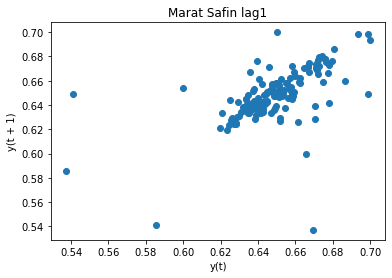

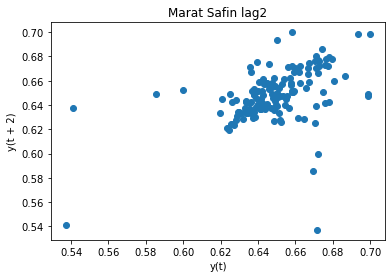

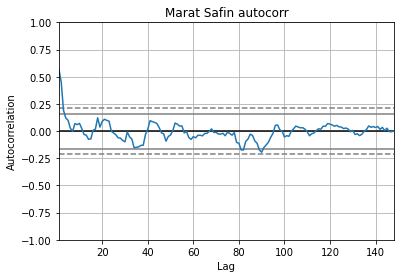

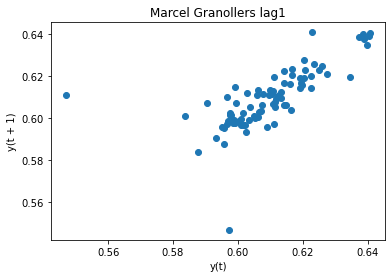

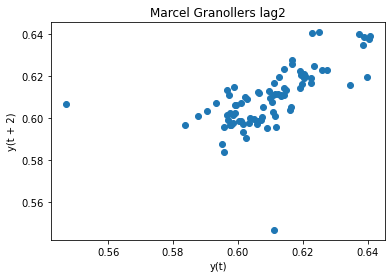

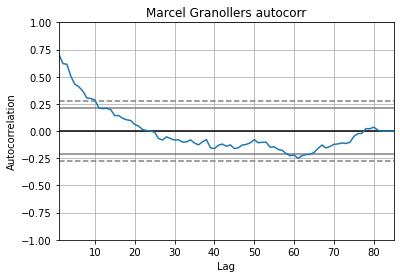

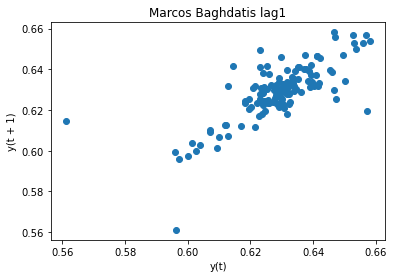

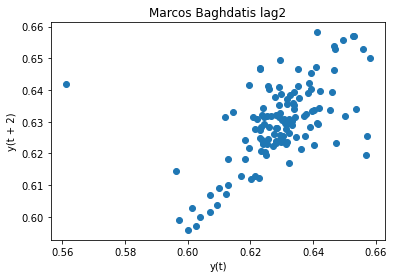

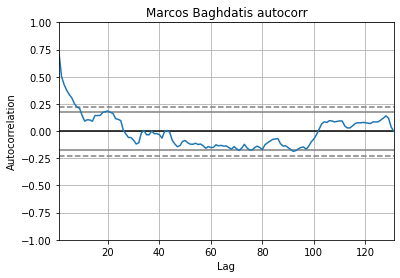

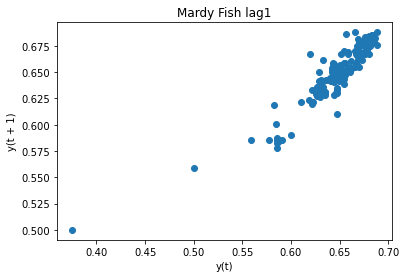

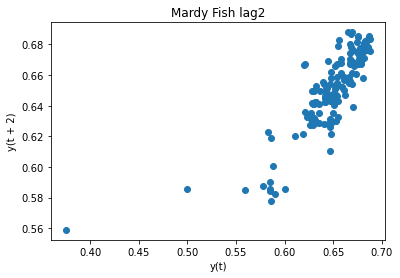

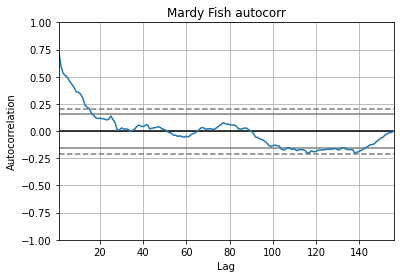

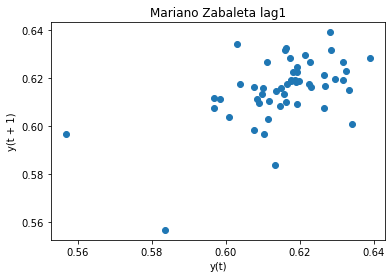

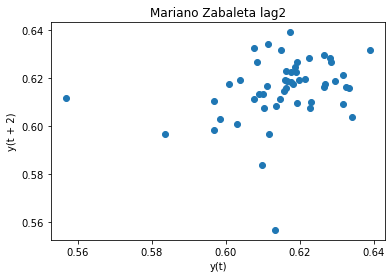

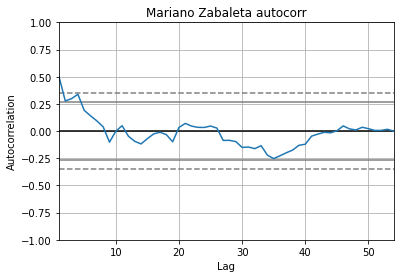

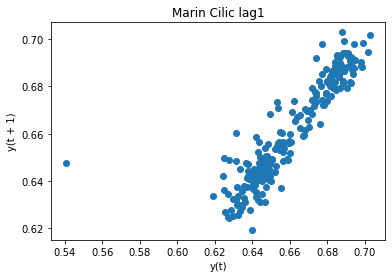

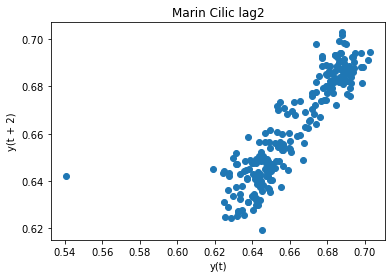

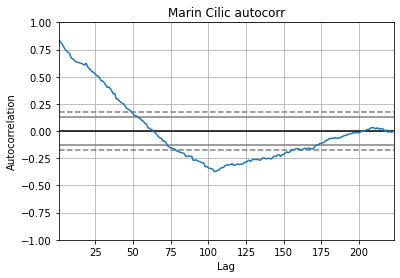

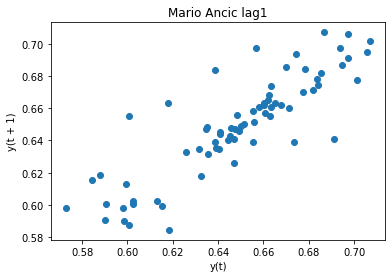

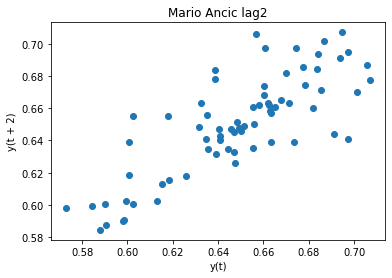

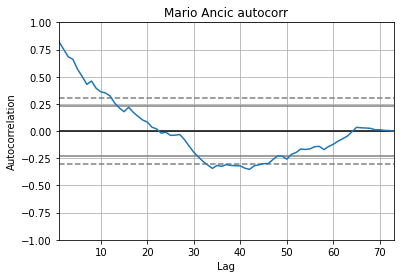

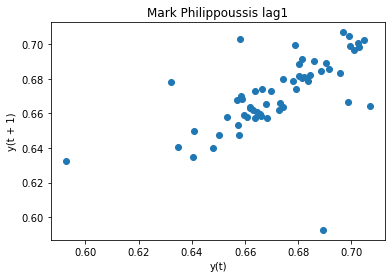

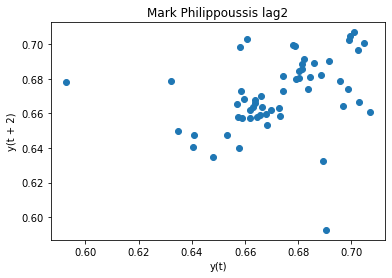

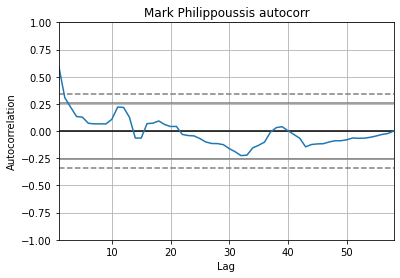

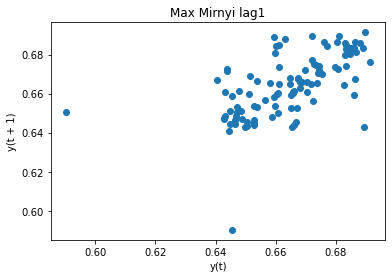

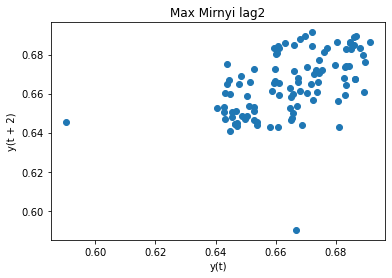

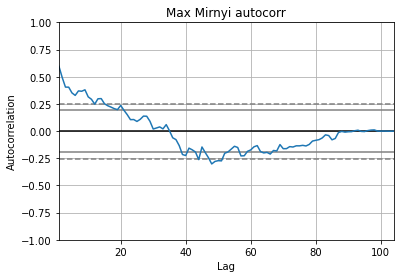

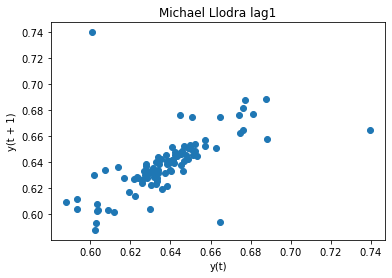

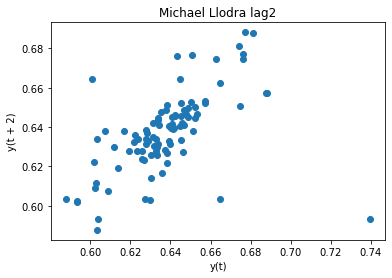

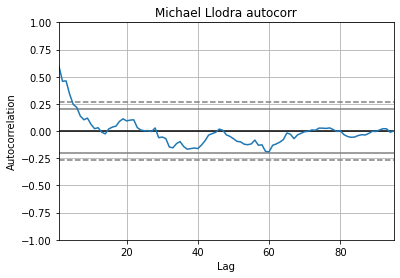

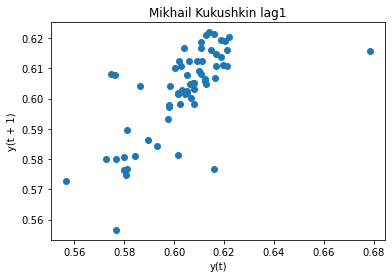

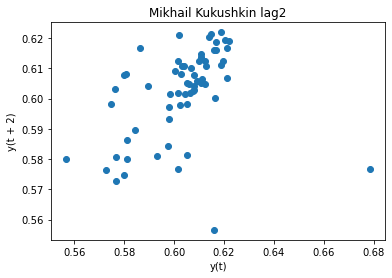

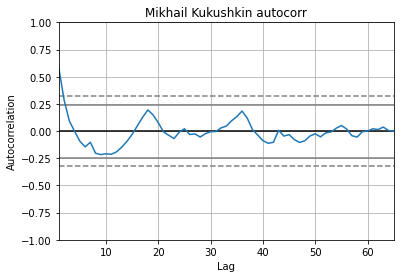

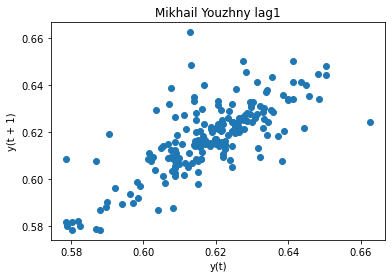

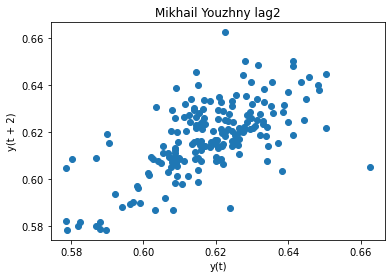

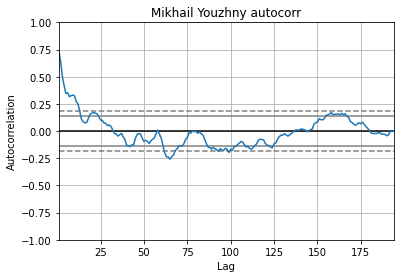

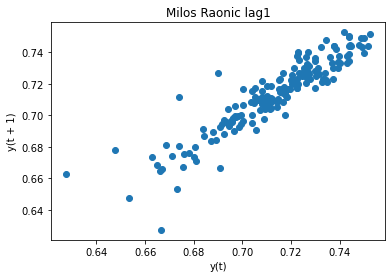

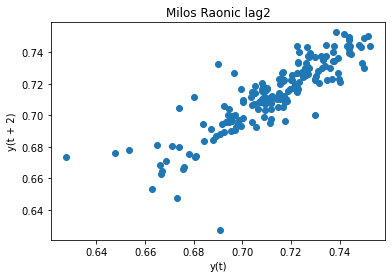

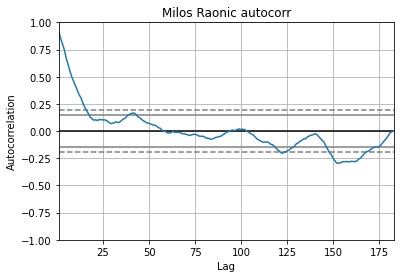

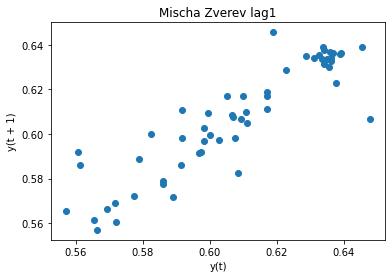

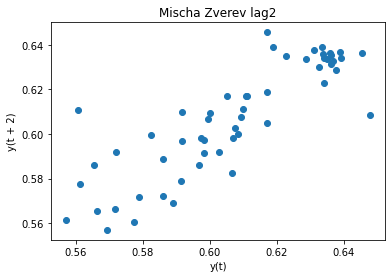

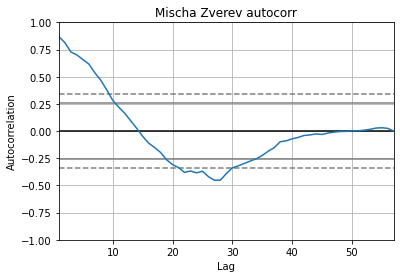

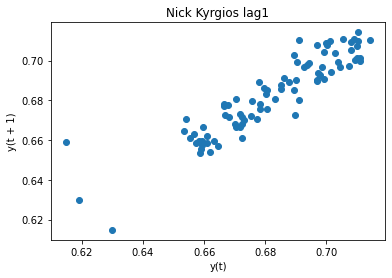

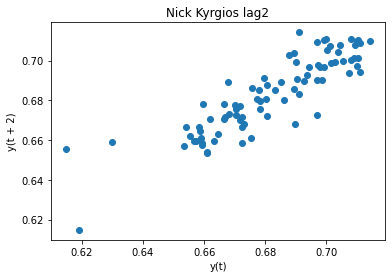

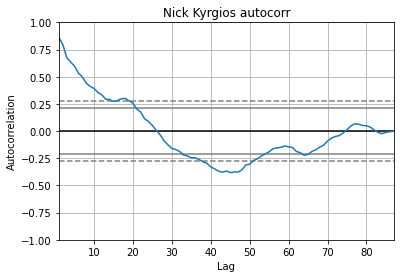

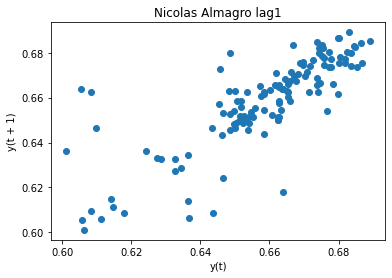

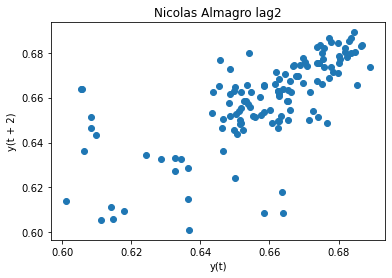

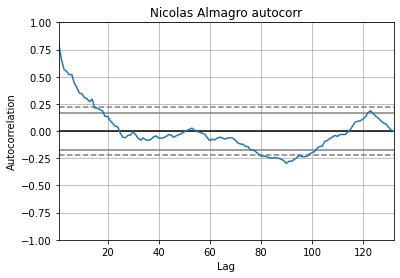

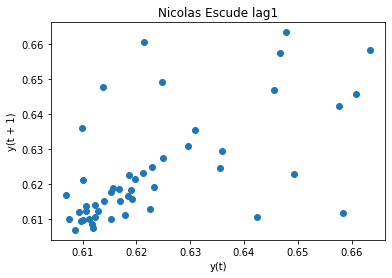

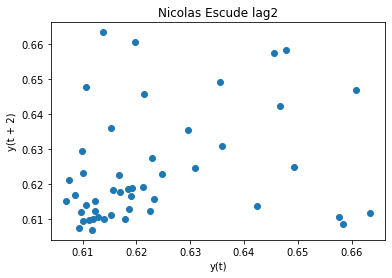

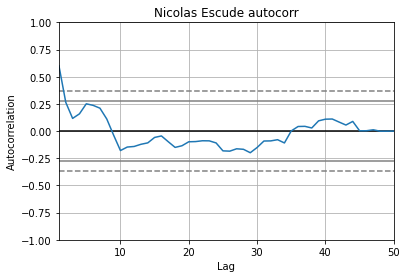

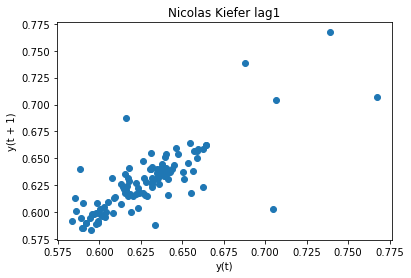

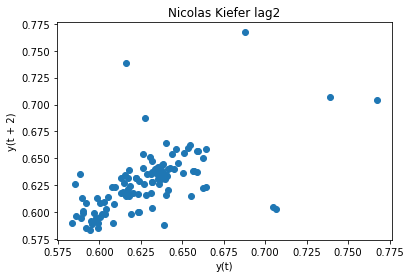

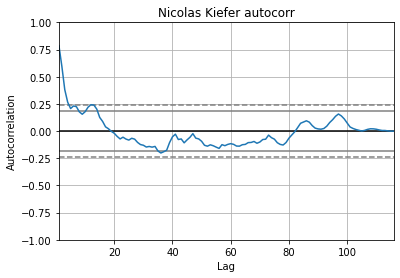

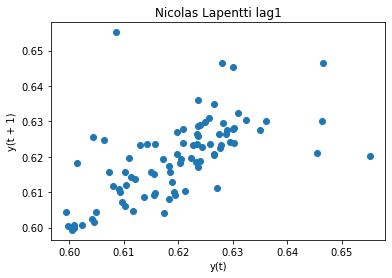

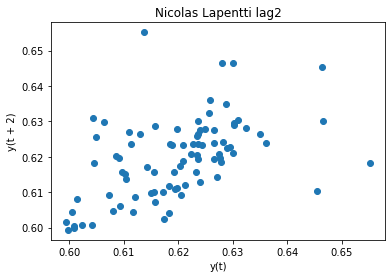

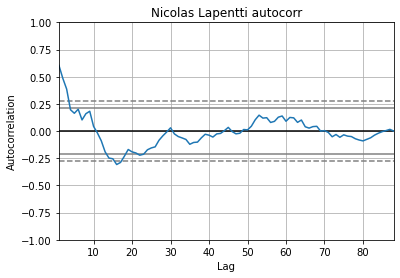

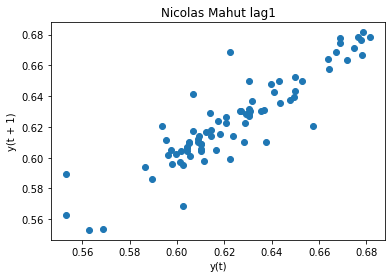

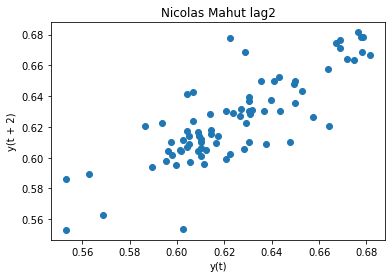

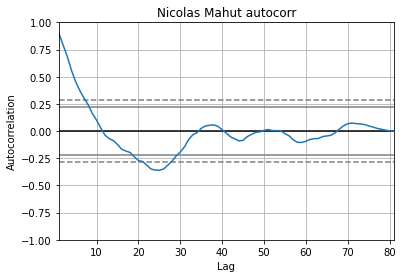

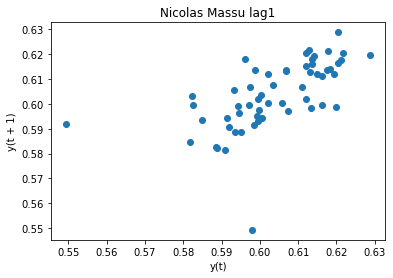

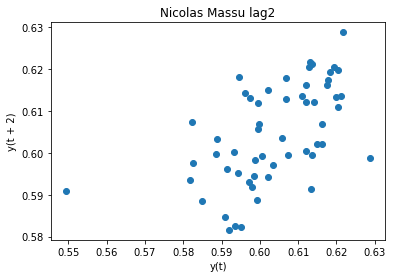

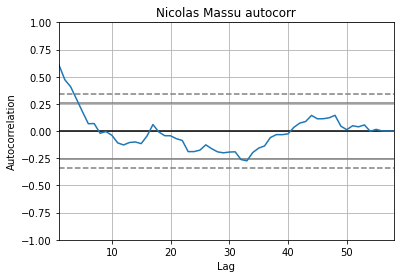

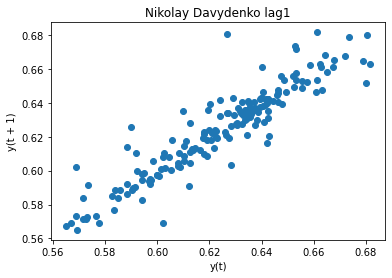

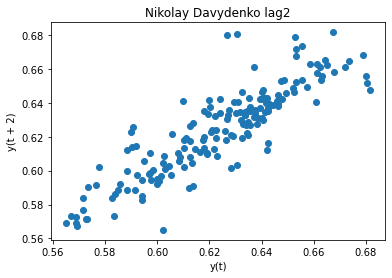

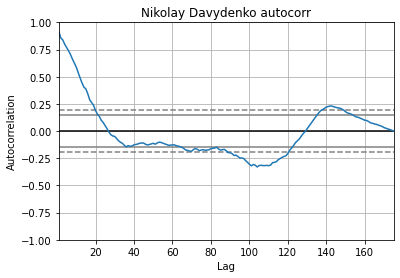

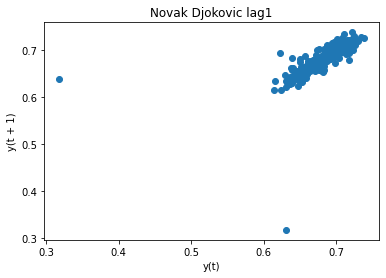

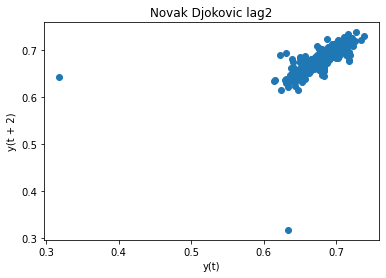

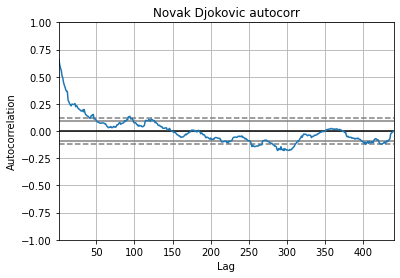

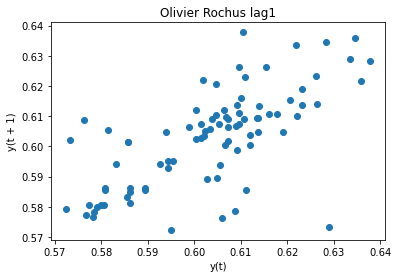

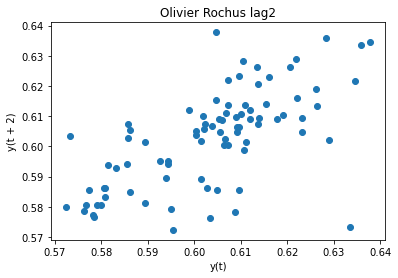

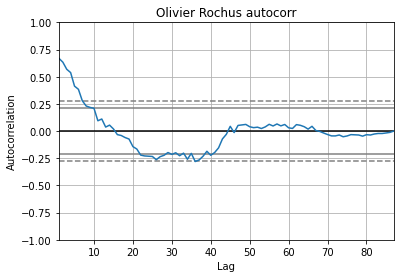

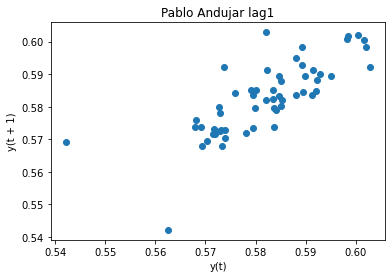

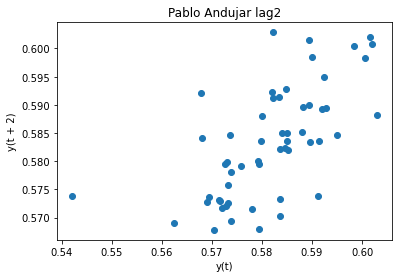

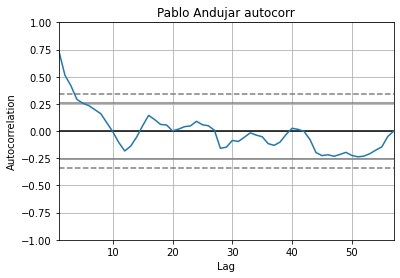

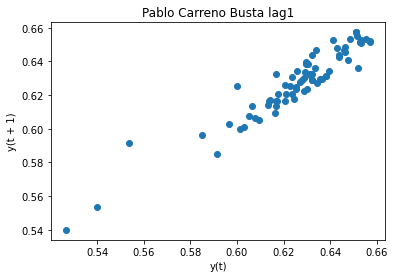

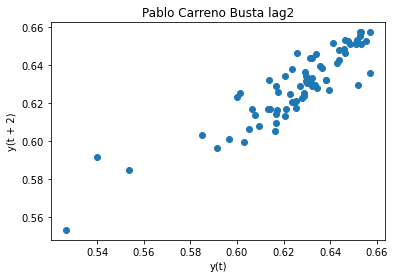

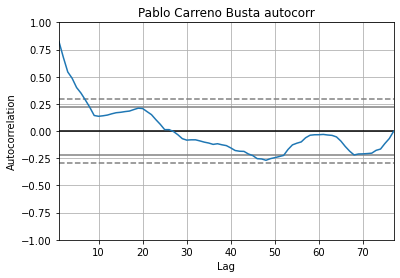

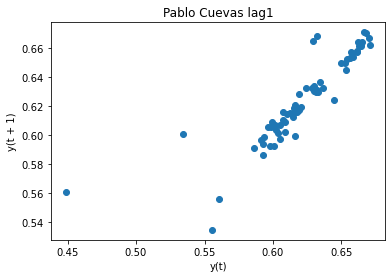

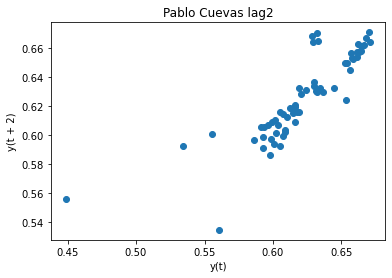

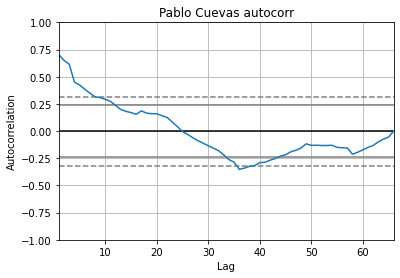

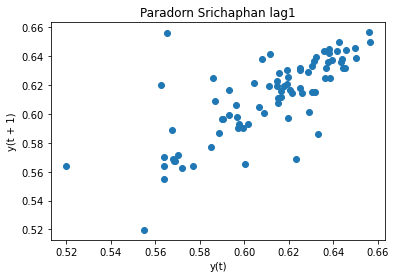

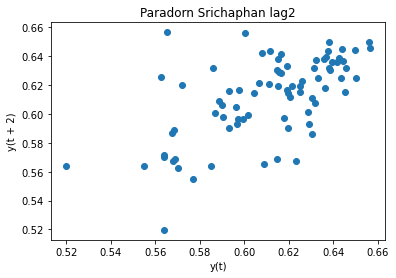

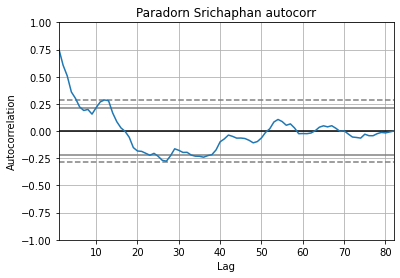

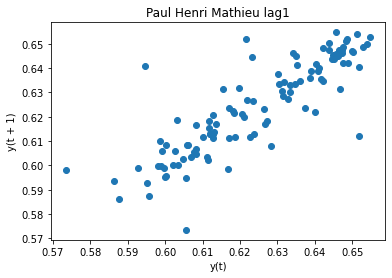

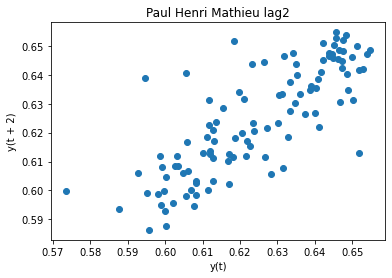

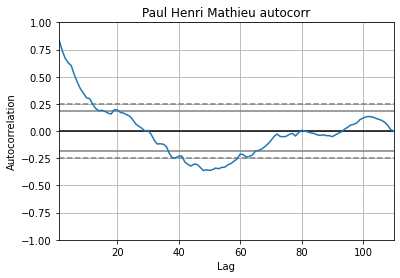

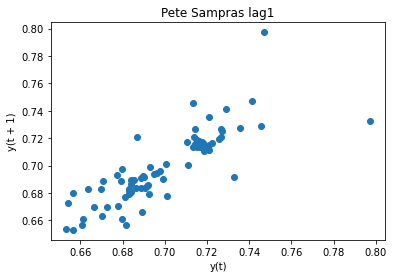

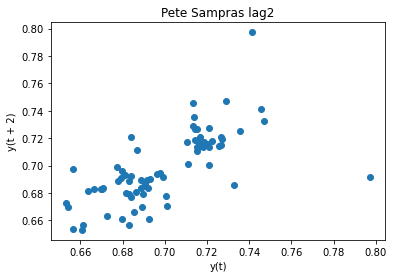

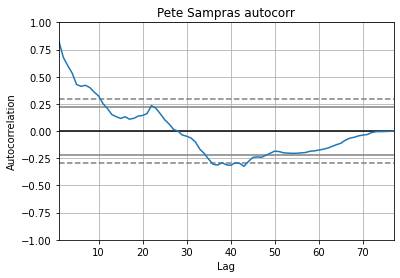

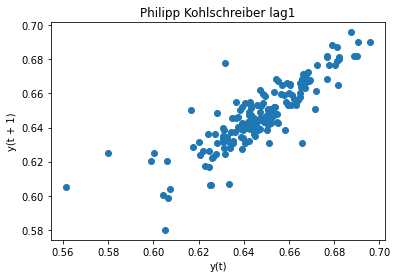

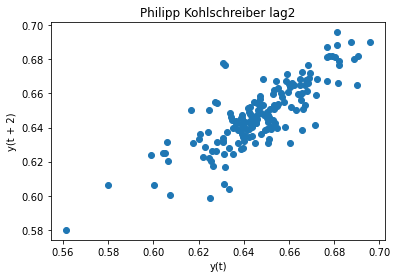

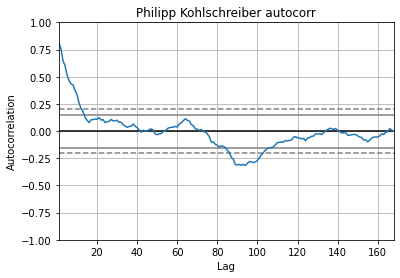

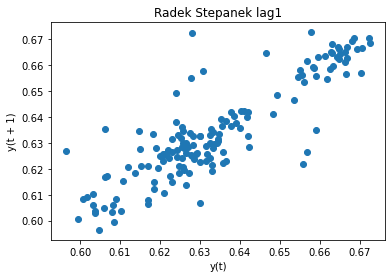

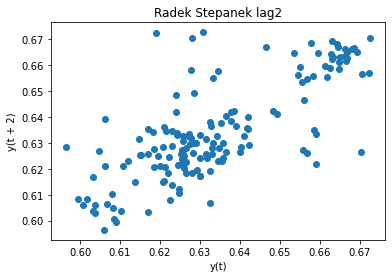

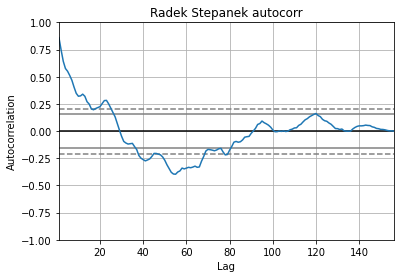

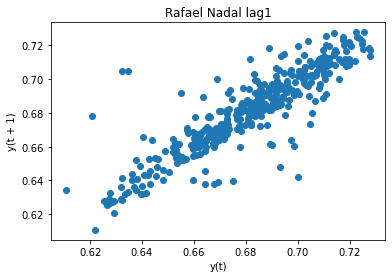

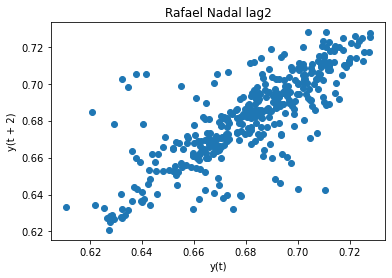

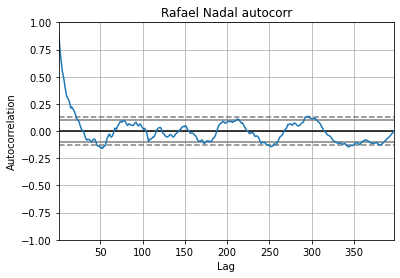

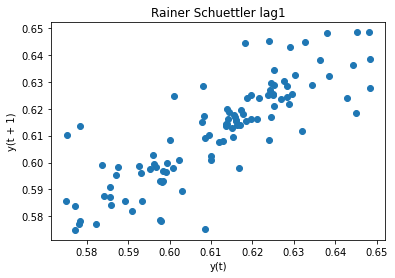

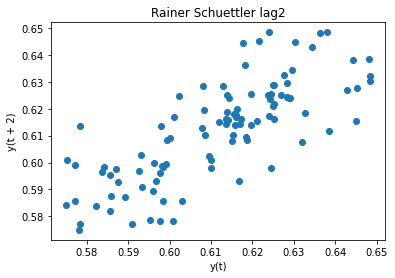

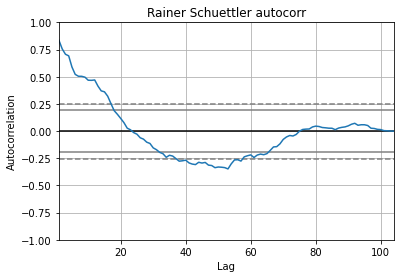

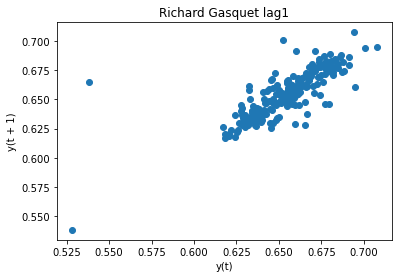

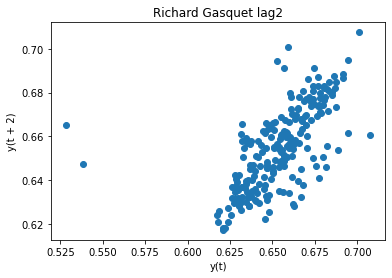

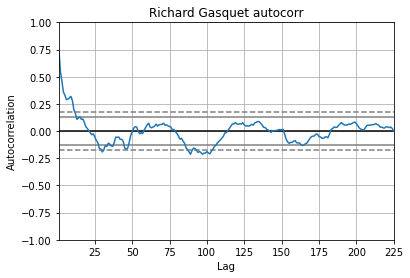

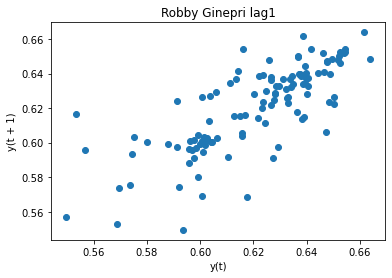

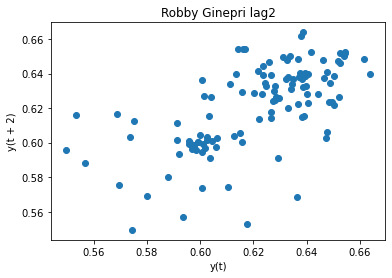

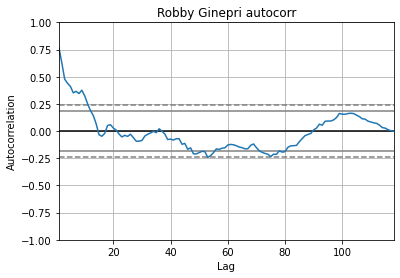

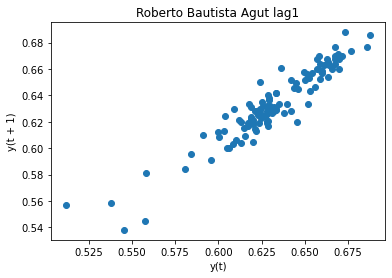

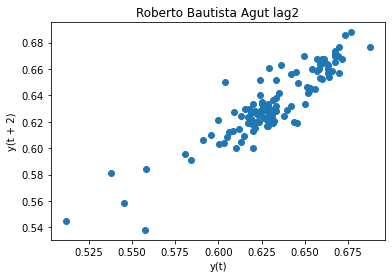

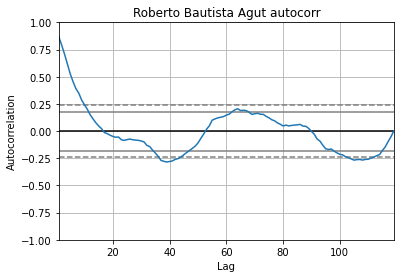

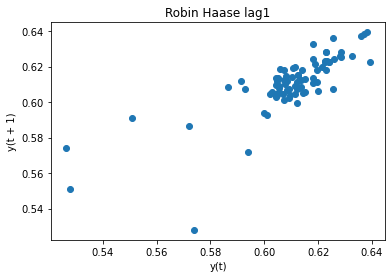

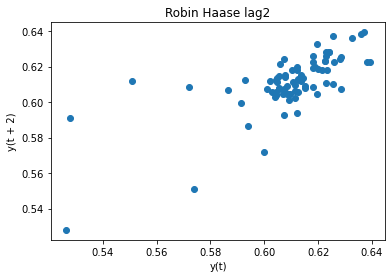

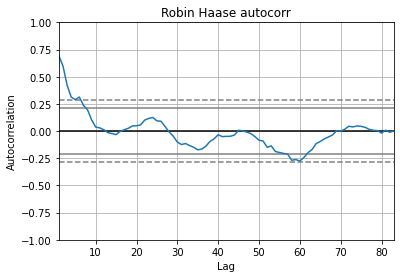

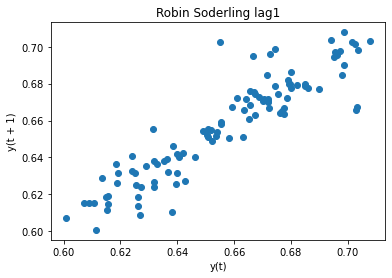

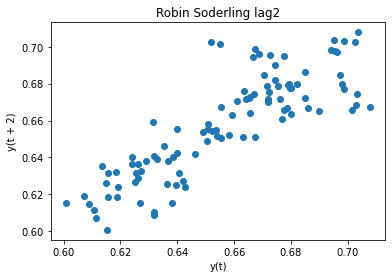

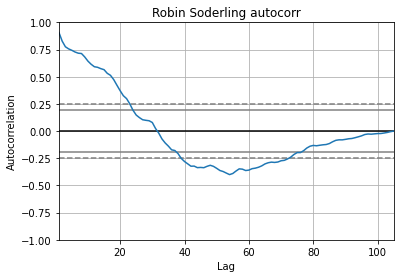

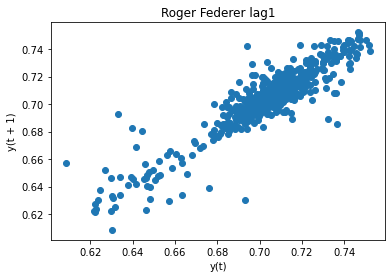

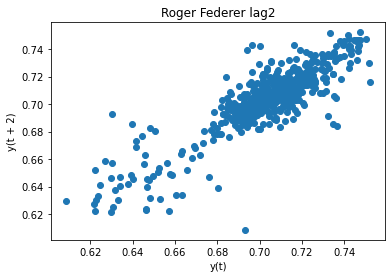

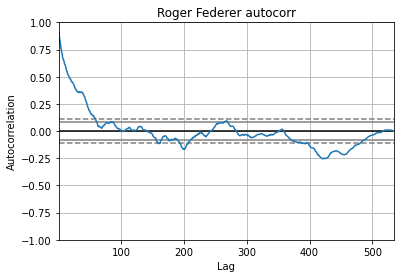

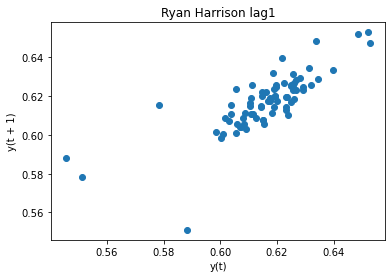

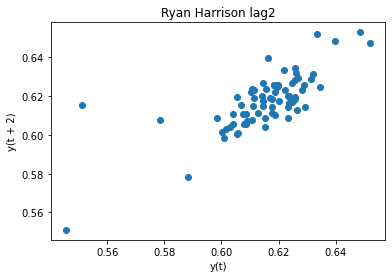

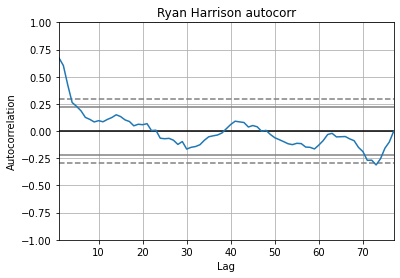

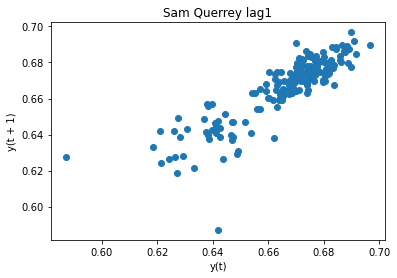

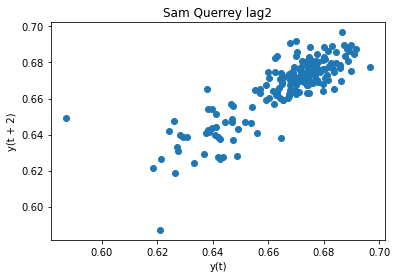

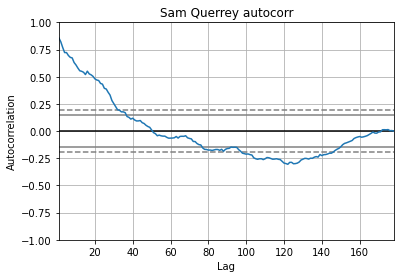

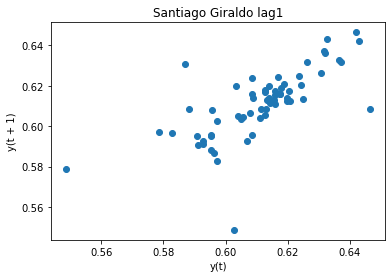

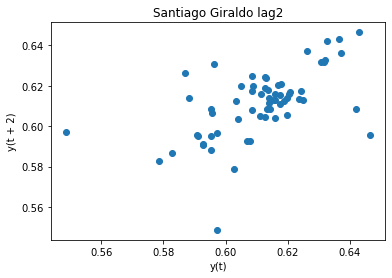

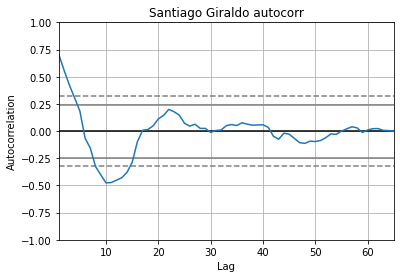

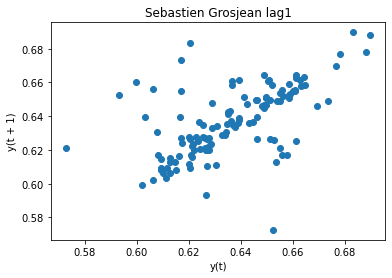

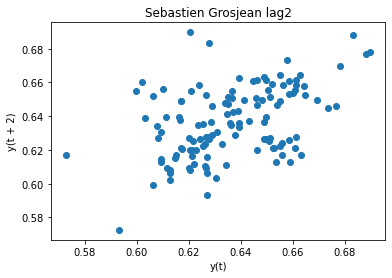

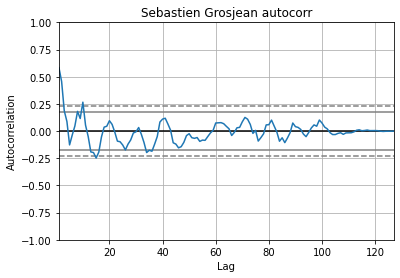

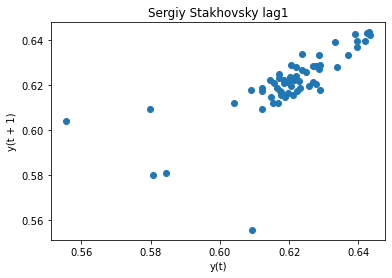

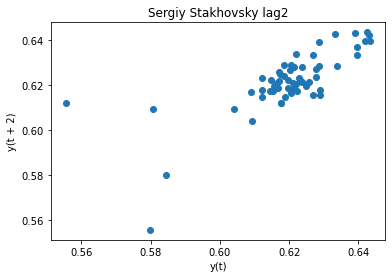

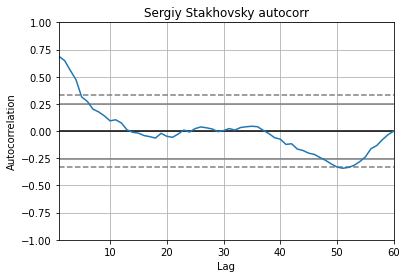

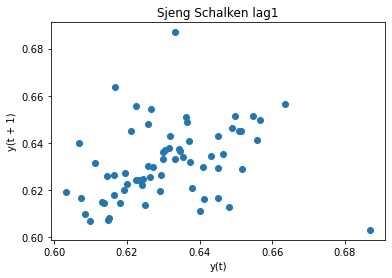

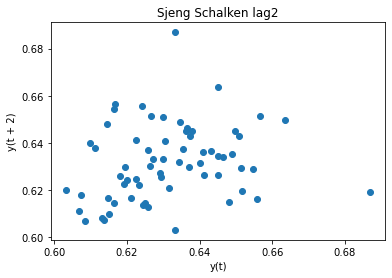

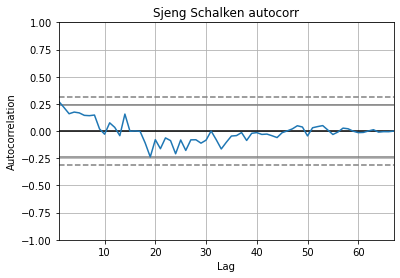

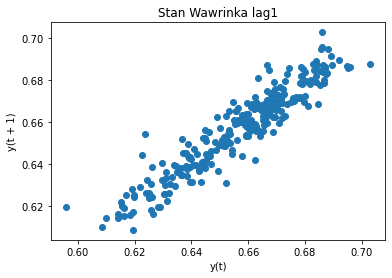

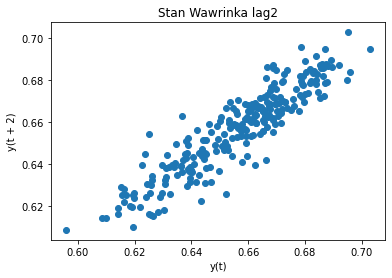

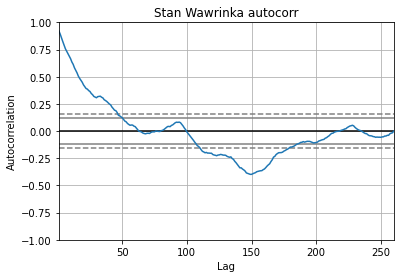

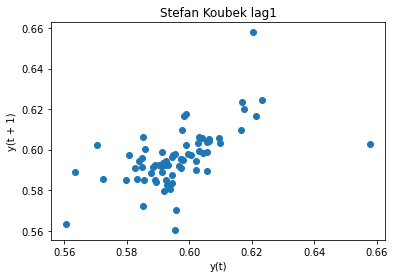

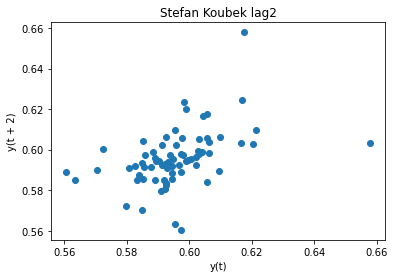

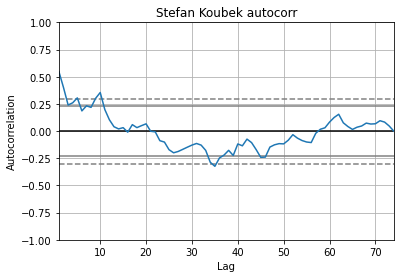

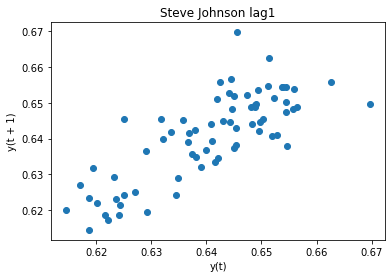

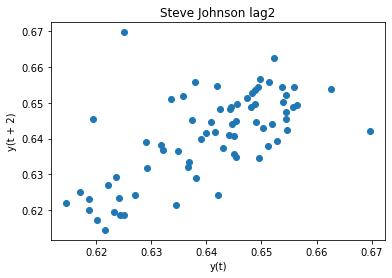

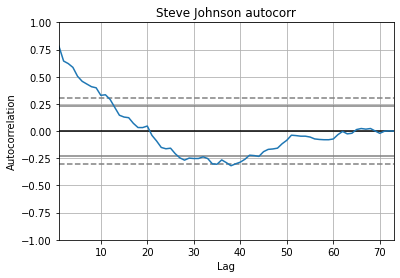

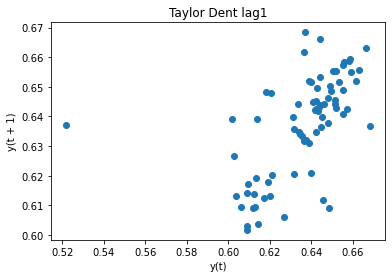

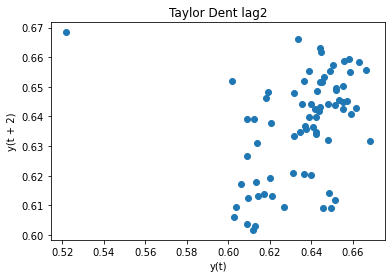

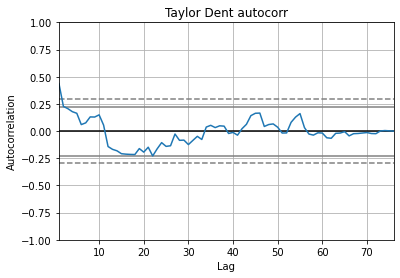

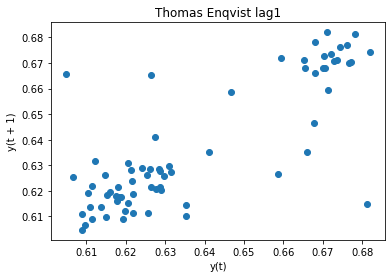

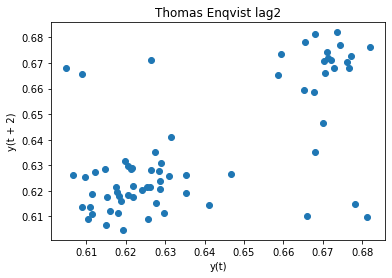

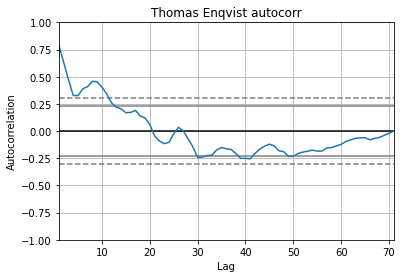

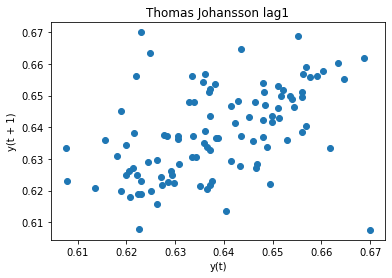

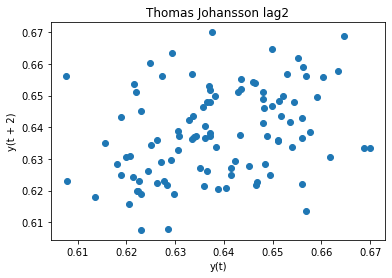

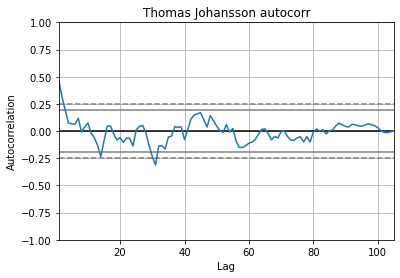

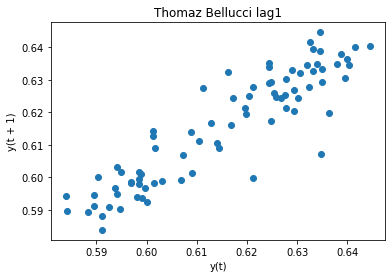

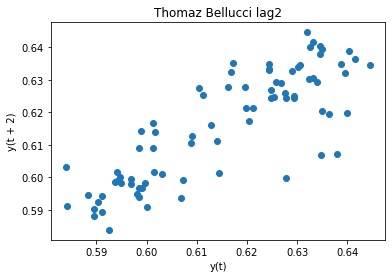

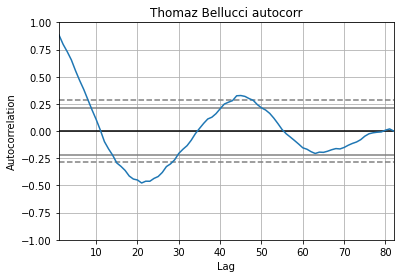

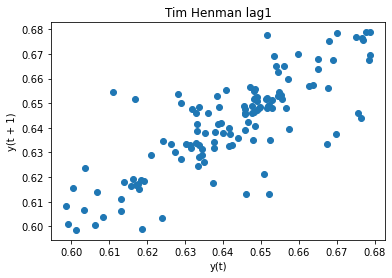

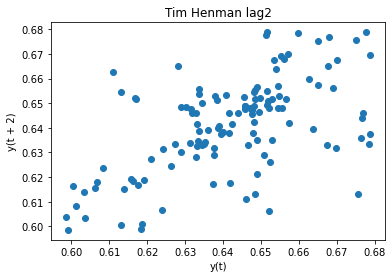

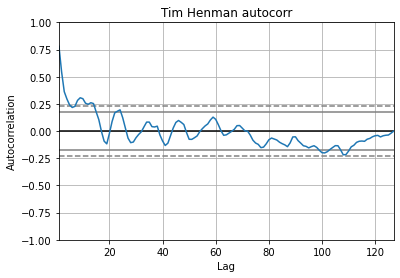

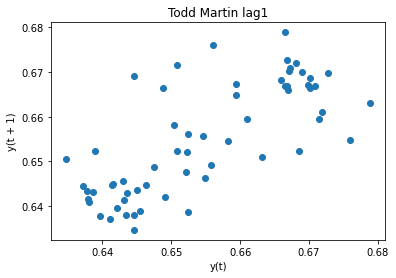

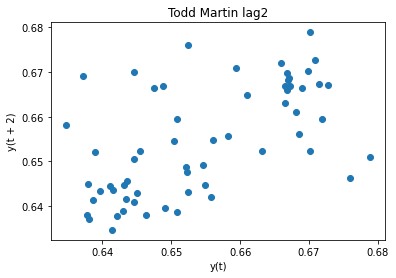

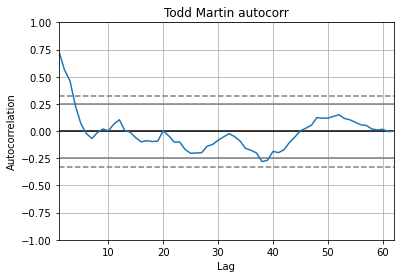

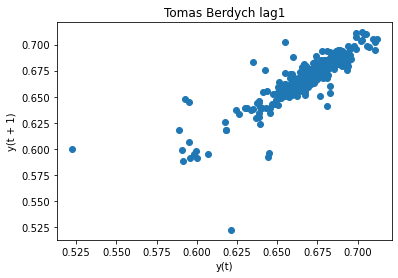

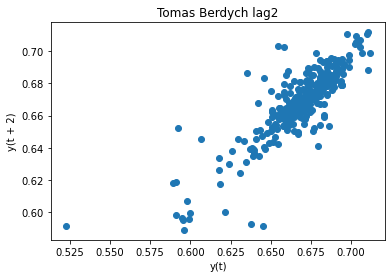

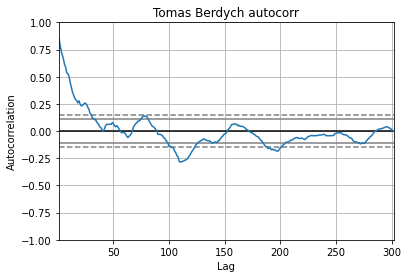

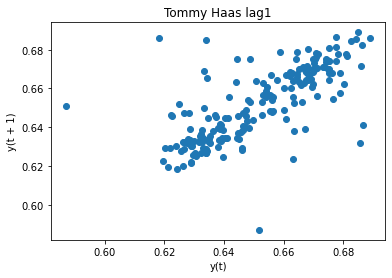

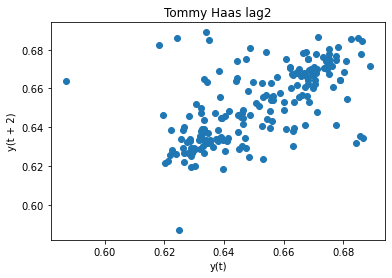

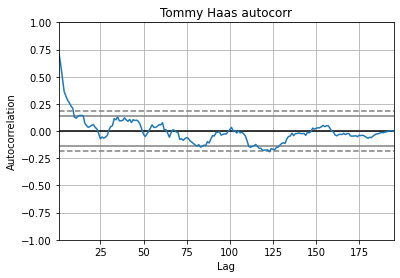

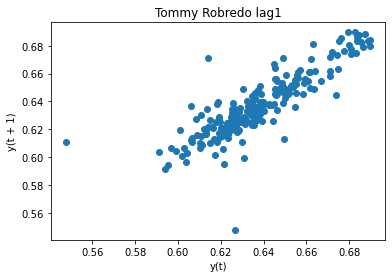

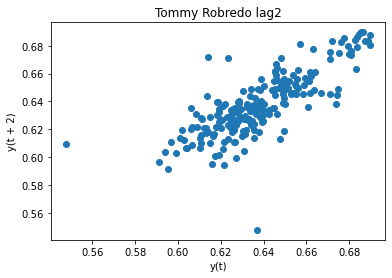

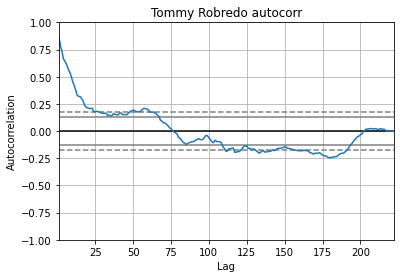

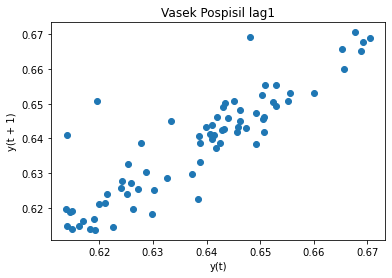

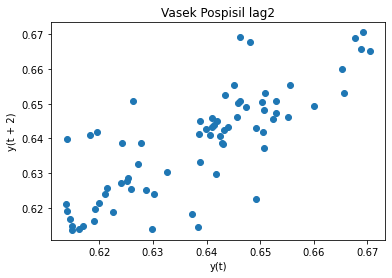

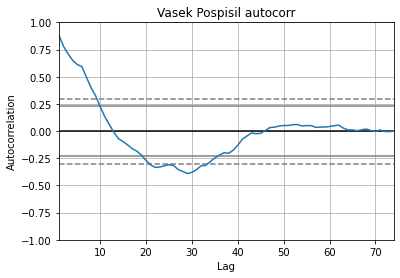

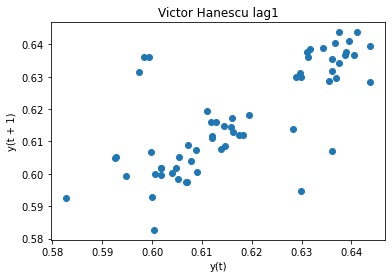

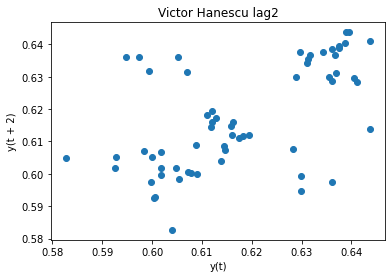

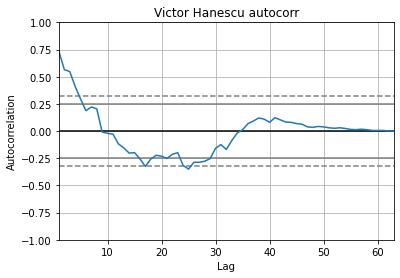

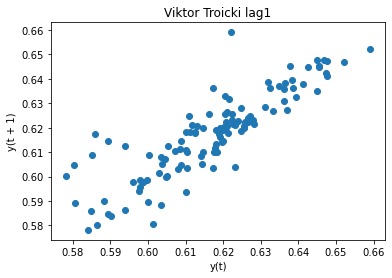

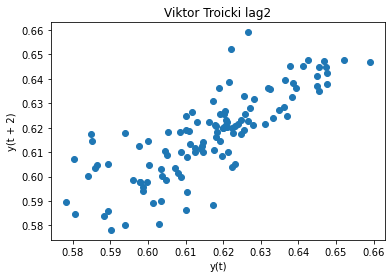

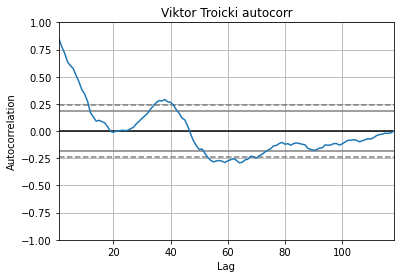

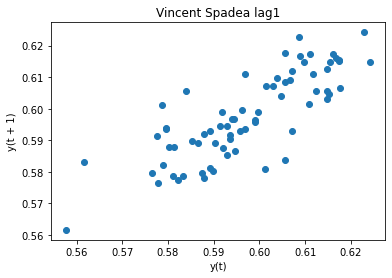

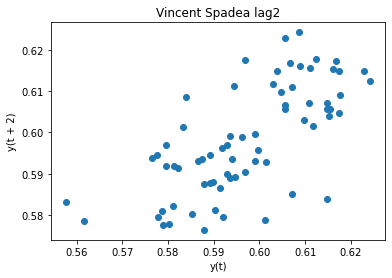

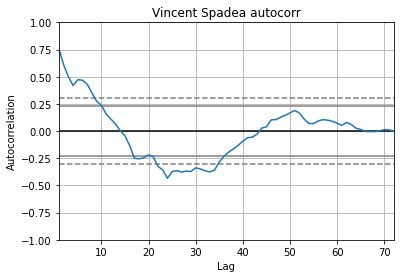

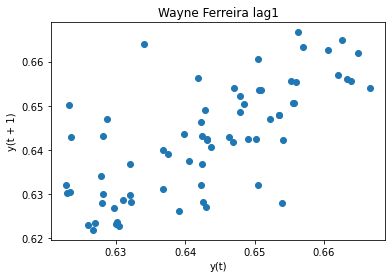

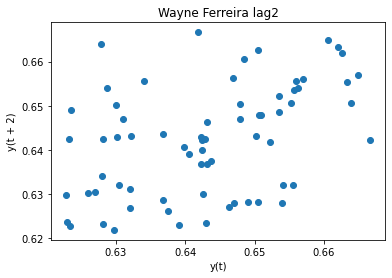

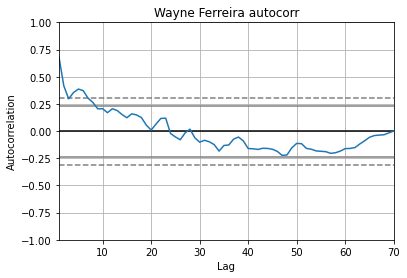

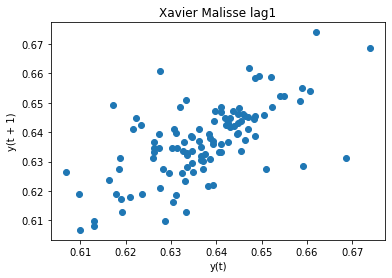

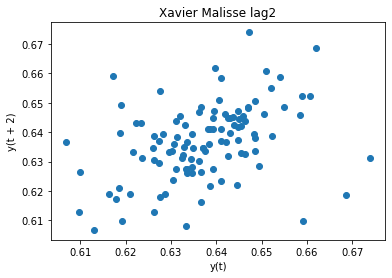

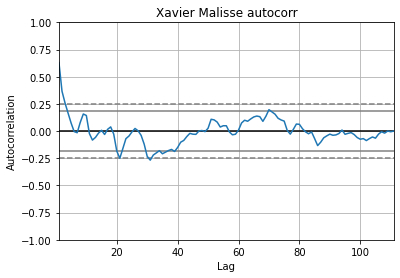

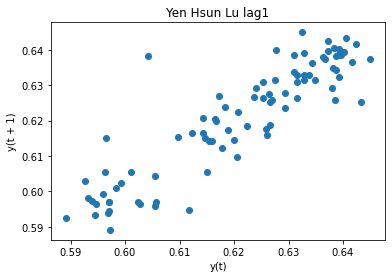

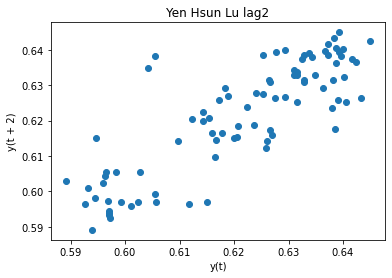

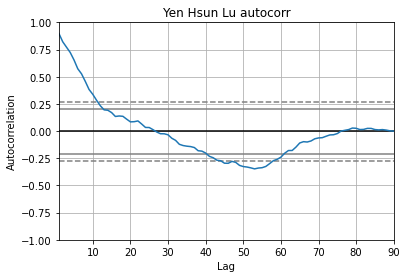

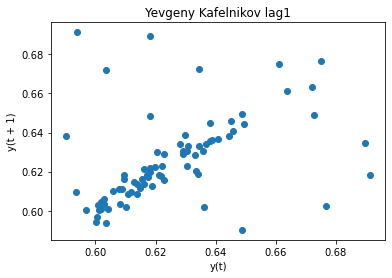

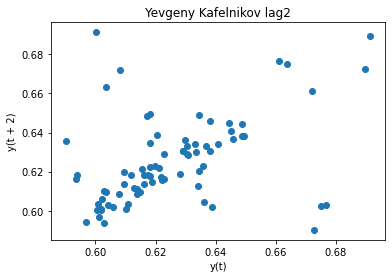

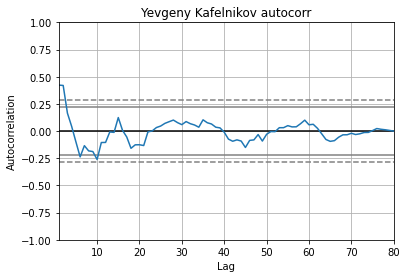

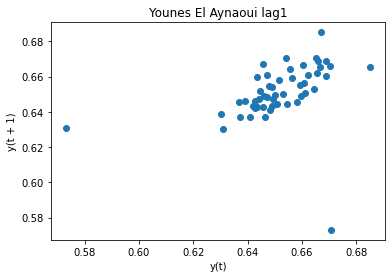

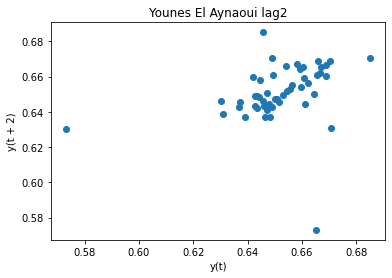

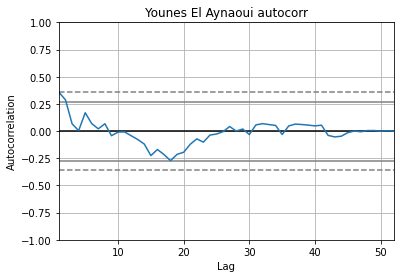

In [136]:
#get all the autocorrelations but also do some plotting
def ts_ac(df):
    all_ts=[]
    players=np.unique(df[["name_p1", "name_p2"]].values)
    surfaces=np.unique(df["surface"])
    autocorrs=[]
    #print(players.shape)
    for player in players:
        p1_df=df.loc[(df["name_p1"]==player)&(df["surface"]=="Hard"), df.columns.str.endswith("p1")].reset_index()
        p2_df=df.loc[(df["name_p2"]==player)&(df["surface"]=="Hard"), df.columns.str.endswith("p2")].reset_index()
        p_params=["index"]+["_".join(x.split("_")[:-1]) for x in list(p1_df.columns) if x!="index"]
        p1_df.columns=p_params
        p2_df.columns=p_params
        #print("params: ", p_params)
        #print("p1_df: ", p1_df.columns.tolist())
        p_df=pd.concat([p1_df, p2_df]).sort_values("index").drop("index", axis=1)
        #print(p_df)
        #p_df.columns=p_params
        #p_df.drop(["name_p1", "name_p2", "ht_p1", "ht_p2"], axis=1, inplace=True)
        p_df.drop(["name", "ht"], axis=1, inplace=True)
        #less than 50 matches
        #lower this later, just to speed up run times right now
        if p_df.shape[0]<50:
            continue
     
        ac1=p_df.select_dtypes(include=np.number).apply(lambda col: col.autocorr(lag=1)).to_frame()
        #print(ac1)
        ac2=p_df.select_dtypes(include=np.number).apply(lambda col: col.autocorr(lag=2)).to_frame()
        #ac2.columns=[col+"_lag2" for col in ac1.columns.tolist()]
        ac=pd.concat([ac1, ac2], axis=1)
        ac.columns=["lag1", "lag2"]
        ac["name"]=player
        #ac2["name"]=player
        #print(ac)
        autocorrs.append(ac)

        #print(p_df.shape)
        #print(p_df.columns)
        p_ts=to_time_series(p_df)
        all_ts.append(p_ts)
        
        
        pd.plotting.lag_plot(p_df["srvwon_perc"])
        plt.title(player+" lag1")
        plt.show()
        
        pd.plotting.lag_plot(p_df["srvwon_perc"], lag=2)
        plt.title(player+" lag2")
        plt.show()
        
        pd.plotting.autocorrelation_plot(p_df["srvwon_perc"])
        plt.title(player+" autocorr")
        plt.show()
    ts=to_time_series_dataset(all_ts)
    return ts, autocorrs

ts, autocorrs=ts_ac(sm_perc)

In [ ]:
all_acs=pd.concat(autocorrs)
all_acs
#all_acs.mean()
#all_acs.std()

ValueError: x and y can be no greater than 2-D, but have shapes (212,) and (212, 878, 22)

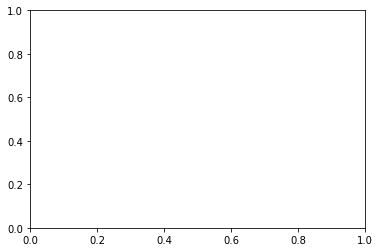

In [105]:
scaled_ts=TimeSeriesScalerMeanVariance().fit_transform(ts)

plt.plot(scaled_ts)

In [ ]:
print(scaled_ts.shape[0]*scaled_ts.shape[2])

In [ ]:
start=time.time()
#print("starting km")
num_clusters=5
km=TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw", verbose=10, random_state=RANDOM_STATE, n_jobs=-1)
#print("done with km: ", time.time()-start)
km_pred=km.fit_predict(scaled_ts)
km_pred

In [ ]:
sz=ts.shape[1]
plt.figure(figsize=(20,10))
for yi in range(num_clusters):
    plt.subplot(3, 3, 4 + yi)
    for xx in ts[km_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.1, 0.1,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

## PCA Regression

In [38]:
#need to scale data before running pca
#pca is units dependent
pca_scaler=StandardScaler()


#don't want these in the pca
drop_cols=["Win", "name_p1", "name_p2", "surface", "Date", "h2h_name_p1", "h2h_name_p2"]
#drop_cols=normal_drop_cols+h2h_diff_cols
sm_drop=sm_diff.drop(drop_cols, axis=1)

#transform the data with the scaler
scaled_sm_drop=pca_scaler.fit_transform(sm_drop)

#get the components that explain "prop_explained" of the variance
prop_explained=0.9
pca=PCA(prop_explained)
#transform the data to the diagonalized feature space
pca_trans=pca.fit_transform(scaled_sm_drop)

#each row transformed to the principal component eigenspace
pd.DataFrame(data=pca_trans)


0         1         2         3         4         5         6  \
0      0.775620  1.008817  3.228675  0.167329 -1.703777 -0.640143  0.324975   
1     -0.025579  0.510201  0.556212 -0.239591 -2.580758  0.082507  0.312740   
2      0.295243 -0.065751  0.518982  0.104407  0.336312  0.034656 -0.069125   
3      2.548546 -3.256728 -0.219301 -0.220174 -2.358345 -0.241249 -0.130937   
4     -0.724679  2.317038  2.284704 -0.009976 -2.152107 -0.819793  0.902051   
...         ...       ...       ...       ...       ...       ...       ...   
20479 -2.621610  1.660223 -2.956968 -0.403638 -0.388438  0.427288  1.051135   
20480 -3.875647 -5.615250 -2.542889 -1.779082 -0.656286  0.628306  0.622104   
20481  3.454863  1.945132 -0.031688  2.420729 -2.158811 -2.628460  0.194350   
20482 -0.778232  0.307388  0.143292  1.142415  1.044045 -2.353780 -0.376992   
20483  1.973751 -0.472039  1.248583  1.942036 -1.582696  0.669607 -0.616981   

              7         8         9        10        11        12        13  \
0     -0.930048  0.752191 -0.049306  1.282837 -0.117180  0.375645  0.044457   
1     -0.366228  0.429395 -0.251688  0.204141  0.145012  0.297948  0.335317   
2      0.069546  0.023368 -0.103702 -0.159903  0.063931  0.803967  0.675611   
3      0.033487  1.670455 -2.152522 -0.629779  1.382735 -1.603095  0.496726   
4     -1.812546  0.751354  0.316608  1.729896  0.161752  1.228665  1.046067   
...         ...       ...       ...       ...       ...       ...       ...   
20479 -1.786881 -0.560146  1.141271  0.400549  0.593314  0.613623 -0.666879   
20480 -1.433190  0.754625 -0.571615  1.839182 -3.231570  0.078059  0.656527   
20481  0.463907  0.326340 -0.333692  1.803475  1.742581  3.190157  0.385972   
20482  1.116779  1.470920 -0.612797  0.325949  0.433437  1.735628 -1.444015   
20483  1.103165 -1.957579 -1.296272 -1.221037 -1.745075 -1.441034  0.995441   

             14  
0      0.029832  
1      0.091541  
2      0.622248  
3      1.128460  
4      0.745879  
...         ...  
20479 -0.487697  
20480 -0.728067  
20481  0.726508  
20482  1.460815  
20483 -0.014600  

[20484 rows x 15 columns]

In [39]:
#each component as a linear combination of the original features
pd.DataFrame(data=pca.components_.T, index=sm_drop.columns)

0         1         2         3         4  \
1steff_diff                -0.013678 -0.090949 -0.238349 -0.026800 -0.021090   
h2h_1steff_diff            -0.065959 -0.121685 -0.066307  0.001573 -0.000412   
1stsrv_perc_diff            0.061738 -0.001547  0.150940  0.016296 -0.037932   
h2h_1stsrv_perc_diff        0.077661  0.084338  0.056090 -0.005219 -0.014783   
1stwin_perc_diff            0.173811 -0.283959 -0.105279 -0.005060  0.012691   
h2h_1stwin_perc_diff        0.231286  0.135648 -0.169486 -0.007661  0.013865   
2ndsrv_perc_diff            0.090709 -0.032357  0.181180  0.021217 -0.033958   
h2h_2ndsrv_perc_diff        0.095819  0.085818 -0.034641  0.008059 -0.025589   
2ndwin_perc_diff            0.170640 -0.151204  0.152691  0.023534  0.033258   
h2h_2ndwin_perc_diff        0.204074  0.198494 -0.036811 -0.005580  0.010089   
ace_perc_diff               0.102011 -0.274521 -0.239096 -0.021041  0.005234   
h2h_ace_perc_diff           0.130651 -0.028586 -0.217475 -0.024926  0.020806   
age_diff                    0.030065 -0.029363  0.022864 -0.008829 -0.092689   
h2h_age_diff                0.030065 -0.029363  0.022864 -0.008829 -0.092689   
bp_conv_perc_diff           0.053295  0.050907  0.209355  0.024589  0.017822   
h2h_bp_conv_perc_diff       0.135531  0.099668 -0.061475 -0.002580  0.001212   
bp_per_retgame_diff         0.101762  0.084371  0.332638  0.036756  0.024825   
h2h_bp_per_retgame_diff     0.230108  0.177677 -0.108840 -0.000303  0.010055   
bp_per_svgame_diff         -0.204211  0.248463 -0.047522 -0.010927  0.007573   
h2h_bp_per_svgame_diff     -0.233095 -0.178048  0.108285  0.011677 -0.011025   
bp_save_perc_diff           0.137387 -0.171241  0.025370  0.009356  0.012814   
h2h_bp_save_perc_diff       0.073863  0.050348 -0.009838  0.018250 -0.002868   
df_perc_diff               -0.104200  0.031274 -0.218582 -0.026496  0.042160   
h2h_df_perc_diff           -0.114334 -0.107423  0.020291 -0.008072  0.027267   
expected_retwin_diff       -0.232175  0.255578 -0.106872 -0.018876  0.008312   
h2h_expected_retwin_diff   -0.266914 -0.205724  0.115983  0.004257 -0.001989   
expected_srvwin_diff        0.232175 -0.255578  0.106872  0.018876 -0.008312   
h2h_expected_srvwin_diff    0.266914  0.205724 -0.115983 -0.004257  0.001989   
gameswon_perc_diff         -0.000959 -0.011512  0.003835  0.067152  0.585759   
h2h_gameswon_perc_diff     -0.008485  0.004134 -0.053356  0.504875 -0.057491   
ht_diff                     0.053759 -0.185867 -0.227773 -0.022036  0.009813   
h2h_ht_diff                 0.016406 -0.096985 -0.148509 -0.017607  0.023905   
rank_log_diff              -0.023061  0.018685 -0.055401  0.000579 -0.030542   
h2h_rank_log_diff          -0.210771  0.085923 -0.226596 -0.024216  0.012161   
rank_points_log_diff       -0.004355  0.010890 -0.034834  0.002789 -0.031492   
h2h_rank_points_log_diff    0.203035 -0.088320  0.233949  0.024525 -0.004417   
retgames_won_perc_diff     -0.071611  0.214064  0.179115  0.057615  0.389105   
h2h_retgames_won_perc_diff -0.008245  0.004176 -0.053055  0.500492 -0.057371   
retwon_perc_diff            0.115092  0.088184  0.368113  0.041636  0.032959   
h2h_retwon_perc_diff        0.266737  0.200903 -0.123039 -0.006657  0.008812   
setswon_perc_diff          -0.006036 -0.007399 -0.003372  0.066280  0.563444   
h2h_setswon_perc_diff      -0.008671  0.003580 -0.048318  0.472102 -0.051383   
srvgames_won_perc_diff      0.054634 -0.214585 -0.178048  0.028678  0.379902   
h2h_srvgames_won_perc_diff -0.023887 -0.003417 -0.046157  0.497141 -0.057050   
srvwon_perc_diff            0.226971 -0.278684  0.045506  0.012224  0.005156   
h2h_srvwon_perc_diff        0.266737  0.200903 -0.123039 -0.006657  0.008812   

                                   5         6         7         8         9  \
1steff_diff                -0.070582  0.066096 -0.151772  0.276480 -0.301843   
h2h_1steff_diff            -0.030024  0.035674 -0.105820  0.223566 -0.170367   
1stsrv_perc_diff           -0.1146

In [40]:
#Percentage of total variance that is explained by each component
pd.DataFrame(pca.explained_variance_ratio_)

0
0   0.204968
1   0.130595
2   0.085179
3   0.082553
4   0.059555
5   0.050424
6   0.043946
7   0.043226
8   0.040268
9   0.037619
10  0.032657
11  0.030761
12  0.024919
13  0.020403
14  0.019637

Text(0, 0.5, 'cumulative explained variance')

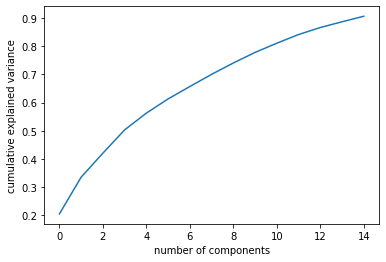

In [41]:
#scree plot, plots explained variance as a function of number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [42]:
#test train split for the pca transformed data
pca_x_train, pca_x_test, pca_y_train, pca_y_test=train_test_split(pca_trans, 
                                                  sm_diff["Win"], 
                                                  test_size=0.3,
                                                  random_state=RANDOM_STATE)

In [43]:
#logistic regression with pca training data
pca_clf=LogisticRegressionCV(cv=5, random_state=RANDOM_STATE,
                         max_iter=4000,Cs=[1,10,100,1000])\
                        .fit(pca_x_train, pca_y_train)

In [44]:
#predict and score pca logistic
pca_y_pred=pca_clf.predict(pca_x_test)
pca_probs=pca_clf.predict_proba(pca_x_test)[:,1]
#pca_coef_df=coefficient_df(x_train, clf)
#print(pca_coef_df.head(50))
pca_score=pca_clf.score(pca_x_test, pca_y_test)
pca_auc=roc_auc_score(pca_y_test, pca_probs)
pca_f1=f1_score(pca_y_test, pca_y_pred)
print(pca_score)

0.7354376830458835


In [45]:
confusion_matrix(pca_y_test, pca_y_pred)

array([[2346,  790],
       [ 836, 2174]], dtype=int64)

# Model Training

### Test Train Split

In [46]:
#test train split
x_train, x_test, y_train, y_test=train_test_split(sm_diff.drop(drop_cols, axis=1), 
                                                  sm_diff["Win"], 
                                                  test_size=0.3,
                                                  random_state=RANDOM_STATE)

In [47]:
x_train.corr()

1steff_diff  h2h_1steff_diff  1stsrv_perc_diff  \
1steff_diff                    1.000000         0.130411         -0.304069   
h2h_1steff_diff                0.130411         1.000000         -0.069633   
1stsrv_perc_diff              -0.304069        -0.069633          1.000000   
h2h_1stsrv_perc_diff          -0.155118        -0.145429          0.313196   
1stwin_perc_diff               0.445948         0.081729         -0.205296   
h2h_1stwin_perc_diff           0.039302         0.133146         -0.001846   
2ndsrv_perc_diff               0.030828        -0.012852          0.039213   
h2h_2ndsrv_perc_diff           0.024213        -0.035058         -0.003712   
2ndwin_perc_diff              -0.611750        -0.074017          0.162515   
h2h_2ndwin_perc_diff          -0.107610        -0.722979          0.073977   
ace_perc_diff                  0.415571         0.145102         -0.136247   
h2h_ace_perc_diff              0.154788         0.182009         -0.034827   
age_diff                       0.010353        -0.000753          0.059366   
h2h_age_diff                   0.010353        -0.000753          0.059366   
bp_conv_perc_diff             -0.157471        -0.069170          0.040169   
h2h_bp_conv_perc_diff         -0.022371        -0.134920          0.052202   
bp_per_retgame_diff           -0.228630        -0.131130          0.116370   
h2h_bp_per_retgame_diff       -0.041450        -0.217033          0.070695   
bp_per_svgame_diff            -0.033859        -0.011991         -0.121368   
h2h_bp_per_svgame_diff         0.041092         0.215343         -0.071515   
bp_save_perc_diff              0.017146         0.005040          0.120365   
h2h_bp_save_perc_diff         -0.027324        -0.074237          0.043294   
df_perc_diff                   0.067566         0.033495         -0.365753   
h2h_df_perc_diff               0.020705         0.078443         -0.082957   
expected_retwin_diff          -0.013321        -0.004095         -0.255404   
h2h_expected_retwin_diff       0.044353         0.260651         -0.090484   
expected_srvwin_diff           0.013321         0.004095          0.255404   
h2h_expected_srvwin_diff      -0.044353        -0.260651          0.090484   
gameswon_perc_diff            -0.006803         0.007347         -0.040270   
h2h_gameswon_perc_diff         0.000852         0.001982          0.005736   
ht_diff                        0.296553         0.115434          0.033565   
h2h_ht_diff                    0.137130         0.142604          0.017153   
rank_log_diff                  0.047288         0.012704         -0.023874   
h2h_rank_log_diff              0.085900         0.088114         -0.160438   
rank_points_log_diff           0.039917         0.005360         -0.010387   
h2h_rank_points_log_diff      -0.091900        -0.083684          0.155585   
retgames_won_perc_diff        -0.167059        -0.083122         -0.038045   
h2h_retgames_won_perc_diff     0.003039         0.003173          0.005523   
retwon_perc_diff              -0.250386        -0.142638          0.113817   
h2h_retwon_perc_diff          -0.043887        -0.268318          0.079740   
setswon_perc_diff             -0.014655         0.002808         -0.029715   
h2h_setswon_perc_diff         -0.010441        -0.006221          0.005284   
srvgames_won_perc_diff         0.160942         0.094918         -0.029594   
h2h_srvgames_won_perc_diff     0.003721         0.011651         -0.000429   
srvwon_perc_diff               0.038466         0.016227          0.162768   
h2h_srvwon_perc_diff          -0.043887        -0.268318          0.079740   

                            h2h_1stsrv_perc_diff  1stwin_perc_diff  \
1steff_diff                            -0.155118          0.445948   
h2h_1steff_diff                        -0.145429          0.081729   
1stsrv_perc_diff                        0.313196         -0.205296   
h2h_1stsrv_perc_diff                    1.000000         -0.087341   
1stwin_perc

### Scaling 

In [48]:
#scale the data
scaler=StandardScaler()

#fit to train data, but apply the same transformation to the test data
x_train_norm=scaler.fit_transform(x_train)
x_test_norm=scaler.transform(x_test)

## Logistic Regression

In [49]:
#returns df with features and their coefficients as columns
def coefficient_df(x_train, clf):
    return pd.DataFrame({"Feature":x_train.columns.tolist(),"Coefficients":clf.coef_[0]})

In [50]:
#logistic regression, l2 penalty (ridge regression)
clf=LogisticRegressionCV(cv=5, random_state=RANDOM_STATE,
                         max_iter=4000,Cs=[1,10,100,1000])\
                        .fit(x_train_norm, y_train)

In [51]:
#predict and score
y_pred=clf.predict(x_test_norm)
y_probs=clf.predict_proba(x_test_norm)[:,1]
coef_df=coefficient_df(x_train, clf)
print(coef_df.head(50))
l2_score=clf.score(x_test_norm, y_test)
l2_auc=roc_auc_score(y_test, y_probs)
l2_f1=f1_score(y_test, y_pred)
print(l2_score)

                       Feature  Coefficients
0                  1steff_diff     -0.285179
1              h2h_1steff_diff     -0.064386
2             1stsrv_perc_diff      0.036529
3         h2h_1stsrv_perc_diff     -0.058850
4             1stwin_perc_diff      0.064895
5         h2h_1stwin_perc_diff     -0.208378
6             2ndsrv_perc_diff      0.155760
7         h2h_2ndsrv_perc_diff      0.027389
8             2ndwin_perc_diff     -0.244033
9         h2h_2ndwin_perc_diff     -0.223821
10               ace_perc_diff      0.028107
11           h2h_ace_perc_diff      0.025730
12                    age_diff     -0.070775
13                h2h_age_diff     -0.070775
14           bp_conv_perc_diff      0.173051
15       h2h_bp_conv_perc_diff      0.045602
16         bp_per_retgame_diff      0.139713
17     h2h_bp_per_retgame_diff     -0.591956
18          bp_per_svgame_diff     -0.636688
19      h2h_bp_per_svgame_diff     -0.672115
20           bp_save_perc_diff      0.455062
21       h

In [52]:
confusion_matrix(y_test, y_pred)

array([[2356,  780],
       [ 829, 2181]], dtype=int64)

### "Lasso" (L1 penalty) Logistic

In [53]:
#logistic regression, but l1 penalty (like lasso, will take some coefficients to 0)
clf_l1=LogisticRegression(penalty="l1", solver="liblinear", random_state=RANDOM_STATE)\
                        .fit(x_train_norm, y_train)

In [122]:
#predict and score
y_pred_l1=clf_l1.predict(x_test_norm)
y_prob_l1=clf_l1.predict_proba(x_test_norm)[:,1]
coef_df_l1=coefficient_df(x_test, clf_l1)
print(coef_df_l1.head(50))
l1_score=clf_l1.score(x_test_norm, y_test)
l1_auc=roc_auc_score(y_test, y_prob_l1)
l1_f1=f1_score(y_test, y_pred_l1)
print(l1_score, l1_auc)

                       Feature  Coefficients
0                  1steff_diff     -0.191049
1              h2h_1steff_diff     -0.062050
2             1stsrv_perc_diff      0.022620
3         h2h_1stsrv_perc_diff     -0.052359
4             1stwin_perc_diff      0.000064
5         h2h_1stwin_perc_diff     -0.153793
6             2ndsrv_perc_diff      0.111711
7         h2h_2ndsrv_perc_diff      0.017799
8             2ndwin_perc_diff     -0.151461
9         h2h_2ndwin_perc_diff     -0.184845
10               ace_perc_diff      0.028576
11           h2h_ace_perc_diff      0.024161
12                    age_diff     -0.056910
13                h2h_age_diff     -0.083372
14           bp_conv_perc_diff      0.169663
15       h2h_bp_conv_perc_diff      0.042918
16         bp_per_retgame_diff      0.133989
17     h2h_bp_per_retgame_diff     -0.235623
18          bp_per_svgame_diff     -0.637513
19      h2h_bp_per_svgame_diff     -0.310873
20           bp_save_perc_diff      0.456139
21       h

In [123]:
confusion_matrix(y_test, y_pred_l1)

array([[2360,  776],
       [ 831, 2179]], dtype=int64)

##### Run CV again, with lasso selected columns

In [56]:
#only the coefficients that are non zero after lasso
sparse_index=np.where(clf_l1.coef_[0]!=0.)[0]
lasso_df=x_train_norm[:,sparse_index]
lasso_test=x_test_norm[:, sparse_index]


In [57]:
#only the lasso selected columns in a ridge logistic regression
clf_l1_CV=LogisticRegressionCV(cv=5, random_state=RANDOM_STATE,
                         max_iter=4000,Cs=[1,10,100,1000])\
                        .fit(lasso_df, y_train)


In [58]:
#predict and score
y_pred_l1_CV=clf_l1_CV.predict(lasso_test)
y_prob_l1_CV=clf_l1_CV.predict_proba(lasso_test)[:,1]
coef_df_l1_CV=coefficient_df(x_train.iloc[:,sparse_index], clf_l1_CV)
print(coef_df_l1_CV.head(50))
sparse_score=clf_l1_CV.score(lasso_test, y_test)
sparse_auc=roc_auc_score(y_test, y_prob_l1_CV)
sparse_f1=f1_score(y_test, y_pred_l1_CV)
print(sparse_score)

                       Feature  Coefficients
0                  1steff_diff     -0.298959
1              h2h_1steff_diff     -0.063844
2             1stsrv_perc_diff      0.033896
3         h2h_1stsrv_perc_diff     -0.060174
4             1stwin_perc_diff      0.048736
5         h2h_1stwin_perc_diff     -0.220773
6             2ndsrv_perc_diff      0.167522
7         h2h_2ndsrv_perc_diff      0.029121
8             2ndwin_perc_diff     -0.270210
9         h2h_2ndwin_perc_diff     -0.229777
10               ace_perc_diff      0.027578
11           h2h_ace_perc_diff      0.026403
12                    age_diff     -0.071017
13                h2h_age_diff     -0.071017
14           bp_conv_perc_diff      0.170479
15       h2h_bp_conv_perc_diff      0.048132
16         bp_per_retgame_diff      0.135721
17     h2h_bp_per_retgame_diff     -0.892782
18          bp_per_svgame_diff     -0.643597
19      h2h_bp_per_svgame_diff     -0.978131
20           bp_save_perc_diff      0.458809
21       h

In [59]:
confusion_matrix(y_test, y_pred_l1_CV)

array([[2353,  783],
       [ 830, 2180]], dtype=int64)

### FDR Model Selection

In [60]:
#use FDR to select the relevant features
FDR=SelectFdr(f_classif, alpha=0.05)
x_train_new=FDR.fit_transform(x_train_norm, y_train)
x_test_new=FDR.transform(x_test_norm)
print(x_train.shape, x_train_new.shape)

(14338, 46) (14338, 39)


In [61]:
#fit, predict with the FDR selected features
fdr_clf=LogisticRegressionCV(cv=5, random_state=RANDOM_STATE,
                         max_iter=4000,Cs=[1,10,100,1000])\
                        .fit(x_train_new, y_train)
fdr_pred=fdr_clf.predict(x_test_new)
fdr_prob=fdr_clf.predict_proba(x_test_new)[:,1]

print(fdr_pred)
print(fdr_prob)

[0 0 0 ... 0 0 0]
[0.46257433 0.08784922 0.21881066 ... 0.37128152 0.38937303 0.0423688 ]


In [62]:
#score the FDR selected feature model

#fdr_coef_df=coefficient_df(x_train_new, fdr_clf)
#print(fdr_coef_df.head(50))
fdr_score=fdr_clf.score(x_test_new, y_test)
fdr_auc=roc_auc_score(y_test, fdr_prob)
fdr_f1=f1_score(y_test, fdr_pred)
print(fdr_score)
print(fdr_auc)
print(fdr_f1)
confusion_matrix(y_test, fdr_pred)

0.7349495606898796
0.8198674486405859
0.7264483627204029


array([[2354,  782],
       [ 847, 2163]], dtype=int64)

In [63]:
(2351+2398)/(2351+873+837+2398)

0.7352531351602415

#### ROC

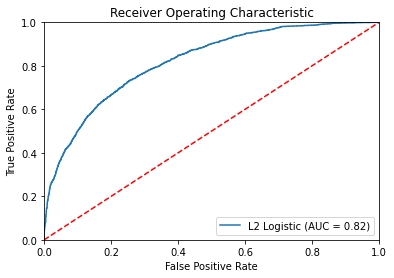

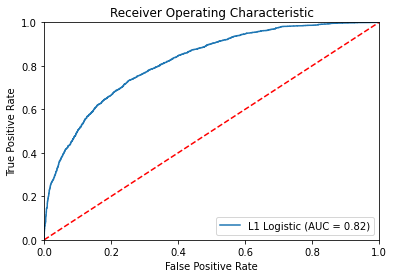

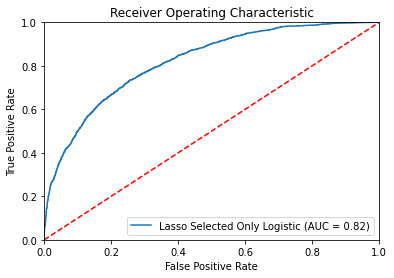

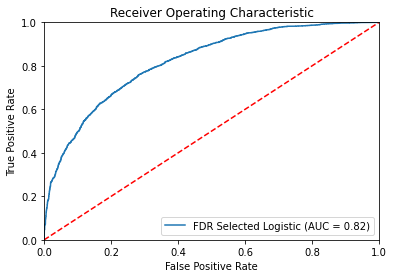

In [64]:
#get the ROC-AUC plot for test data and a classifier

#predict_proba gets both predictions and probabilities

def AUC(roc_x_test, roc_y_test, roc_clf):
    probs = roc_clf.predict_proba(roc_x_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(roc_y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc
    
#CHECK THIS
#shamelessly stolen from stackoverflow
#def ROC_plot(roc_x_test, roc_y_test, roc_clf):
#    probs = roc_clf.predict_proba(roc_x_test)
#    preds = probs[:,1]
#    fpr, tpr, threshold = metrics.roc_curve(roc_y_test, preds)
#    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
#    plt.title('Receiver Operating Characteristic')
#    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
#    plt.legend(loc = 'lower right')
#    plt.plot([0, 1], [0, 1],'r--')
#    plt.xlim([0, 1])
#    plt.ylim([0, 1])
#    plt.ylabel('True Positive Rate')
#    plt.xlabel('False Positive Rate')
#    plt.show()

def ROC_plot(roc_x_test, roc_y_test, roc_clf, name=None):
    metrics.plot_roc_curve(roc_clf, roc_x_test, roc_y_test, name=name)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.show()

ROC_plot(x_test_norm, y_test, clf, "L2 Logistic")
ROC_plot(x_test_norm, y_test, clf_l1, "L1 Logistic")
ROC_plot(lasso_test, y_test, clf_l1_CV, "Lasso Selected Only Logistic")
ROC_plot(x_test_new, y_test, fdr_clf, "FDR Selected Logistic")


In [65]:
#l2_auc=AUC(x_test_norm, y_test, clf)
#l1_auc=AUC(x_test_norm, y_test, clf_l1)
#sparse_auc=AUC(lasso_test, y_test, clf_l1_CV)
#fdr_auc=AUC(x_test_new, y_test, fdr_clf)

#### SVM

In [66]:
#do a grid search to determine the best penalty (C) and kernel type for the SVM
svm_param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000, 2000], 'gamma': ["scale", "auto",0.01, 0.001, 0.0001, 0.00001], 'kernel': ['rbf']}]

#fit an SVM with the best of the param grid
#svc=svm.SVC(probability=True, kernel="rbf")
start=time.time()
#lin_svm=svc.fit(x_train_norm, y_train)

### REALLY SLOW
#because svms scale between O(n_features*n_samples^2) and O(n_feates*n_samples^3)
#https://stackoverflow.com/questions/40077432/why-is-scikit-learn-svm-svc-extremely-slow
#also probability=True makes it really slow
svm_grid=GridSearchCV(svm.SVC(max_iter=5000), svm_param_grid, n_jobs=-1, verbose=10, cv=3).fit(x_train_norm, y_train)

sec_start=time.time()
print("start final: ", sec_start)
params=svm_grid.best_params_
print(params)
final_svm=svm.SVC(**svm_grid.best_params_, probability=True, max_iter=5000, random_state=RANDOM_STATE).fit(x_train_norm, y_train)
print("sec done: ", time.time()-sec_start)
svm_fit=svm_grid.best_estimator_
print(time.time()-start)
print(svm_grid.best_score_)

#predict and score the SVM
svm_pred=final_svm.predict(x_test_norm)
svm_prob=final_svm.predict_proba(x_test_norm)[:,1]

svm_score=svm_fit.score(x_test_norm, y_test)
svm_auc=roc_auc_score(y_test, svm_prob)
svm_f1=f1_score(y_test, svm_pred)
#svm_auc=AUC(x_test_norm, y_test, svm_fit)
print(svm_score)
confusion_matrix(y_test, svm_pred)


Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  93 out of 105 | elapsed:  2.7min remaining:   20.8s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  3.0min finished
C:\Users\andyk\Anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


start final:  1605304387.9622152
{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


C:\Users\andyk\Anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


sec done:  58.78140425682068
248.15769481658936
0.738178595745041
0.7334851936218679


array([[2183,  953],
       [ 685, 2325]], dtype=int64)

In [67]:
fin_svm_pred=final_svm.predict(x_test_norm)

print(final_svm.score(x_test_norm, y_test))
confusion_matrix(y_test, fin_svm_pred)

0.7334851936218679


array([[2183,  953],
       [ 685, 2325]], dtype=int64)

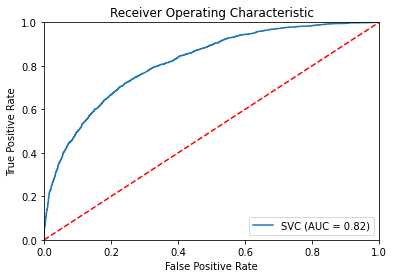

In [68]:
ROC_plot(x_test_norm, y_test, final_svm)

       expected_retwin_diff  ace_perc_diff
10807             -0.015231      -0.021001
14774             -0.034963       0.040636
18547             -0.034045       0.066539
6792               0.011226      -0.025694
16339              0.050939       0.042310
...                     ...            ...
1039               0.088471      -0.077703
16652              0.080517      -0.038075
1343              -0.075755       0.018976
13493              0.015908       0.031393
8711              -0.107517       0.050167

[14338 rows x 2 columns]
60.02289605140686


C:\Users\andyk\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:247: UserWarning: No contour levels were found within the data range.
  antialiased=True)


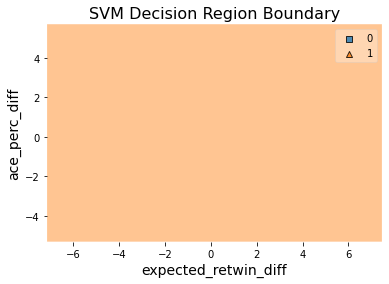

In [69]:
from mlxtend.plotting import plot_decision_regions

plot_cols=["expected_retwin_diff", "ace_perc_diff"]

print(x_train[plot_cols])

plot_col_locs=[x_train.columns.get_loc(c) for c in plot_cols if c in x_train]

value=1.5
width=0.75

value_dict={i: value for i in range(x_train_norm.shape[1]) if i not in plot_col_locs}
ranges_dict={i: width for i in range(x_train_norm.shape[1]) if i not in plot_col_locs}

start=time.time()
fig = plot_decision_regions(x_train_norm, y_train.values, clf=final_svm,
              feature_index=plot_col_locs,                        #these one will be plotted  
              filler_feature_values=value_dict,  #these will be ignored
              filler_feature_ranges=ranges_dict)

print(time.time()-start)
#plot_decision_regions(X=x_train_norm, 
#                      y=y_train.values,
#                      clf=lin_svm, 
#                      legend=2)

# Update plot object with X/Y axis labels and Figure Title
plt.xlabel(x_train.columns[plot_col_locs[0]], size=14)
plt.ylabel(x_train.columns[plot_col_locs[1]], size=14)
#plt.xlim(-10,10)
#plt.ylim(-10,10)
#plt.xlabel(x_train.columns[0], size=14)
#plt.ylabel(x_train.columns[1], size=14)
plt.title('SVM Decision Region Boundary', size=16)
plt.show()

#### Naive Bayes

In [70]:
#fit, predict, score a Naive Bayes model
gnb=GaussianNB()
gnb_fit=gnb.fit(x_train_norm, y_train)
gnb_pred=gnb_fit.predict(x_test_norm)
gnb_prob=gnb_fit.predict_proba(x_test_norm)[:,1]
confusion_matrix(y_test, gnb_pred)
gnb_score=gnb_fit.score(x_test_norm, y_test)
gnb_auc=roc_auc_score(y_test, gnb_prob)
gnb_f1=f1_score(y_test, gnb_pred)
#gnb_auc=AUC(x_test_norm, y_test, gnb_fit)
print(gnb_score)

0.7139602993817117


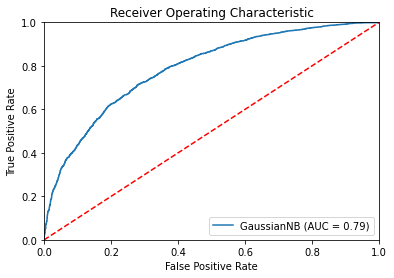

In [71]:
ROC_plot(x_test_norm, y_test, gnb_fit)

### Random Forest 

In [72]:
#fit, predict, score a Random Forest model
rf_param_grid={'max_depth': [10, 50, 100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10, 12, 15],
 'n_estimators': [100, 500, 1000, 2000]}
rf=RandomForestClassifier(random_state=RANDOM_STATE, max_features="sqrt")
start=time.time()
#rf_grid=GridSearchCV(rf, rf_param_grid, verbose=10, n_jobs=-1, cv=3).fit(x_train_norm, y_train)
#rf_fit=rf_grid.best_estimator_
#print(rf_grid.best_score_)
#print(time.time()-start)
#print(rf_grid.best_params_)
rf_fit=rf.fit(x_train_norm, y_train)
rf_pred=rf_fit.predict(x_test_norm)
rf_prob=rf_fit.predict_proba(x_test_norm)[:,1]
rf_score=rf_fit.score(x_test_norm, y_test)
rf_auc=roc_auc_score(y_test, rf_prob)
rf_f1=f1_score(y_test, rf_pred)
#rf_auc=AUC(x_test_norm, y_test, rf_fit)
print(rf_score)
confusion_matrix(y_test, rf_pred)


0.722746501789782


array([[2305,  831],
       [ 873, 2137]], dtype=int64)

In [73]:
feature_importances = pd.DataFrame(rf_fit.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

importance
retwon_perc_diff              0.063709
expected_retwin_diff          0.049808
srvwon_perc_diff              0.049023
expected_srvwin_diff          0.048140
rank_points_log_diff          0.046001
h2h_rank_log_diff             0.045984
rank_log_diff                 0.044467
bp_per_retgame_diff           0.043985
h2h_rank_points_log_diff      0.041472
bp_per_svgame_diff            0.037625
bp_conv_perc_diff             0.034926
2ndwin_perc_diff              0.031931
1stwin_perc_diff              0.030574
bp_save_perc_diff             0.029501
srvgames_won_perc_diff        0.025496
retgames_won_perc_diff        0.024415
ace_perc_diff                 0.024371
1stsrv_perc_diff              0.023197
1steff_diff                   0.023054
h2h_age_diff                  0.023027
df_perc_diff                  0.022991
age_diff                      0.022977
gameswon_perc_diff            0.022725
setswon_perc_diff             0.022389
2ndsrv_perc_diff              0.022081
ht_diff                       0.016949
h2h_ace_perc_diff             0.007710
h2h_1stsrv_perc_diff          0.007359
h2h_bp_conv_perc_diff         0.007144
h2h_1steff_diff               0.007111
h2h_2ndsrv_perc_diff          0.007043
h2h_bp_save_perc_diff         0.006997
h2h_1stwin_perc_diff          0.006963
h2h_ht_diff                   0.006702
h2h_2ndwin_perc_diff          0.006639
h2h_srvwon_perc_diff          0.006545
h2h_retwon_perc_diff          0.006474
h2h_df_perc_diff              0.006418
h2h_srvgames_won_perc_diff    0.006384
h2h_bp_per_retgame_diff       0.006295
h2h_expected_srvwin_diff      0.006061
h2h_retgames_won_perc_diff    0.005947
h2h_bp_per_svgame_diff        0.005939
h2h_gameswon_perc_diff        0.005797
h2h_expected_retwin_diff      0.005698
h2h_setswon_perc_diff         0.003957

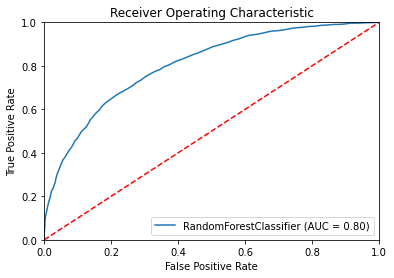

In [74]:
ROC_plot(x_test_norm, y_test, rf_fit)

In [75]:
#pd.DataFrame(rf_grid.best_params_, index=range(1))

In [76]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
#pickle_PATH=os.path.join(PATH, "objs.pkl")
#with open(pickle_PATH, 'w') as f:  # Python 3: open(..., 'wb')
#    pickle.dump([rf_grid.best_params_], f)

# Getting back the objects:
#with open(pickle_PATH) as f:  # Python 3: open(..., 'rb')
#    obj0 = pickle.load(f)

### XGBoost

In [77]:
#fit, predict, score a XGBoost model
xgb_param={"n_estimators": [100, 300, 500, 800, 1200]}
xgb=XGBClassifier(random_state=RANDOM_STATE)
start=time.time()
xgb_fit=GridSearchCV(xgb, xgb_param, verbose=1, n_jobs=-1, cv=3).fit(x_train_norm, y_train)
print(time.time()-start)
xgb_pred=xgb_fit.predict(x_test_norm)
xgb_prob=xgb_fit.predict_proba(x_test_norm)[:,1]
xgb_score=xgb_fit.score(x_test_norm, y_test)
xgb_auc=roc_auc_score(y_test, xgb_prob)
xgb_f1=f1_score(y_test, xgb_pred)
#xgb_auc=AUC(x_test_norm, y_test, xgb_fit)
print(xgb_score)
confusion_matrix(y_test, xgb_pred)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   23.9s remaining:   20.9s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   45.0s finished


47.71443581581116
0.734136023429873


array([[2322,  814],
       [ 820, 2190]], dtype=int64)

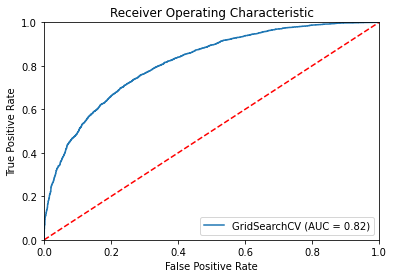

In [78]:
ROC_plot(x_test_norm, y_test, xgb_fit)

## Compare Models

Should be pretty balanced data (in who wins p1 and p2 should be roughly equivalent and made the training data very close to exactly equivalent) so accuracy might be useful. ROCAUC and F1 also

https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc


https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc 
"Conversely if both classes make up 50% of your dataset, or both make up a sizable fraction, and you care about your performance in identifying each class equally, then you should use the AUC, which optimizes for both classes, positive and negative."

In [85]:
model_names=["PCAR", "l2 Logistic", "l1 Logistic", "sparse logistic", "FDR logistic", "SVM", "Naive Bayes", "Random Forest", "XGBoost"]
models=[pca_clf, clf, clf_l1, clf_l1_CV, fdr_clf, final_svm, gnb_fit, rf_fit, xgb_fit]
scores=[pca_score, l2_score, l1_score, sparse_score, fdr_score, svm_score, gnb_score, rf_score, xgb_score]
aucs=[pca_auc, l2_auc, l1_auc, sparse_auc, fdr_auc, svm_auc, gnb_auc, rf_auc, xgb_auc]
f1s=[pca_f1, l2_f1, l1_f1, sparse_f1, fdr_f1, svm_f1, gnb_f1, rf_f1, xgb_f1]
models_dict={"model name": model_names, "model": models, "accuracy": scores, "auc": aucs, "f1": f1s}
model_df=pd.DataFrame(models_dict)
f1_df=model_df.sort_values(by=["f1"], ascending=False)
auc_df=model_df.sort_values(by=["auc"], ascending=False)

#f1_df.to_csv(os.path.join(PATH, "f1_df_noh2h.csv"), index=False)
#auc_df.to_csv(os.path.join(PATH, "auc_df_noh2h.csv"), index=False)
f1_df

model name                                              model  \
5              SVM  SVC(C=100, gamma=0.0001, max_iter=5000, probab...   
2      l1 Logistic  LogisticRegression(penalty='l1', random_state=...   
1      l2 Logistic  LogisticRegressionCV(Cs=[1, 10, 100, 1000], cv...   
3  sparse logistic  LogisticRegressionCV(Cs=[1, 10, 100, 1000], cv...   
8          XGBoost  GridSearchCV(cv=3, estimator=XGBClassifier(ran...   
0             PCAR  LogisticRegressionCV(Cs=[1, 10, 100, 1000], cv...   
4     FDR logistic  LogisticRegressionCV(Cs=[1, 10, 100, 1000], cv...   
7    Random Forest  (DecisionTreeClassifier(max_features='sqrt', r...   
6      Naive Bayes                                       GaussianNB()   

   accuracy       auc        f1  
5  0.733485  0.818349  0.739504  
2  0.738529  0.820542  0.730595  
1  0.738204  0.820330  0.730531  
3  0.737553  0.820206  0.729951  
8  0.734136  0.816265  0.728301  
0  0.735438  0.813432  0.727821  
4  0.734950  0.819867  0.726448  
7  0.722747  0.804490  0.714955  
6  0.713960  0.789099  0.705725

In [89]:
auc_df

model name                                              model  \
2      l1 Logistic  LogisticRegression(penalty='l1', random_state=...   
1      l2 Logistic  LogisticRegressionCV(Cs=[1, 10, 100, 1000], cv...   
3  sparse logistic  LogisticRegressionCV(Cs=[1, 10, 100, 1000], cv...   
4     FDR logistic  LogisticRegressionCV(Cs=[1, 10, 100, 1000], cv...   
5              SVM  SVC(C=100, gamma=0.0001, max_iter=5000, probab...   
8          XGBoost  GridSearchCV(cv=3, estimator=XGBClassifier(ran...   
0             PCAR  LogisticRegressionCV(Cs=[1, 10, 100, 1000], cv...   
7    Random Forest  (DecisionTreeClassifier(max_features='sqrt', r...   
6      Naive Bayes                                       GaussianNB()   

   accuracy       auc        f1  
2  0.738529  0.820542  0.730595  
1  0.738204  0.820330  0.730531  
3  0.737553  0.820206  0.729951  
4  0.734950  0.819867  0.726448  
5  0.733485  0.818349  0.739504  
8  0.734136  0.816265  0.728301  
0  0.735438  0.813432  0.727821  
7  0.722747  0.804490  0.714955  
6  0.713960  0.789099  0.705725

In [93]:
best_clf=auc_df.head(1)["model"].values[0]

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [83]:
f1_df_noh2h=pd.read_csv(os.path.join(PATH, "f1_df_noh2h.csv"))
auc_df_noh2h=pd.read_csv(os.path.join(PATH, "auc_df_noh2h.csv"))

f1_df_noh2h

model  accuracy       auc        f1
0              SVM  0.727357  0.811506  0.745263
1     FDR logistic  0.734479  0.816381  0.736032
2      l1 Logistic  0.732931  0.817527  0.735064
3      l2 Logistic  0.732312  0.817389  0.734449
4  sparse logistic  0.732312  0.817216  0.734449
5             PCAR  0.731228  0.815724  0.733005
6          XGBoost  0.730918  0.816105  0.731873
7    Random Forest  0.722558  0.806011  0.720087
8      Naive Bayes  0.712030  0.788909  0.713670

In [84]:
auc_df_noh2h

model  accuracy       auc        f1
0      l1 Logistic  0.732931  0.817527  0.735064
1      l2 Logistic  0.732312  0.817389  0.734449
2  sparse logistic  0.732312  0.817216  0.734449
3     FDR logistic  0.734479  0.816381  0.736032
4          XGBoost  0.730918  0.816105  0.731873
5             PCAR  0.731228  0.815724  0.733005
6              SVM  0.727357  0.811506  0.745263
7    Random Forest  0.722558  0.806011  0.720087
8      Naive Bayes  0.712030  0.788909  0.713670

## Mixed Effects

In [105]:
import statsmodels.genmod.bayes_mixed_glm as sgb

In [106]:
print(sm_diff["Win"].shape, sm_diff.loc[:, ~sm_diff.columns.isin(["Win", "surface"])].shape, sm_diff["surface"].shape)

(21201,) (21201, 53) (21201,)


In [113]:
#test train split
print(drop_cols)
me_drop_cols=[dc for dc in drop_cols if dc!="surface"]
print(sm_diff.columns)
me_x_train, me_x_test, me_y_train, me_y_test=train_test_split(sm_diff.drop(me_drop_cols, axis=1), 
                                                  sm_diff["Win"], 
                                                  test_size=0.3,
                                                  random_state=RANDOM_STATE)

me_train_data=pd.concat([me_x_train, me_y_train], axis=1)

['Win', 'name_p1', 'name_p2', 'surface', 'Date', 'h2h_name_p1', 'h2h_name_p2']
Index(['name_p1', 'name_p2', 'surface', 'Date', 'Win', 'h2h_name_p1',
       'h2h_name_p2', '1steff_diff', 'h2h_1steff_diff', '1stsrv_perc_diff',
       'h2h_1stsrv_perc_diff', '1stwin_perc_diff', 'h2h_1stwin_perc_diff',
       '2ndeff_diff', 'h2h_2ndeff_diff', '2ndsrv_perc_diff',
       'h2h_2ndsrv_perc_diff', '2ndwin_perc_diff', 'h2h_2ndwin_perc_diff',
       'ace_perc_diff', 'h2h_ace_perc_diff', 'age_diff', 'h2h_age_diff',
       'bp_conv_perc_diff', 'h2h_bp_conv_perc_diff', 'bp_per_retgame_diff',
       'h2h_bp_per_retgame_diff', 'bp_per_svgame_diff',
       'h2h_bp_per_svgame_diff', 'bp_save_perc_diff', 'h2h_bp_save_perc_diff',
       'df_perc_diff', 'h2h_df_perc_diff', 'expected_retwin_diff',
       'h2h_expected_retwin_diff', 'expected_srvwin_diff',
       'h2h_expected_srvwin_diff', 'gameswon_perc_diff',
       'h2h_gameswon_perc_diff', 'ht_diff', 'h2h_ht_diff', 'rank_log_diff',
       'h2h_rank_log_

In [114]:
#check if this vc is right (esp 1 vs 0 and the C thing)
vc={"surface": "1+C(surface)"}
formula="Win~retwon_perc_diff"
surface_me=sgb.BinomialBayesMixedGLM.from_formula(formula, vc_formulas=vc, data=me_train_data)
#fit_map and fit_vb give very different post means and post sds, look at this more
surface_me_result=surface_me.fit_map()
surface_me_result.summary()
#surface_me=sgb.BinomialBayesMixedGLM(endog=sm_diff["Win"], exog=sm_diff.loc[:, ~sm_diff.columns.isin(["Win", "surface"])], exog_vc=sm_diff["surface"])

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Binomial Mixed GLM Results
===============================================================
                 Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
---------------------------------------------------------------
Intercept           M     0.0143   0.0567                      
retwon_perc_diff    M    18.2648   0.4303                      
surface             V    -2.9925   1.0015 0.050   0.007   0.372
===============================================================
Parameter types are mean structure (M) and variance structure
(V)
Variance parameters are modeled as log standard deviations
"""

In [116]:
surface_me_fitted=surface_me_result.predict()
print(surface_me_pred)
confusion_matrix(y_test, surface_me_pred)

[0.24200901 0.43918399 0.52796903 ... 0.61469782 0.56204034 0.53185024]


ValueError: Found input variables with inconsistent numbers of samples: [6361, 14840]

# Method 3 Prediction

Use a multivariate random sample with mean of the players h2h dist and cov from full columns to generate new rows. These are the predicted stats for a given match. Then, predict using the above trained models

### Mean and Covarariance

In [94]:
#only numeric columns from sm_perc
num_sm_perc=sm_perc.select_dtypes(include=np.number)

#scale the data
cov_scaler=StandardScaler()

scaled_sm_perc=cov_scaler.fit_transform(num_sm_perc)
scaled_cov=pd.DataFrame(scaled_sm_perc, index=num_sm_perc.index, columns=num_sm_perc.columns)
scaled_cov.head()
#scaled_sm_names=pd.DataFrame(scaler.fit_transform(sm_names.loc[:, x_train.columns]), index=sm_names.index, columns=sm_names.columns)
#scaled_sm_names

srvwon_perc_p1  srvwon_perc_p2  retwon_perc_p1  retwon_perc_p2  \
44       -0.555350       -0.472100        0.497349       -1.307301   
45       -0.197649        0.069709       -0.213203        0.024146   
46       -0.034474       -0.215799        0.366416        0.546712   
47        1.305102       -0.471408        0.088915       -1.062054   
48       -0.580550        0.378188        0.482151       -0.363720   

    bp_save_perc_p1  bp_save_perc_p2  bp_conv_perc_p1  bp_conv_perc_p2  \
44         0.627124        -0.716372        -0.319202        -0.514514   
45        -0.605610         1.189065         0.246833        -1.051893   
46        -0.068467        -0.337787         0.747171        -0.524182   
47         0.202552        -1.273292        -0.053081        -2.177346   
48        -0.014724         0.303053         0.639161        -1.202322   

    ace_perc_p1  ace_perc_p2  ...  expected_retwin_p2  rank_log_p1  \
44    -0.661623     2.172396  ...           -0.558568    -0.015922   
45     0.341324     0.539719  ...           -0.416110    -0.012288   
46    -0.506100    -0.969646  ...            0.353486    -0.022711   
47     2.368460    -1.271450  ...            0.966040    -0.014678   
48    -0.796449     1.287203  ...           -0.595534     0.004138   

    rank_log_p2  rank_points_log_p1  rank_points_log_p2     ht_p1     ht_p2  \
44     0.032083           -0.027446           -0.075497 -1.144046  1.011941   
45     0.019349           -0.029381           -0.058226  0.288695  1.011941   
46    -0.006248           -0.023939           -0.037749 -0.857498  0.578260   
47     0.016456           -0.028987           -0.055458  1.434887 -1.590144   
48    -0.028594           -0.042055           -0.024855 -0.857498  2.168424   

      age_p1    age_p2       Win  
44  0.362474  0.656345  1.001563  
45  0.167345  0.143816 -0.998439  
46 -0.298399 -0.254030  1.001563  
47  0.625256 -1.136797  1.001563  
48 -0.515604  0.875798 -0.998439  

[5 rows x 47 columns]

In [95]:
#stats that don't randomly fluctuate from match to match
fixed=["ht", "age", "rank_log", "rank_points_log"]

#get the covariance between the statistic types
def full_cov(df):
    #both p1 and p2 cols for each stat considered as one
    p1=df.loc[:, df.columns.str.endswith("p1")]
    p2=df.loc[:, df.columns.str.endswith("p2")]
    
    good_cols=["_".join(x.split("_")[:-1]) for x in list(p1.columns)]
    
    p1.columns=good_cols
    p2.columns=good_cols
    
    print(pd.concat([p1, p2]))
    
    #dont include the "fixed" columns
    #get the covariance between the stats
    both_cov=pd.concat([p1, p2]).drop(fixed, axis=1).cov()
    
    return both_cov

covs=full_cov(scaled_cov)
covs

       srvwon_perc  retwon_perc  bp_save_perc  bp_conv_perc  ace_perc  \
44       -0.555350     0.497349      0.627124     -0.319202 -0.661623   
45       -0.197649    -0.213203     -0.605610      0.246833  0.341324   
46       -0.034474     0.366416     -0.068467      0.747171 -0.506100   
47        1.305102     0.088915      0.202552     -0.053081  2.368460   
48       -0.580550     0.482151     -0.014724      0.639161 -0.796449   
...            ...          ...           ...           ...       ...   
20793     1.281078     0.552033      1.003972      1.076020  0.636419   
20794     2.574579     1.217076      1.304549      0.957316  0.630926   
20795     0.895092     0.447284     -0.161805     -0.247586  1.575613   
20796     2.506805     1.209536      0.388505      1.084362  0.784097   
20797     1.260842    -0.500711      1.038218     -0.235622  0.132456   

        df_perc  bp_per_retgame  bp_per_svgame  1stsrv_perc  2ndsrv_perc  ...  \
44     0.224665        0.552825       1.16

srvwon_perc  retwon_perc  bp_save_perc  bp_conv_perc  \
srvwon_perc           1.000024     0.029259      0.586453      0.011663   
retwon_perc           0.029259     1.000024      0.019231      0.497913   
bp_save_perc          0.586453     0.019231      1.000024      0.000936   
bp_conv_perc          0.011663     0.497913      0.000936      1.000024   
ace_perc              0.660332    -0.373658      0.380419     -0.203023   
df_perc              -0.242049    -0.187633     -0.147786     -0.100986   
bp_per_retgame        0.012822     0.896897      0.013368      0.191286   
bp_per_svgame        -0.903660    -0.041428     -0.276478     -0.027577   
1stsrv_perc           0.203128     0.060254      0.132557      0.029535   
2ndsrv_perc           0.192808     0.180381      0.115115      0.096973   
1stwin_perc           0.870760    -0.090368      0.504829     -0.056837   
2ndwin_perc           0.729297     0.157088      0.428090      0.089828   
gameswon_perc         0.009677     0.024389      0.027187      0.002242   
setswon_perc         -0.002498     0.004793      0.020240     -0.002356   
srvgames_won_perc     0.516350    -0.509043      0.365930     -0.335897   
retgames_won_perc    -0.560226     0.523893     -0.373696      0.326326   
1steff                0.055106    -0.235604      0.022514     -0.145365   
expected_srvwin       0.955877     0.082636      0.562320      0.040878   
expected_retwin       0.084176    -0.122777      0.044906     -0.056166   

                   ace_perc   df_perc  bp_per_retgame  bp_per_svgame  \
srvwon_perc        0.660332 -0.242049        0.012822      -0.903660   
retwon_perc       -0.373658 -0.187633        0.896897      -0.041428   
bp_save_perc       0.380419 -0.147786        0.013368      -0.276478   
bp_conv_perc      -0.203023 -0.100986        0.191286      -0.027577   
ace_perc           1.000024  0.108979       -0.343754      -0.587330   
df_perc            0.108979  1.000024       -0.160491       0.216974   
bp_per_retgame    -0.343754 -0.160491        1.000024      -0.019685   
bp_per_svgame     -0.587330  0.216974       -0.019685       1.000024   
1stsrv_perc       -0.098647 -0.383785        0.058024      -0.168175   
2ndsrv_perc       -0.083461 -0.937424        0.153072      -0.177221   
1stwin_perc        0.791331  0.030572       -0.095047      -0.791646   
2ndwin_perc        0.288673 -0.012320        0.135668      -0.659656   
gameswon_perc      0.007920  0.008957        0.017495       0.006585   
setswon_perc       0.010160  0.026448        0.002748       0.019650   
srvgames_won_perc  0.540996 -0.016545       -0.464799      -0.452466   
retgames_won_perc -0.568331  0.037999        0.477651       0.512133   
1steff             0.409465  0.045463       -0.217112      -0.053498   
expected_srvwin    0.549777 -0.516476        0.059914      -0.863236   
expected_retwin    0.063075 -0.043925       -0.112663      -0.077590   

                   1stsrv_perc  2ndsrv_perc  1stwin_perc  2ndwin_perc  \
srvwon_perc           0.203128     0.192808     0.870760     0.729297   
retwon_perc           0.060254     0.180381    -0.090368     0.157088   
bp_save_perc          0.132557     0.115115     0.504829     0.428090   
bp_conv_perc          0.029535     0.096973    -0.056837     0.089828   
ace_perc             -0.098647    -0.083461     0.791331     0.288673   
df_perc              -0.383785    -0.937424     0.030572    -0.012320   
bp_per_retgame        0.058024     0.153072    -0.095047     0.135668   
bp_per_svgame        -0.168175    -0.177221    -0.791646    -0.659656   
1stsrv_perc           1.000024     0.061786    -0.159308     0.176574   
2ndsrv_perc           0.061786     1.000024     0.025104    -0.043020   
1stwin_perc          -0.159308     0.025104     1.000024     0.447097   
2ndwin_perc           0.176574    -0.043020     0.447097     1.000024   
gameswon_perc        -0.037256     0.001322     0.015413     0.024937   
setswon_perc         -0.031660    -0.020673     0.00281

In [96]:
#get a players average for each stat within the last num_matches matches
def player_mean(player, match_df, num_matches):
    p1=match_df.loc[match_df["name_p1"]==player, match_df.columns.str.endswith("p1")]
    p2=match_df.loc[match_df["name_p2"]==player, match_df.columns.str.endswith("p2")]
    
    good_cols=["_".join(x.split("_")[:-1]) for x in list(p1.columns)]
    
    p1.columns=good_cols
    p2.columns=good_cols
    
    player_match=pd.concat([p1, p2]).drop(fixed, axis=1).sort_index()
    
    recent_mean=player_match.tail(num_matches).mean()
  
    return recent_mean

fed=player_mean("Roger Federer", sm_perc, 5)
fed

srvwon_perc          0.692057
retwon_perc          0.395819
bp_save_perc         0.678195
bp_conv_perc         0.474298
ace_perc             0.105082
df_perc              0.020866
bp_per_retgame       0.573785
bp_per_svgame        0.367630
1stsrv_perc          0.658490
2ndsrv_perc          0.938898
1stwin_perc          0.762520
2ndwin_perc          0.592336
gameswon_perc        0.495400
setswon_perc         0.527137
srvgames_won_perc    0.798936
retgames_won_perc    0.184761
1steff               1.287684
expected_srvwin      0.671191
expected_retwin      0.610004
dtype: float64

### Generate New Rows

All of the variables having univariate normal distributions suggests that assuming a multivariate normal distribution and sampling from it is justified

In [97]:
def generate_new_oneplayer(player, match_df, num_matches, covs=full_cov(sm_perc)):
    
    #get the players means
    means=player_mean(player, match_df, num_matches)
    
    #using the covariance between the statistics
    #sample from the multivariate dist defined by the means and covariances
    new_row=pd.Series(np.random.multivariate_normal(means.values, covs), index=means.index)
    new_row["name"]=player
    
    return new_row

def generate_new_row(player1, player2, match_df, num_matches):
    #get new rows for each player
    new_p1=generate_new_oneplayer(player1, match_df, num_matches)
    new_p2=generate_new_oneplayer(player2, match_df, num_matches)
    
    #fixed columns as series
    p1_app=match_df.loc[match_df["name_p1"]==player1, [f+"_p1" for f in fixed]].iloc[-1]
    p2_app=match_df.loc[match_df["name_p2"]==player2, [f+"_p2" for f in fixed]].iloc[-1]
    
    #get the names of the fixed rows right (its a series)
    p1_app.index=fixed
    p2_app.index=fixed

    #adding back in the columns that don't fluctuate from match to match (like height)
    new_p1_conc=pd.concat([new_p1, p1_app])
    new_p2_conc=pd.concat([new_p2, p2_app])
    
    #properly format column names
    new_p1_conc.index=[c+"_p1" for c in new_p1_conc.index.tolist()]
    new_p2_conc.index=[c+"_p2" for c in new_p2_conc.index.tolist()]
    
    #combine p1 and p2
    new_row=pd.concat([new_p1_conc, new_p2_conc])
    
    return new_row

new_row=generate_new_row("Roger Federer", "Rafael Nadal", sm_perc, 5)

#sm_names.loc[98, ["name_p1", "name_p2", "ht_p1", "ht_p2"]]

       srvwon_perc  retwon_perc  bp_save_perc  bp_conv_perc  ace_perc  \
44        0.609549     0.388166      0.648810      0.374150  0.049706   
45        0.623614     0.362719      0.567164      0.412214  0.089367   
46        0.630030     0.383477      0.602740      0.445860  0.055856   
47        0.682703     0.373539      0.620690      0.392045  0.169530   
48        0.608558     0.387622      0.606299      0.438596  0.044374   
...            ...          ...           ...           ...       ...   
20793     0.682067     0.389739      0.671875      0.467391  0.100845   
20794     0.733054     0.413468      0.691176      0.459459  0.100629   
20795     0.666852     0.386001      0.597015      0.378947  0.137701   
20796     0.730382     0.413199      0.632353      0.467949  0.106640   
20797     0.681269     0.352176      0.674074      0.379747  0.081067   

        df_perc  bp_per_retgame  bp_per_svgame  1stsrv_perc  2ndsrv_perc  ...  \
44     0.040549        0.628205       0.71

In [98]:
test_df=pd.DataFrame({"name_p1": 
                      ["Roger Federer", "Roger Federer", "Rafael Nadal", "Stefanos Tsitsipas", "Marcos Giron", "Rafael Nadal"],
                      "name_p2": 
                      ["Novak Djokovic", "Rafael Nadal", "Roger Federer", "Alexander Zverev", "David Goffin", "Novak Djokovic"]})

In [99]:
generated_test=test_df.apply(lambda row: generate_new_row(row["name_p1"], row["name_p2"], sm_perc, num_matches=5), axis=1)
test_df

name_p1           name_p2
0       Roger Federer    Novak Djokovic
1       Roger Federer      Rafael Nadal
2        Rafael Nadal     Roger Federer
3  Stefanos Tsitsipas  Alexander Zverev
4        Marcos Giron      David Goffin
5        Rafael Nadal    Novak Djokovic

### Add in H2H

In [100]:
def get_h2h(player1, player2, h2h):
    
    try:
        #get all matches with both player 1 and player 2 (in either position)
        #then only the last match
        #print("p1 check: ", h2h.loc[(h2h["name_p1"]==player1)|(h2h["name_p2"]==player1)])
        #print("p2 check: ", h2h.loc[(h2h["name_p1"]==player2)|(h2h["name_p2"]==player2)])
        most_recent=h2h.loc[((h2h["name_p1"]==player1)|(h2h["name_p1"]==player2))&((h2h["name_p2"]==player2)|(h2h["name_p2"]==player1)), :].iloc[-1, :]
        #print("most: ", most_recent)
        #if right order then keep it that way
        if most_recent["name_p1"]==player1:
            return most_recent
        #otherwise flip the p1 and p2 columns
        elif most_recent["name_p2"]==player1:
            p1_cols=most_recent[most_recent.index.str.endswith("p1")].index.tolist()
            p2_cols=most_recent[most_recent.index.str.endswith("p2")].index.tolist()

            most_recent.loc[p1_cols+p2_cols]=most_recent.loc[p2_cols+p1_cols].values

            return most_recent
        else:
            print("something is wrong with the names of the df")
    
    #occurs when the players haven't played each other before
    #return all 0s for the stats
    #then when we do the diff it will be 0, so no effect on prediction
    except IndexError:
        #print("havent played before: ", player1, player2)
        empty_series=pd.Series(0, index=h2h.columns.tolist())
        empty_series["name_p1"]=player1
        empty_series["name_p2"]=player2
        #most_recent=pd.Series(np.zeros(shape=(len(h2h.columns.tolist()), 1)), index=h2h.columns)
        #print(empty_series)
        return empty_series
    
h2h_test=get_h2h("Roger Federer", "Rafael Nadal", h2h_df)
#h2h_test=test_df.apply(lambda row: get_h2h(row["name_p1"], row["name_p2"], h2h_df), axis=1)
h2h_df
    

srvwon_perc_p1  srvwon_perc_p2  retwon_perc_p1  retwon_perc_p2  \
0            0.000000        0.000000        0.000000        0.000000   
1            0.000000        0.000000        0.000000        0.000000   
2            0.000000        0.000000        0.000000        0.000000   
3            0.000000        0.000000        0.000000        0.000000   
4            0.000000        0.000000        0.000000        0.000000   
...               ...             ...             ...             ...   
20793        0.000000        0.000000        0.000000        0.000000   
20794        0.608280        0.728440        0.271560        0.391720   
20795        0.694118        0.598485        0.401515        0.305882   
20796        0.649393        0.665274        0.334726        0.350607   
20797        0.612137        0.588771        0.411229        0.387863   

       bp_save_perc_p1  bp_save_perc_p2  bp_conv_perc_p1  bp_conv_perc_p2  \
0             0.000000         0.000000         0.000000         0.000000   
1             0.000000         0.000000         0.000000         0.000000   
2             0.000000         0.000000         0.000000         0.000000   
3             0.000000         0.000000         0.000000         0.000000   
4             0.000000         0.000000         0.000000         0.000000   
...                ...              ...              ...              ...   
20793         0.000000         0.000000         0.000000         0.000000   
20794         0.689189         0.800000         0.200000         0.310811   
20795         0.785714         0.592593         0.407407         0.214286   
20796         0.616883         0.686275         0.313725         0.383117   
20797         0.687500         0.500000         0.500000         0.312500   

       ace_perc_p1  ace_perc_p2  ...  rank_log_p1  rank_log_p2  \
0         0.000000     0.000000  ...     3.871201     4.343805   
1         0.000000     0.000000  ...     4.276666     3.583519   
2         0.000000     0.000000  ...     5.398163     3.465736   
3         0.000000     0.000000  ...     4.234107     3.806662   
4         0.000000     0.000000  ...     3.178054     2.944439   
...            ...          ...  ...          ...          ...   
20793     0.000000     0.000000  ...     4.605170     1.098612   
20794     0.148089     0.049541  ...     3.555348     0.693147   
20795     0.050980     0.034091  ...     1.609438     1.945910   
20796     0.101774     0.061281  ...     1.098612     0.693147   
20797     0.035620     0.039454  ...     0.693147     1.609438   

       rank_points_log_p1  rank_points_log_p2   ht_p1   ht_p2     age_p1  \
0                6.652863            6.272877     0.0     0.0  25.648186   
1                6.308098            6.866933     0.0     0.0  26.609172   
2                5.075174            6.902743     0.0     0.0  30.688569   
3                6.354370            6.692084     0.0     0.0  26.696783   
4                7.034388            7.162397     0.0     0.0  19.266256   
...                   ...                 ...     ...     ...        ...   
20793            6.350886            8.793309     0.0     0.0  28.498289   
20794            7.173958            9.181941  1372.0  1316.0  29.065024   
20795            8.681011            8.115222   555.0   594.0  26.379192   
20796            8.793309            9.181941  3700.0  3760.0  38.450376   
20797            9.181941            8.681011  1504.0  1480.0  32.665298   

          age_p2          name_p1           name_p2  
0      27.863107       Jiri Novak    Chris Woodruff  
1      31.104723   Julien Boutter       Byron Black  
2      25.388090      Alex Obrien      Albert Costa  
3      35.408624     Karol Kucera    Gianluca Pozzi  
4      22.858316    Roger Federer    Dominik Hrbaty  
...          ...              ...               ...  
20793  38.450376  Tennys Sandgren     Roger Federer  
20794  32.665298     Milos Raonic    Novak Djokovic  
20795  22.751

In [101]:
def random_with_h2h(player1, player2, match_df, h2h, num_matches):
    #get new row of stats
    random_row=generate_new_row(player1, player2, match_df, num_matches)
    #get h2h stats
    h2h_row=get_h2h(player1, player2, h2h)
    
    
    
    #proper naming of index (its a series)
    h2h_row.index=["h2h_"+c for c in h2h_row.index.tolist()]
    
    #print("random: ", random_row)
    #print("h2h row: ", h2h_row)
    
    #combine stats and h2h
    combined=pd.concat([random_row, h2h_row])
    
    return combined

def random_h2h_diff(new_match_df, old_match_df, h2h, num_matches):
    #apply random_with_h2h on all rows of new_match_df
    #ie for each new match we want to consider, apply the function
    applied_rand_h2h=new_match_df.apply(lambda row: random_with_h2h(row["name_p1"], row["name_p2"], old_match_df, h2h, num_matches), axis=1)
    
    #print("applied: ", applied_rand_h2h)
    #print("applied eff: ", applied_rand_h2h[["1steff_p1", "1steff_p2", "h2h_1steff_p1", "h2h_1steff_p2"]])
    
    assert applied_rand_h2h[["h2h_1steff_p1"]].isnull().sum().values[0]==0
    
    #take the difference between p1/p2 pairs of stats
    combined_diff=create_diff(applied_rand_h2h, diff_params)
    
    return combined_diff
    

test_rand_h2h=random_h2h_diff(test_df, sm_perc, h2h_df, num_matches=5)
test_rand_h2h

name_p1           name_p2         h2h_name_p1       h2h_name_p2  \
0       Roger Federer    Novak Djokovic       Roger Federer    Novak Djokovic   
1       Roger Federer      Rafael Nadal       Roger Federer      Rafael Nadal   
2        Rafael Nadal     Roger Federer        Rafael Nadal     Roger Federer   
3  Stefanos Tsitsipas  Alexander Zverev  Stefanos Tsitsipas  Alexander Zverev   
4        Marcos Giron      David Goffin        Marcos Giron      David Goffin   
5        Rafael Nadal    Novak Djokovic        Rafael Nadal    Novak Djokovic   

   1steff_diff  h2h_1steff_diff  1stsrv_perc_diff  h2h_1stsrv_perc_diff  \
0    -0.017201         0.171312          0.108844             -0.007164   
1    -0.345903         0.207926          0.182618             -0.104047   
2    -0.153927        -0.207926         -0.089651              0.104047   
3     0.086627        -0.452357         -0.059659             -0.230882   
4    -0.171015         0.000000          0.109766              0.000000   
5     0.193696        -0.075059         -0.078480              0.017263   

   1stwin_perc_diff  h2h_1stwin_perc_diff  ...  retgames_won_perc_diff  \
0          0.035958              0.011502  ...               -0.039187   
1         -0.017877              0.003987  ...                0.114861   
2          0.095882             -0.003987  ...                0.007197   
3          0.078637             -0.102632  ...               -0.123478   
4         -0.046647              0.000000  ...               -0.122771   
5          0.030788             -0.045889  ...               -0.048490   

   h2h_retgames_won_perc_diff  retwon_perc_diff  h2h_retwon_perc_diff  \
0                    0.051769          0.105682             -0.015881   
1                   -0.003905          0.081745             -0.037724   
2                    0.003905          0.070412              0.037724   
3                   -0.045833         -0.052141             -0.045098   
4                    0.000000         -0.206448              0.000000   
5                   -0.042117          0.014264             -0.030861   

   setswon_perc_diff  h2h_setswon_perc_diff  srvgames_won_perc_diff  \
0          -0.147305               0.281250               -0.103121   
1           0.238952               0.016949                0.090372   
2           0.004812              -0.016949                0.067324   
3          -0.102223               0.333333                0.037928   
4           0.177381               0.000000                0.156150   
5          -0.002981              -0.114754                0.047879   

   h2h_srvgames_won_perc_diff  srvwon_perc_diff  h2h_srvwon_perc_diff  
0                    0.061889          0.060845             -0.015881  
1                   -0.014646          0.057563             -0.037724  
2                    0.014646          0.081948              0.037724  
3                   -0.045833          0.071994             -0.045098  
4                    0.000000         -0.009508              0.000000  
5                   -0.027432          0.000720             -0.030861  

[6 rows x 50 columns]

In [102]:
def meth3_predictions(clf, new_match_df, old_match_df, h2h, num_matches):
    #get new stats as differences
    diffs=random_h2h_diff(new_match_df, old_match_df, h2h, num_matches)
    
    #get the same columns as the training data and in the same order
    diffs_dropped=diffs[x_train.columns]
    
    #fill height values
    diffs_dropped["h2h_ht_diff"].fillna(diffs_dropped["ht_diff"], inplace=True)
      
    #predict with probs using the classficiation method provided
    #print("diffs: ", diffs_dropped)
    preds=clf.predict(diffs_dropped)
    probs=clf.predict_proba(diffs_dropped)
    
    return preds, probs

meth3_predictions(clf, test_df, sm_perc, h2h_df, num_matches=5)
    

C:\Users\andyk\Anaconda3\lib\site-packages\pandas\core\series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


(array([1, 0, 1, 1, 1, 1], dtype=int64),
 array([[0.4434749 , 0.5565251 ],
        [0.70254795, 0.29745205],
        [0.41518963, 0.58481037],
        [0.41814093, 0.58185907],
        [0.45958126, 0.54041874],
        [0.34685819, 0.65314181]]))

In [104]:
def simulate(clf, new_match_df, old_match_df, h2h, num_matches, n):
    preds=np.ones((n, new_match_df.shape[0]))
   
    probs=np.ones((n, new_match_df.shape[0], 2))#has probabilities for both winner and loser of winning (sum to 1.) so need extra dim with len 2
    
    #make a diffs array and find the variance across the simulation runs for the different statistics
    warnings.filterwarnings("ignore")
    #for each simulation
    for i in range(n):
        
        #get the predictions and probs of a newly generated match
        pred, prob=meth3_predictions(clf, new_match_df, old_match_df, h2h, num_matches)
    
        #add them to relevant arrays
        preds[i, :]=pred
        probs[i, :, :]=prob
        
        #for keeping track of how quickly the function is running
        if i%10==0:
            print(i)
            
    #average the predictions and the probs
    preds_voting=np.mean(preds, axis=0)
    probs_voting=np.mean(probs, axis=0)
    
    preds_binom=np.random.binomial(n=1, p=probs[:,:,0])
    
    print("binom: ", preds_binom)
    
    #get stds of preds and probs
    preds_sd=np.std(preds, axis=0)
    probs_sd=np.std(probs, axis=0)
    
    z_val=1.96
    alpha=0.05
    
    #confidence interval for the probability
    CI=scipy.stats.norm.interval(1-alpha, loc=probs_voting, scale=probs_sd/np.sqrt(n))
    
    #probs_all=np.broadcast_to(probs_voting, CI)
    #print(probs_all)
    
    #CI=probs_voting-z_val*probs_sd/sqrt(n)
    
    #print("shape: ", probs.shape)
    
    cols=["win_prob", "prob_sd", "CI_lower", "CI_upper"]
    p1p2_cols=[col+side for col in cols for side in ["_p1", "_p2"]]
    #print(len(p1p2_cols), p1p2_cols)
    #print(np.array(probs_voting, probs_sd, CI).shape)
    everything_df=None #pd.DataFrame(np.array([probs_voting, probs_sd, CI[0], CI[1]]).reshape((6,2,4)), columns=p1p2_cols)
    print(everything_df)
    
    return probs, preds_voting, preds_sd, probs_voting, probs_sd, CI, everything_df
    #return preds, preds_voting, probs, probs_voting

import warnings
warnings.filterwarnings("ignore")
start=time.time()
probs, preds_voting, preds_var, probs_voting, probs_var, CI, everything_df=simulate(best_clf, test_df, sm_perc, h2h_df, num_matches=20, n=100)
print("end: ", time.time()-start)    

0
10
20
30
40
50
60
70
80
90
binom:  [[0 1 0 0 0 0]
 [1 0 1 1 1 0]
 [0 0 0 0 1 0]
 [0 1 0 1 1 1]
 [1 0 0 0 1 1]
 [1 1 1 0 0 0]
 [0 0 0 1 1 1]
 [1 0 0 1 1 1]
 [0 1 0 0 0 1]
 [1 1 0 1 1 0]
 [1 1 0 0 0 1]
 [0 0 0 0 1 0]
 [0 1 0 0 1 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 1 0]
 [0 1 1 1 0 0]
 [0 0 0 0 0 1]
 [1 0 0 0 1 0]
 [0 1 0 0 0 0]
 [0 1 0 1 1 0]
 [0 0 0 1 0 0]
 [1 1 0 0 0 0]
 [0 0 0 0 1 0]
 [1 1 0 0 0 0]
 [0 0 0 0 1 1]
 [1 1 0 1 1 0]
 [0 1 0 1 0 0]
 [1 1 1 0 0 0]
 [1 1 0 0 1 0]
 [1 1 1 1 0 0]
 [0 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 0 1 1 0]
 [1 1 0 0 1 0]
 [1 1 0 0 1 0]
 [1 0 0 0 0 1]
 [1 1 1 1 0 0]
 [1 0 1 1 1 0]
 [0 0 0 1 0 0]
 [0 1 1 0 0 0]
 [0 0 0 1 1 1]
 [0 1 0 1 1 0]
 [1 1 0 0 0 0]
 [1 1 0 0 1 0]
 [1 1 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 0 0 1 0]
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 1]
 [1 0 0 0 0 0]
 [1 0 1 0 0 1]
 [0 0 1 1 0 0]
 [0 1 0 0 1 1]
 [1 1 1 0 0 0]
 [1 1 0 0 1 0]
 [0 1 1 1 1 0]
 [0 1 0 1 0 1]
 [1 0 1 0 1 0]
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 1 0 1 0 0]
 [0

In [105]:
everything_df

In [106]:
CI, probs_voting, preds_voting

((array([[0.4891368 , 0.4937215 ],
         [0.62754383, 0.35509588],
         [0.35127559, 0.63359839],
         [0.35500339, 0.62988935],
         [0.46675659, 0.51479316],
         [0.27843311, 0.70790716]]),
  array([[0.5062785 , 0.5108632 ],
         [0.64490412, 0.37245617],
         [0.36640161, 0.64872441],
         [0.37011065, 0.64499661],
         [0.48520684, 0.53324341],
         [0.29209284, 0.72156689]])),
 array([[0.49770765, 0.50229235],
        [0.63622398, 0.36377602],
        [0.3588386 , 0.6411614 ],
        [0.36255702, 0.63744298],
        [0.47598171, 0.52401829],
        [0.28526298, 0.71473702]]),
 array([0.49, 0.  , 1.  , 1.  , 0.72, 1.  ]))

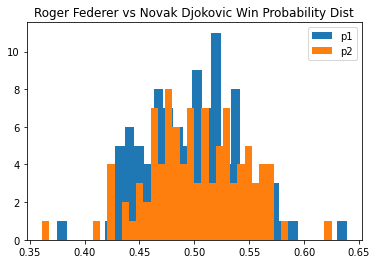

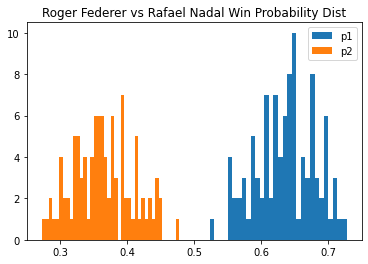

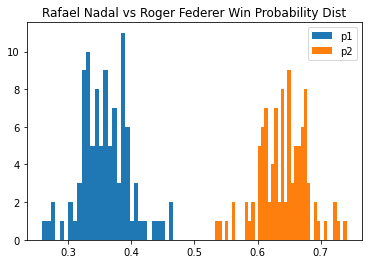

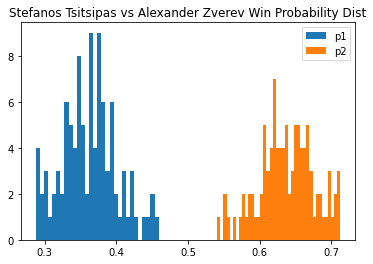

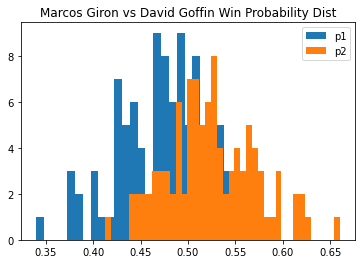

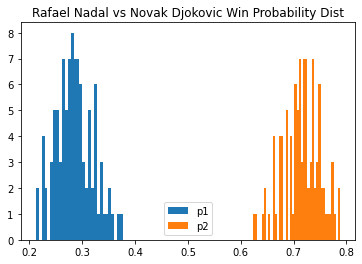

In [107]:
for i in range(test_df.shape[0]):
    plt.hist(probs[:,i,0], bins=30, label="p1")
    plt.hist(probs[:, i, 1], bins=40, label="p2")
    plt.legend()
    plt.title(test_df.loc[i, "name_p1"]+" vs "+test_df.loc[i, "name_p2"]+" Win Probability Dist")
    plt.show()

In [ ]:
new_test_df=pd.DataFrame({"name_p1": 
                      ["Andrey Rublev", "Stan Wawrinka", "Felix Auger Aliassime", "Pablo Carreno Busta"],
                      "name_p2": 
                      ["Lorenzo Sonego", "Daniel Evans", "Marin Cilic", "Hugo Gaston"]})

new_test_df

In [ ]:
probs, preds_voting, preds_var, probs_voting, probs_var, CI, everything_df=simulate(best_clf, new_test_df, sm_perc, h2h_df, num_matches=10, n=500)

In [ ]:
CI